In [1]:
import pickle
import os
import re
import string
import nltk
import numpy as np
import pandas as pd
from nltk import word_tokenize, pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
import scipy.sparse
from scipy.spatial.distance import cdist
from gensim import corpora, models, similarities, matutils
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
with open('../podcasts/podcasts/jhs.pickle', 'rb') as read_jhs:
    jhs_df = pickle.load(read_jhs)

In [3]:
with open('../podcasts/podcasts/aoc.pickle', 'rb') as read_aoc:
    pdf_df = pickle.load(read_aoc)

In [4]:
df = pd.concat([jhs_df,pdf_df],ignore_index=True)

In [14]:
df.head()

,url,title,transcript,source,cleaned,lemmatized
0,https://www.jordanharbinger.com/should-a-cheat...,469: Should a Cheater Get a Second Chance? | F...,"[<p><b>Jordan Harbinger: </b><span style=""font...",JHS,Jordan Harbinger: Welcome to Feedback Friday. ...,Jordan Harbinger : Welcome to Feedback Friday ...
1,https://www.jordanharbinger.com/going-to-north...,435: Going to North Korea: Part One | Stereo S...,[ Welcome to the show. I'm Jordan Harbinger. O...,JHS,Welcome to the show. I'm Jordan Harbinger. On...,Welcome to the show . I 'm Jordan Harbinger . ...
2,https://www.jordanharbinger.com/stuart-ritchie...,436: Stuart Ritchie | The Science Fictions Und...,[ This podcast is brought to you by Microsoft ...,JHS,This podcast is brought to you by Microsoft T...,This podcast is brought to you by Microsoft Te...
3,https://www.jordanharbinger.com/koch-and-hooks...,437: Charles Koch & Brian Hooks | Bottom-Up So...,"[ Coming up on The Jordan Harbinger Show. , [0...",JHS,Coming up on The Jordan Harbinger Show. It's...,Coming up on The Jordan Harbinger Show . It 's...
4,https://www.jordanharbinger.com/how-to-straigh...,438: How to Straighten Out Your Crooked Boss |...,"[<p><b>Jordan Harbinger: </b><span style=""font...",JHS,Jordan Harbinger: Welcome to Feedback Friday. ...,Jordan Harbinger : Welcome to Feedback Friday ...


In [17]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
df['transcript'] = df.transcript.map(alphanumeric).map(punc_lower)
df.head()

TypeError: expected string or bytes-like object

In [49]:
#(541, 44569) With only stop_words='english'
cv1 = CountVectorizer(stop_words='english',strip_accents='unicode',max_df=.40,min_df=15,max_features=1000)
countvect = cv1.fit_transform(df['lemmatized'].apply(lambda x: np.str_(x)))
new_df = pd.DataFrame(countvect.toarray(), columns=cv1.get_feature_names(),index=df['title'])

In [ ]:
with open('countvect.pickle', 'wb') as cv_pickle:
    pickle.dump(countvect, cv_pickle)

In [50]:
#no max/min dfs was 44569, .5/5 was 16640, .4/10=10568
new_df.shape

(541, 1000)

In [50]:
tfidf1 = TfidfVectorizer(stop_words='english',strip_accents='unicode',max_df=.40,min_df=15,max_features=1000)
_tfidf1 = tfidf1.fit_transform(df['lemmatized'].apply(lambda x: np.str_(x)))
new_df2 = pd.DataFrame(_tfidf1.toarray(), columns=tfidf1.get_feature_names(),index=df['title'])

In [13]:
with open('tfidf.pickle', 'wb') as tfidf_pickle:
    pickle.dump(_tfidf1, tfidf_pickle)

In [38]:
new_df2.shape

(541, 1000)

In [17]:
df[df['cleaned'].str.contains('zzjjhjz')]

,url,title,transcript,source,cleaned
266,https://www.jordanharbinger.com/nir-eyal-contr...,250: Nir Eyal | Control Your Attention and Cho...,"[<p><b>Jordan Harbinger:</b><span style=""font-...",JHS,Welcome to the show. I'm Jordan Harbinger. As...


In [18]:
print(df.loc[266,'cleaned'])

 Welcome to the show. I'm Jordan Harbinger. As always, I'm here with producer, Jason DeFillippo. On The Jordan Harbinger Show, we decode the stories, secrets, and skills of the world's most brilliant and interesting people and turn their wisdom into practical advice that you can use to impact your own life and those around you. Chase Jarvis, he's an award-winning artist, entrepreneur ,and one of the most influential photographers of the past decade and he's a friend of mine, which always works well here on the show. He's worked for huge brands like Apple and Red Bull. However, he's also been in some big slumps, lost his creativity, found it again, sacrificed it on the altar of Silicon Valley capitalism like many of us have, and then reclaimed it. Not a bad ride. Today, we'll discuss some of the most common barriers to creativity and our pursuit of a creative outlet or career, whether that's work or family obligations or just a lack of know-how. Of course, we'll also show you how to wor

In [108]:
lsa1 = TruncatedSVD(5)
cv_topic = lsa1.fit_transform(countvect)
lsa1.explained_variance_ratio_

array([0.19635276, 0.10732225, 0.07132552, 0.05106534, 0.04578245])

In [109]:
cv_topic_word = pd.DataFrame(lsa1.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = cv1.get_feature_names())
cv_topic_word

,bottle,boyfriend,camp,cancer,crack,crisis,domain,fbi,friendship,gas,...,population,professor,race,rights,salary,suffering,tank,technique,threat,toxic
component_1,0.022,0.013,0.025,0.050,0.015,0.023,0.010,0.049,0.010,0.030,...,0.016,0.014,0.013,0.014,0.015,0.994,0.012,0.022,0.015,0.016
component_2,0.065,0.064,0.064,0.142,0.097,0.086,0.071,0.873,0.046,0.060,...,0.064,0.057,0.048,0.118,0.059,-0.087,0.065,0.111,0.108,0.056
component_3,0.065,0.086,0.078,0.824,0.046,0.238,0.060,-0.328,0.048,0.064,...,0.089,0.095,0.107,0.026,0.102,-0.061,0.064,0.033,0.067,0.123
component_4,0.056,0.117,0.245,-0.514,0.082,0.543,0.095,-0.221,0.079,0.092,...,0.128,0.059,0.137,0.067,0.089,-0.022,0.084,0.055,0.219,0.067
component_5,-0.077,-0.166,-0.292,0.086,-0.069,0.767,-0.155,0.132,-0.064,-0.038,...,-0.013,-0.032,-0.135,-0.049,-0.136,0.014,-0.067,-0.055,-0.069,-0.129


In [110]:
lsa2 = TruncatedSVD(5)
tfidf_topic = lsa2.fit_transform(_tfidf1)
lsa2.explained_variance_ratio_

array([0.00828699, 0.05832786, 0.05350391, 0.04850087, 0.04559039])

In [111]:
tfidf_topic_word = pd.DataFrame(lsa2.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = tfidf1.get_feature_names())
tfidf_topic_word

,bottle,boyfriend,camp,cancer,crack,crisis,domain,fbi,friendship,gas,...,population,professor,race,rights,salary,suffering,tank,technique,threat,toxic
component_1,0.169,0.212,0.199,0.206,0.172,0.179,0.166,0.250,0.213,0.170,...,0.174,0.184,0.152,0.162,0.209,0.162,0.208,0.187,0.159,0.195
component_2,-0.044,-0.352,0.004,-0.176,0.075,0.019,0.009,0.636,-0.323,0.036,...,0.066,-0.061,-0.006,0.065,-0.248,-0.095,-0.091,0.055,0.145,-0.258
component_3,-0.019,0.451,-0.024,-0.472,-0.191,-0.148,0.010,0.409,0.282,-0.046,...,-0.180,-0.163,-0.202,0.035,0.152,-0.176,0.084,0.085,-0.008,0.080
component_4,0.069,0.067,0.210,0.121,0.000,0.140,-0.202,0.065,0.589,0.065,...,0.069,-0.029,-0.014,-0.035,-0.519,0.101,-0.248,-0.186,0.113,0.029
component_5,-0.026,0.041,0.167,-0.275,0.139,0.016,-0.089,-0.183,-0.082,0.138,...,-0.017,-0.098,0.040,-0.043,-0.448,-0.009,0.744,0.097,-0.039,0.042


In [3]:
google_vec_file = '/Users/chuckcao/Downloads/GoogleNews-vectors-negative300.bin'
w2v = models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)

2021-02-21 15:45:42,447 : INFO : loading projection weights from /Users/chuckcao/Downloads/GoogleNews-vectors-negative300.bin
2021-02-21 15:47:06,766 : INFO : loaded (3000000, 300) matrix from /Users/chuckcao/Downloads/GoogleNews-vectors-negative300.bin


In [9]:
print(w2v)

In [54]:
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
X = sklearn_pca.fit_transform(_tfidf1.toarray())
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

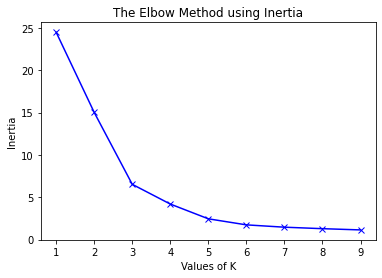

<Figure size 432x288 with 0 Axes>

In [68]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()
plt.savefig('elbow.svg')

In [52]:
from sklearn.decomposition import PCA

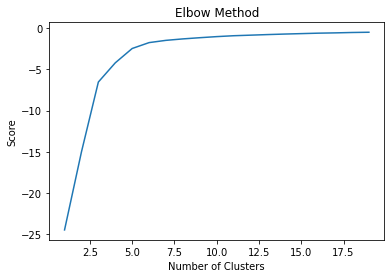

In [53]:
number_clusters = range(1, 20)
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(_tfidf1.toarray())
kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

In [56]:
kmeans = KMeans(n_clusters=5, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

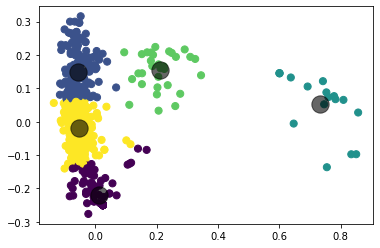

In [67]:
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=50, cmap='viridis')
centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6)
plt.savefig('fiveclusters.svg',transparent=True);

In [64]:
Y_sklearn

array([[ 0.80924496,  0.0654855 ],
       [ 0.06909628, -0.22051989],
       [-0.01517868, -0.13865252],
       ...,
       [ 0.02440435, -0.24979632],
       [ 0.02440435, -0.24979632],
       [ 0.02440435, -0.24979632]])

In [59]:
clustering_model = KMeans(
    n_clusters=5,
    max_iter=600,
    precompute_distances="auto",
    n_jobs=-1
)

labels = clustering_model.fit_predict(_tfidf1)
# print labels

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
/Users/chuckcao/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


In [60]:
X = _tfidf1.todense()

# ----------------------------------------------------------------------------------------------------------------------

reduced_data = PCA(n_components=2).fit_transform(X)
# print reduced_data

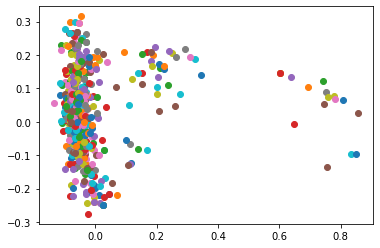

In [63]:
fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    # print instance, index, labels[index]
    pca_comp_1, pca_comp_2 = reduced_data[index]
    ax.scatter(pca_comp_1, pca_comp_2)
plt.show()

# MODELS

In [112]:
nmf1_model = NMF(5,max_iter=20000)
nmf1_topic = nmf1_model.fit_transform(countvect)

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


In [113]:
nmf1_topic_word = pd.DataFrame(nmf1_model.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = cv1.get_feature_names())
nmf1_topic_word

,bottle,boyfriend,camp,cancer,crack,crisis,domain,fbi,friendship,gas,...,population,professor,race,rights,salary,suffering,tank,technique,threat,toxic
component_1,0.104,0.000,0.052,0.000,0.017,0.000,0.000,0.000,0.012,0.188,...,0.029,0.020,0.000,0.012,0.009,10.315,0.004,0.089,0.000,0.016
component_2,0.243,0.000,0.000,0.000,0.521,0.000,0.130,9.374,0.081,0.162,...,0.092,0.113,0.000,0.826,0.000,0.000,0.186,0.759,0.276,0.000
component_3,0.280,0.045,0.000,8.316,0.071,0.000,0.000,0.000,0.023,0.141,...,0.186,0.475,0.182,0.055,0.284,0.000,0.138,0.113,0.000,0.539
component_4,1.008,1.791,2.547,0.000,1.187,0.000,1.605,0.000,0.972,1.017,...,1.155,0.885,1.712,0.980,1.564,0.000,1.119,0.975,1.994,1.428
component_5,0.000,0.000,0.000,0.000,0.042,6.947,0.000,0.000,0.089,0.275,...,0.559,0.259,0.000,0.084,0.000,0.000,0.119,0.046,0.336,0.000


In [114]:
nmf2_model = NMF(5,max_iter=2000)
nmf2_topic = nmf2_model.fit_transform(_tfidf1)

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


In [115]:
nmf2_topic_word = pd.DataFrame(nmf2_model.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = tfidf1.get_feature_names())
nmf2_topic_word

,bottle,boyfriend,camp,cancer,crack,crisis,domain,fbi,friendship,gas,...,population,professor,race,rights,salary,suffering,tank,technique,threat,toxic
component_1,0.251,0.099,0.000,0.000,0.000,0.000,0.690,0.00,0.000,0.000,...,0.000,0.109,0.000,0.315,2.211,0.126,0.000,0.369,0.000,0.017
component_2,0.053,0.000,0.091,0.000,0.038,0.034,0.140,1.74,0.000,0.086,...,0.044,0.000,0.000,0.245,0.000,0.000,0.000,0.284,0.331,0.000
component_3,0.301,0.000,0.437,0.808,0.571,0.552,0.150,0.00,0.000,0.388,...,0.588,0.591,0.525,0.224,0.000,0.487,0.000,0.068,0.308,0.155
component_4,0.196,1.172,0.241,0.000,0.000,0.072,0.005,0.00,1.333,0.092,...,0.000,0.009,0.000,0.034,0.000,0.081,0.000,0.031,0.063,0.765
component_5,0.000,0.064,0.064,0.000,0.018,0.008,0.034,0.00,0.000,0.176,...,0.000,0.004,0.025,0.019,0.000,0.000,1.919,0.444,0.000,0.022


In [51]:
corpus1 = matutils.Sparse2Corpus(countvect)

In [52]:
id2word1 = dict((v, k) for k, v in cv1.vocabulary_.items())

In [22]:
len(id2word1)

16640

In [53]:
lda1 = models.LdaModel(corpus=corpus1, num_topics=10, id2word=id2word1, passes=500,update_every=1)

2021-02-21 18:57:44,008 : INFO : using symmetric alpha at 0.1
2021-02-21 18:57:44,009 : INFO : using symmetric eta at 0.1
2021-02-21 18:57:44,013 : INFO : using serial LDA version on this node
2021-02-21 18:57:44,017 : INFO : running online (multi-pass) LDA training, 10 topics, 500 passes over the supplied corpus of 1000 documents, updating model once every 1000 documents, evaluating perplexity every 1000 documents, iterating 50x with a convergence threshold of 0.001000
2021-02-21 18:57:46,300 : INFO : -7.527 per-word bound, 184.4 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 18:57:46,301 : INFO : PROGRESS: pass 0, at document #1000/1000
2021-02-21 18:57:47,285 : INFO : topic #5 (0.100): 0.007*"giant" + 0.006*"friendship" + 0.006*"english" + 0.005*"cross" + 0.005*"gold" + 0.004*"germany" + 0.004*"clothing" + 0.004*"ai" + 0.004*"executive" + 0.004*"floor"
2021-02-21 18:57:47,286 : INFO : topic #0 (0.100): 0.008*"held" + 0.008*"hide" + 0.00

2021-02-21 18:58:03,228 : INFO : topic #0 (0.100): 0.024*"held" + 0.024*"hide" + 0.019*"hair" + 0.015*"bias" + 0.013*"coffee" + 0.013*"behave" + 0.013*"frame" + 0.011*"function" + 0.010*"birthday" + 0.009*"fbi"
2021-02-21 18:58:03,228 : INFO : topic #7 (0.100): 0.034*"edited" + 0.032*"bother" + 0.028*"dinner" + 0.025*"accept" + 0.023*"double" + 0.023*"acting" + 0.022*"gang" + 0.020*"board" + 0.015*"cycle" + 0.014*"circle"
2021-02-21 18:58:03,230 : INFO : topic diff=0.050153, rho=0.377964
2021-02-21 18:58:05,642 : INFO : -6.024 per-word bound, 65.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 18:58:05,642 : INFO : PROGRESS: pass 6, at document #1000/1000
2021-02-21 18:58:06,670 : INFO : topic #7 (0.100): 0.037*"edited" + 0.035*"bother" + 0.030*"dinner" + 0.027*"accept" + 0.025*"acting" + 0.025*"double" + 0.024*"gang" + 0.022*"board" + 0.015*"cycle" + 0.015*"circle"
2021-02-21 18:58:06,671 : INFO : topic #3 (0.100): 0.016*"chapter" + 0.012

2021-02-21 18:58:21,123 : INFO : topic #5 (0.100): 0.009*"english" + 0.007*"clothing" + 0.007*"crew" + 0.006*"ice" + 0.006*"image" + 0.006*"hollywood" + 0.006*"dr" + 0.005*"desire" + 0.005*"cultural" + 0.005*"conscious"
2021-02-21 18:58:21,124 : INFO : topic #3 (0.100): 0.016*"chapter" + 0.012*"exists" + 0.012*"escape" + 0.011*"cognitive" + 0.011*"exciting" + 0.011*"equal" + 0.010*"file" + 0.010*"buddy" + 0.009*"apart" + 0.009*"frank"
2021-02-21 18:58:21,126 : INFO : topic diff=0.026129, rho=0.277350
2021-02-21 18:58:23,015 : INFO : -5.997 per-word bound, 63.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 18:58:23,016 : INFO : PROGRESS: pass 12, at document #1000/1000
2021-02-21 18:58:24,060 : INFO : topic #4 (0.100): 0.016*"dive" + 0.012*"anger" + 0.011*"concern" + 0.011*"asset" + 0.011*"eating" + 0.011*"develop" + 0.011*"active" + 0.009*"female" + 0.009*"accident" + 0.009*"chain"
2021-02-21 18:58:24,061 : INFO : topic #5 (0.100): 0.009*

2021-02-21 18:58:38,043 : INFO : topic #2 (0.100): 0.025*"forgot" + 0.021*"germany" + 0.019*"hack" + 0.018*"apparently" + 0.016*"claim" + 0.016*"executive" + 0.015*"cross" + 0.015*"gold" + 0.015*"gun" + 0.014*"friendship"
2021-02-21 18:58:38,044 : INFO : topic #9 (0.100): 0.036*"encourage" + 0.017*"drinking" + 0.015*"crisis" + 0.015*"couch" + 0.010*"drunk" + 0.009*"damage" + 0.009*"achieve" + 0.009*"broken" + 0.009*"cousin" + 0.008*"david"
2021-02-21 18:58:38,046 : INFO : topic diff=0.020381, rho=0.229416
2021-02-21 18:58:39,887 : INFO : -5.987 per-word bound, 63.4 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 18:58:39,888 : INFO : PROGRESS: pass 18, at document #1000/1000
2021-02-21 18:58:40,711 : INFO : topic #7 (0.100): 0.047*"edited" + 0.046*"bother" + 0.038*"accept" + 0.035*"acting" + 0.035*"dinner" + 0.032*"double" + 0.032*"gang" + 0.028*"board" + 0.017*"circle" + 0.017*"cycle"
2021-02-21 18:58:40,712 : INFO : topic #8 (0.100): 0.03

2021-02-21 18:58:55,792 : INFO : topic #9 (0.100): 0.035*"encourage" + 0.017*"drinking" + 0.016*"crisis" + 0.015*"couch" + 0.010*"drunk" + 0.010*"damage" + 0.010*"broken" + 0.009*"achieve" + 0.009*"david" + 0.009*"cousin"
2021-02-21 18:58:55,794 : INFO : topic #7 (0.100): 0.048*"edited" + 0.046*"bother" + 0.039*"accept" + 0.036*"acting" + 0.035*"dinner" + 0.033*"double" + 0.033*"gang" + 0.029*"board" + 0.017*"circle" + 0.017*"function"
2021-02-21 18:58:55,796 : INFO : topic diff=0.019849, rho=0.200000
2021-02-21 18:58:57,667 : INFO : -5.981 per-word bound, 63.2 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 18:58:57,668 : INFO : PROGRESS: pass 24, at document #1000/1000
2021-02-21 18:58:58,496 : INFO : topic #5 (0.100): 0.010*"english" + 0.007*"ice" + 0.007*"crew" + 0.007*"image" + 0.006*"dr" + 0.006*"hollywood" + 0.006*"clothing" + 0.006*"cultural" + 0.006*"desire" + 0.006*"gene"
2021-02-21 18:58:58,497 : INFO : topic #7 (0.100): 0.048*"e

2021-02-21 18:59:12,324 : INFO : topic #9 (0.100): 0.035*"encourage" + 0.017*"drinking" + 0.016*"crisis" + 0.015*"couch" + 0.011*"broken" + 0.011*"drunk" + 0.010*"damage" + 0.010*"david" + 0.009*"achieve" + 0.009*"fbi"
2021-02-21 18:59:12,325 : INFO : topic #4 (0.100): 0.018*"dive" + 0.014*"anger" + 0.014*"eating" + 0.014*"asset" + 0.013*"concern" + 0.012*"develop" + 0.011*"active" + 0.011*"chinese" + 0.011*"female" + 0.011*"carry"
2021-02-21 18:59:12,326 : INFO : topic diff=0.020817, rho=0.179605
2021-02-21 18:59:14,174 : INFO : -5.977 per-word bound, 63.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 18:59:14,175 : INFO : PROGRESS: pass 30, at document #1000/1000
2021-02-21 18:59:14,988 : INFO : topic #2 (0.100): 0.028*"forgot" + 0.022*"germany" + 0.020*"hack" + 0.019*"apparently" + 0.017*"executive" + 0.017*"gold" + 0.017*"claim" + 0.016*"gun" + 0.016*"cross" + 0.015*"friendship"
2021-02-21 18:59:14,988 : INFO : topic #1 (0.100): 0.011

2021-02-21 18:59:28,346 : INFO : topic #6 (0.100): 0.089*"document" + 0.065*"acting" + 0.063*"adam" + 0.046*"ad" + 0.040*"friendship" + 0.032*"advanced" + 0.028*"heavy" + 0.026*"gut" + 0.025*"actor" + 0.022*"documentary"
2021-02-21 18:59:28,347 : INFO : topic #0 (0.100): 0.050*"hide" + 0.050*"held" + 0.034*"hair" + 0.031*"bias" + 0.026*"behave" + 0.025*"coffee" + 0.022*"frame" + 0.020*"birthday" + 0.014*"coaching" + 0.013*"gun"
2021-02-21 18:59:28,348 : INFO : topic diff=0.021075, rho=0.164399
2021-02-21 18:59:30,171 : INFO : -5.974 per-word bound, 62.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 18:59:30,171 : INFO : PROGRESS: pass 36, at document #1000/1000
2021-02-21 18:59:31,003 : INFO : topic #8 (0.100): 0.035*"guide" + 0.034*"exchange" + 0.034*"embarrassing" + 0.033*"faster" + 0.031*"factor" + 0.030*"blame" + 0.029*"bringing" + 0.028*"hello" + 0.028*"highlight" + 0.028*"experienced"
2021-02-21 18:59:31,005 : INFO : topic #5 (0.100

2021-02-21 18:59:44,370 : INFO : topic #0 (0.100): 0.053*"hide" + 0.053*"held" + 0.035*"hair" + 0.033*"bias" + 0.027*"behave" + 0.026*"coffee" + 0.022*"frame" + 0.021*"birthday" + 0.014*"coaching" + 0.014*"gun"
2021-02-21 18:59:44,371 : INFO : topic #2 (0.100): 0.029*"forgot" + 0.021*"germany" + 0.021*"hack" + 0.019*"apparently" + 0.018*"executive" + 0.018*"gold" + 0.017*"gun" + 0.017*"claim" + 0.016*"cross" + 0.016*"friendship"
2021-02-21 18:59:44,372 : INFO : topic diff=0.020187, rho=0.152499
2021-02-21 18:59:46,190 : INFO : -5.972 per-word bound, 62.8 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 18:59:46,191 : INFO : PROGRESS: pass 42, at document #1000/1000
2021-02-21 18:59:47,012 : INFO : topic #1 (0.100): 0.012*"doubt" + 0.011*"broke" + 0.010*"blind" + 0.010*"creative" + 0.009*"comfort" + 0.008*"bus" + 0.008*"affect" + 0.008*"awful" + 0.008*"clean" + 0.008*"award"
2021-02-21 18:59:47,013 : INFO : topic #9 (0.100): 0.034*"encourage"

2021-02-21 19:00:00,324 : INFO : topic #1 (0.100): 0.012*"doubt" + 0.011*"broke" + 0.010*"blind" + 0.010*"creative" + 0.009*"comfort" + 0.008*"bus" + 0.008*"affect" + 0.008*"awful" + 0.008*"domain" + 0.008*"award"
2021-02-21 19:00:00,326 : INFO : topic #4 (0.100): 0.019*"dive" + 0.016*"anger" + 0.016*"eating" + 0.015*"asset" + 0.014*"concern" + 0.013*"develop" + 0.012*"chinese" + 0.012*"carry" + 0.011*"female" + 0.011*"balance"
2021-02-21 19:00:00,327 : INFO : topic diff=0.018594, rho=0.142857
2021-02-21 19:00:02,207 : INFO : -5.970 per-word bound, 62.7 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:00:02,208 : INFO : PROGRESS: pass 48, at document #1000/1000
2021-02-21 19:00:03,011 : INFO : topic #8 (0.100): 0.036*"guide" + 0.035*"exchange" + 0.035*"embarrassing" + 0.033*"faster" + 0.033*"blame" + 0.032*"factor" + 0.030*"bringing" + 0.029*"experienced" + 0.029*"hello" + 0.029*"highlight"
2021-02-21 19:00:03,012 : INFO : topic #1 (0.100

2021-02-21 19:00:16,894 : INFO : topic #9 (0.100): 0.033*"encourage" + 0.017*"drinking" + 0.015*"crisis" + 0.014*"couch" + 0.013*"broken" + 0.011*"fbi" + 0.011*"clothing" + 0.010*"drunk" + 0.010*"david" + 0.010*"achieve"
2021-02-21 19:00:16,895 : INFO : topic #1 (0.100): 0.012*"doubt" + 0.011*"broke" + 0.010*"blind" + 0.010*"creative" + 0.009*"comfort" + 0.009*"bus" + 0.008*"domain" + 0.008*"affect" + 0.008*"awful" + 0.008*"inbox"
2021-02-21 19:00:16,897 : INFO : topic diff=0.016783, rho=0.134840
2021-02-21 19:00:18,759 : INFO : -5.969 per-word bound, 62.6 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:00:18,760 : INFO : PROGRESS: pass 54, at document #1000/1000
2021-02-21 19:00:19,571 : INFO : topic #5 (0.100): 0.011*"english" + 0.008*"ice" + 0.008*"image" + 0.008*"confidence" + 0.007*"crew" + 0.007*"bag" + 0.007*"dr" + 0.007*"cultural" + 0.006*"gene" + 0.006*"desire"
2021-02-21 19:00:19,572 : INFO : topic #7 (0.100): 0.048*"edited" + 

2021-02-21 19:00:34,668 : INFO : topic #5 (0.100): 0.011*"english" + 0.008*"ice" + 0.008*"image" + 0.008*"confidence" + 0.007*"crew" + 0.007*"bag" + 0.007*"dr" + 0.007*"cultural" + 0.006*"gene" + 0.006*"desire"
2021-02-21 19:00:34,669 : INFO : topic #2 (0.100): 0.032*"forgot" + 0.020*"hack" + 0.020*"apparently" + 0.019*"executive" + 0.019*"gold" + 0.018*"gun" + 0.017*"claim" + 0.017*"germany" + 0.017*"friendship" + 0.017*"cross"
2021-02-21 19:00:34,671 : INFO : topic diff=0.015125, rho=0.128037
2021-02-21 19:00:36,785 : INFO : -5.967 per-word bound, 62.6 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:00:36,785 : INFO : PROGRESS: pass 60, at document #1000/1000
2021-02-21 19:00:37,688 : INFO : topic #9 (0.100): 0.033*"encourage" + 0.016*"drinking" + 0.015*"crisis" + 0.014*"couch" + 0.013*"broken" + 0.012*"clothing" + 0.012*"fbi" + 0.010*"david" + 0.010*"drunk" + 0.010*"achieve"
2021-02-21 19:00:37,689 : INFO : topic #2 (0.100): 0.032*"fo

2021-02-21 19:00:51,665 : INFO : topic #8 (0.100): 0.036*"guide" + 0.036*"exchange" + 0.036*"embarrassing" + 0.035*"blame" + 0.034*"faster" + 0.033*"factor" + 0.030*"bringing" + 0.030*"experienced" + 0.029*"hello" + 0.029*"highlight"
2021-02-21 19:00:51,665 : INFO : topic #4 (0.100): 0.020*"dive" + 0.016*"anger" + 0.016*"eating" + 0.016*"asset" + 0.015*"concern" + 0.013*"develop" + 0.012*"chinese" + 0.012*"carry" + 0.012*"female" + 0.012*"balance"
2021-02-21 19:00:51,667 : INFO : topic diff=0.013617, rho=0.122169
2021-02-21 19:00:53,467 : INFO : -5.966 per-word bound, 62.5 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:00:53,468 : INFO : PROGRESS: pass 66, at document #1000/1000
2021-02-21 19:00:54,269 : INFO : topic #0 (0.100): 0.061*"hide" + 0.061*"held" + 0.040*"hair" + 0.039*"bias" + 0.031*"behave" + 0.030*"coffee" + 0.024*"frame" + 0.023*"birthday" + 0.015*"gun" + 0.015*"coaching"
2021-02-21 19:00:54,269 : INFO : topic #1 (0.100): 

2021-02-21 19:01:08,274 : INFO : topic #9 (0.100): 0.033*"encourage" + 0.016*"drinking" + 0.015*"crisis" + 0.014*"couch" + 0.013*"broken" + 0.013*"clothing" + 0.012*"fbi" + 0.011*"david" + 0.010*"achieve" + 0.010*"drunk"
2021-02-21 19:01:08,275 : INFO : topic #5 (0.100): 0.011*"english" + 0.008*"confidence" + 0.008*"ice" + 0.008*"image" + 0.007*"crew" + 0.007*"bag" + 0.007*"dr" + 0.007*"cultural" + 0.007*"gene" + 0.006*"conscious"
2021-02-21 19:01:08,277 : INFO : topic diff=0.012305, rho=0.117041
2021-02-21 19:01:10,104 : INFO : -5.965 per-word bound, 62.5 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:01:10,105 : INFO : PROGRESS: pass 72, at document #1000/1000
2021-02-21 19:01:10,906 : INFO : topic #4 (0.100): 0.020*"dive" + 0.017*"anger" + 0.017*"eating" + 0.016*"asset" + 0.015*"concern" + 0.013*"develop" + 0.012*"chinese" + 0.012*"carry" + 0.012*"female" + 0.012*"balance"
2021-02-21 19:01:10,907 : INFO : topic #9 (0.100): 0.033*"enc

2021-02-21 19:01:24,057 : INFO : topic #6 (0.100): 0.084*"document" + 0.064*"acting" + 0.060*"adam" + 0.044*"ad" + 0.035*"friendship" + 0.033*"advanced" + 0.031*"heavy" + 0.029*"gut" + 0.029*"impression" + 0.029*"idiot"
2021-02-21 19:01:24,058 : INFO : topic #1 (0.100): 0.012*"doubt" + 0.011*"broke" + 0.010*"creative" + 0.010*"blind" + 0.009*"comfort" + 0.009*"bus" + 0.009*"domain" + 0.008*"inbox" + 0.008*"award" + 0.008*"affect"
2021-02-21 19:01:24,059 : INFO : topic diff=0.011229, rho=0.112509
2021-02-21 19:01:25,890 : INFO : -5.964 per-word bound, 62.4 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:01:25,891 : INFO : PROGRESS: pass 78, at document #1000/1000
2021-02-21 19:01:26,700 : INFO : topic #6 (0.100): 0.084*"document" + 0.064*"acting" + 0.060*"adam" + 0.044*"ad" + 0.035*"friendship" + 0.033*"advanced" + 0.031*"heavy" + 0.029*"gut" + 0.029*"impression" + 0.029*"idiot"
2021-02-21 19:01:26,701 : INFO : topic #3 (0.100): 0.014*"ch

2021-02-21 19:01:39,858 : INFO : topic #9 (0.100): 0.032*"encourage" + 0.016*"drinking" + 0.015*"crisis" + 0.014*"clothing" + 0.014*"broken" + 0.014*"couch" + 0.013*"fbi" + 0.011*"david" + 0.010*"achieve" + 0.010*"drunk"
2021-02-21 19:01:39,859 : INFO : topic #4 (0.100): 0.021*"dive" + 0.017*"anger" + 0.017*"eating" + 0.017*"asset" + 0.015*"concern" + 0.013*"develop" + 0.013*"chinese" + 0.013*"carry" + 0.012*"female" + 0.012*"balance"
2021-02-21 19:01:39,861 : INFO : topic diff=0.010342, rho=0.108465
2021-02-21 19:01:41,670 : INFO : -5.963 per-word bound, 62.4 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:01:41,671 : INFO : PROGRESS: pass 84, at document #1000/1000
2021-02-21 19:01:42,469 : INFO : topic #0 (0.100): 0.065*"hide" + 0.065*"held" + 0.042*"hair" + 0.041*"bias" + 0.033*"behave" + 0.032*"coffee" + 0.025*"birthday" + 0.025*"frame" + 0.016*"gun" + 0.016*"convenient"
2021-02-21 19:01:42,470 : INFO : topic #2 (0.100): 0.034*"forg

2021-02-21 19:01:55,592 : INFO : topic #5 (0.100): 0.011*"english" + 0.008*"confidence" + 0.008*"ice" + 0.008*"image" + 0.007*"bag" + 0.007*"crew" + 0.007*"dr" + 0.007*"cultural" + 0.007*"gene" + 0.007*"conscious"
2021-02-21 19:01:55,593 : INFO : topic #0 (0.100): 0.065*"hide" + 0.065*"held" + 0.042*"hair" + 0.042*"bias" + 0.033*"behave" + 0.032*"coffee" + 0.025*"frame" + 0.025*"birthday" + 0.016*"debt" + 0.016*"gun"
2021-02-21 19:01:55,595 : INFO : topic diff=0.009604, rho=0.104828
2021-02-21 19:01:57,424 : INFO : -5.963 per-word bound, 62.4 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:01:57,424 : INFO : PROGRESS: pass 90, at document #1000/1000
2021-02-21 19:01:58,220 : INFO : topic #8 (0.100): 0.037*"blame" + 0.037*"exchange" + 0.037*"guide" + 0.036*"embarrassing" + 0.034*"factor" + 0.034*"faster" + 0.031*"bringing" + 0.030*"experienced" + 0.029*"highlight" + 0.029*"hello"
2021-02-21 19:01:58,221 : INFO : topic #5 (0.100): 0.011*"e

2021-02-21 19:02:13,402 : INFO : topic #0 (0.100): 0.066*"hide" + 0.066*"held" + 0.043*"hair" + 0.042*"bias" + 0.033*"behave" + 0.033*"coffee" + 0.025*"frame" + 0.025*"birthday" + 0.018*"debt" + 0.016*"convenient"
2021-02-21 19:02:13,402 : INFO : topic #3 (0.100): 0.014*"chapter" + 0.013*"exciting" + 0.013*"exists" + 0.012*"hoping" + 0.012*"buddy" + 0.010*"cognitive" + 0.010*"boat" + 0.010*"button" + 0.010*"genius" + 0.010*"escape"
2021-02-21 19:02:13,404 : INFO : topic diff=0.008969, rho=0.101535
2021-02-21 19:02:15,294 : INFO : -5.962 per-word bound, 62.3 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:02:15,295 : INFO : PROGRESS: pass 96, at document #1000/1000
2021-02-21 19:02:16,115 : INFO : topic #6 (0.100): 0.082*"document" + 0.064*"acting" + 0.059*"adam" + 0.043*"ad" + 0.034*"advanced" + 0.033*"friendship" + 0.032*"heavy" + 0.031*"impression" + 0.031*"idiot" + 0.031*"individual"
2021-02-21 19:02:16,116 : INFO : topic #3 (0.100): 

2021-02-21 19:02:29,306 : INFO : topic #9 (0.100): 0.032*"encourage" + 0.016*"drinking" + 0.015*"crisis" + 0.014*"clothing" + 0.014*"broken" + 0.013*"couch" + 0.013*"fbi" + 0.011*"david" + 0.011*"achieve" + 0.010*"drunk"
2021-02-21 19:02:29,307 : INFO : topic #0 (0.100): 0.067*"hide" + 0.067*"held" + 0.043*"hair" + 0.043*"bias" + 0.034*"behave" + 0.033*"coffee" + 0.026*"frame" + 0.025*"birthday" + 0.019*"debt" + 0.018*"defense"
2021-02-21 19:02:29,308 : INFO : topic diff=0.008383, rho=0.098533
2021-02-21 19:02:31,130 : INFO : -5.961 per-word bound, 62.3 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:02:31,131 : INFO : PROGRESS: pass 102, at document #1000/1000
2021-02-21 19:02:31,922 : INFO : topic #7 (0.100): 0.044*"edited" + 0.039*"bother" + 0.037*"germany" + 0.037*"accept" + 0.036*"gang" + 0.033*"acting" + 0.030*"dinner" + 0.030*"canada" + 0.029*"double" + 0.028*"giant"
2021-02-21 19:02:31,924 : INFO : topic #8 (0.100): 0.038*"blame"

2021-02-21 19:02:45,079 : INFO : topic #3 (0.100): 0.014*"chapter" + 0.014*"exciting" + 0.013*"exists" + 0.012*"hoping" + 0.012*"buddy" + 0.011*"boat" + 0.010*"genius" + 0.010*"button" + 0.010*"cognitive" + 0.010*"escape"
2021-02-21 19:02:45,080 : INFO : topic #7 (0.100): 0.044*"edited" + 0.038*"bother" + 0.038*"germany" + 0.037*"accept" + 0.035*"gang" + 0.033*"acting" + 0.030*"dinner" + 0.030*"canada" + 0.029*"double" + 0.028*"giant"
2021-02-21 19:02:45,082 : INFO : topic diff=0.007906, rho=0.095783
2021-02-21 19:02:46,898 : INFO : -5.961 per-word bound, 62.3 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:02:46,898 : INFO : PROGRESS: pass 108, at document #1000/1000
2021-02-21 19:02:47,688 : INFO : topic #2 (0.100): 0.036*"forgot" + 0.021*"gold" + 0.020*"friendship" + 0.020*"gun" + 0.020*"executive" + 0.019*"claim" + 0.019*"dah" + 0.018*"cross" + 0.018*"apparently" + 0.018*"hack"
2021-02-21 19:02:47,689 : INFO : topic #1 (0.100): 0.013

2021-02-21 19:03:00,806 : INFO : topic #7 (0.100): 0.044*"edited" + 0.038*"germany" + 0.038*"bother" + 0.036*"accept" + 0.035*"gang" + 0.032*"acting" + 0.030*"canada" + 0.030*"dinner" + 0.029*"giant" + 0.029*"double"
2021-02-21 19:03:00,807 : INFO : topic #3 (0.100): 0.014*"chapter" + 0.014*"exciting" + 0.013*"exists" + 0.012*"hoping" + 0.012*"buddy" + 0.011*"boat" + 0.010*"genius" + 0.010*"button" + 0.010*"cognitive" + 0.010*"escape"
2021-02-21 19:03:00,808 : INFO : topic diff=0.007551, rho=0.093250
2021-02-21 19:03:02,618 : INFO : -5.960 per-word bound, 62.3 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:03:02,619 : INFO : PROGRESS: pass 114, at document #1000/1000
2021-02-21 19:03:03,417 : INFO : topic #2 (0.100): 0.036*"forgot" + 0.021*"gold" + 0.021*"friendship" + 0.020*"gun" + 0.019*"claim" + 0.019*"executive" + 0.019*"dah" + 0.019*"cross" + 0.018*"apparently" + 0.017*"hack"
2021-02-21 19:03:03,417 : INFO : topic #8 (0.100): 0.039

2021-02-21 19:03:17,115 : INFO : topic #8 (0.100): 0.039*"blame" + 0.037*"guide" + 0.037*"exchange" + 0.037*"embarrassing" + 0.035*"factor" + 0.035*"faster" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"highlight" + 0.030*"hello"
2021-02-21 19:03:17,118 : INFO : topic #9 (0.100): 0.031*"encourage" + 0.015*"drinking" + 0.015*"crisis" + 0.014*"clothing" + 0.014*"broken" + 0.014*"fbi" + 0.013*"couch" + 0.011*"achieve" + 0.011*"david" + 0.010*"cousin"
2021-02-21 19:03:17,120 : INFO : topic diff=0.007293, rho=0.090909
2021-02-21 19:03:18,927 : INFO : -5.960 per-word bound, 62.2 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:03:18,927 : INFO : PROGRESS: pass 120, at document #1000/1000
2021-02-21 19:03:19,730 : INFO : topic #3 (0.100): 0.014*"chapter" + 0.014*"exciting" + 0.013*"exists" + 0.012*"hoping" + 0.012*"buddy" + 0.011*"boat" + 0.010*"genius" + 0.010*"button" + 0.010*"cognitive" + 0.010*"escape"
2021-02-21 19:03:19,731 : INFO : to

2021-02-21 19:03:32,917 : INFO : topic #5 (0.100): 0.009*"english" + 0.008*"confidence" + 0.008*"ice" + 0.008*"image" + 0.008*"bag" + 0.007*"crew" + 0.007*"dr" + 0.007*"cultural" + 0.007*"conscious" + 0.007*"differently"
2021-02-21 19:03:32,917 : INFO : topic #2 (0.100): 0.036*"forgot" + 0.021*"friendship" + 0.021*"gold" + 0.020*"gun" + 0.020*"claim" + 0.020*"dah" + 0.019*"executive" + 0.019*"cross" + 0.017*"apparently" + 0.016*"hack"
2021-02-21 19:03:32,919 : INFO : topic diff=0.007071, rho=0.088736
2021-02-21 19:03:34,728 : INFO : -5.959 per-word bound, 62.2 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:03:34,728 : INFO : PROGRESS: pass 126, at document #1000/1000
2021-02-21 19:03:35,528 : INFO : topic #0 (0.100): 0.071*"hide" + 0.071*"held" + 0.046*"bias" + 0.045*"hair" + 0.036*"behave" + 0.035*"coffee" + 0.027*"frame" + 0.026*"birthday" + 0.023*"debt" + 0.022*"defense"
2021-02-21 19:03:35,529 : INFO : topic #7 (0.100): 0.044*"edite

2021-02-21 19:03:49,593 : INFO : topic #3 (0.100): 0.014*"chapter" + 0.014*"exciting" + 0.013*"exists" + 0.012*"hoping" + 0.012*"buddy" + 0.011*"boat" + 0.010*"genius" + 0.010*"button" + 0.010*"cognitive" + 0.010*"escape"
2021-02-21 19:03:49,596 : INFO : topic #4 (0.100): 0.022*"dive" + 0.018*"anger" + 0.018*"eating" + 0.018*"asset" + 0.015*"concern" + 0.013*"carry" + 0.013*"chinese" + 0.013*"female" + 0.013*"develop" + 0.013*"balance"
2021-02-21 19:03:49,597 : INFO : topic diff=0.006833, rho=0.086711
2021-02-21 19:03:51,763 : INFO : -5.959 per-word bound, 62.2 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:03:51,764 : INFO : PROGRESS: pass 132, at document #1000/1000
2021-02-21 19:03:52,551 : INFO : topic #0 (0.100): 0.071*"hide" + 0.071*"held" + 0.046*"bias" + 0.046*"hair" + 0.036*"behave" + 0.035*"coffee" + 0.028*"frame" + 0.027*"birthday" + 0.024*"debt" + 0.022*"defense"
2021-02-21 19:03:52,552 : INFO : topic #8 (0.100): 0.040*"blam

2021-02-21 19:04:05,645 : INFO : topic #6 (0.100): 0.079*"document" + 0.064*"acting" + 0.058*"adam" + 0.042*"ad" + 0.034*"advanced" + 0.033*"impression" + 0.033*"individual" + 0.033*"idiot" + 0.032*"heavy" + 0.031*"gut"
2021-02-21 19:04:05,646 : INFO : topic #0 (0.100): 0.072*"hide" + 0.072*"held" + 0.047*"bias" + 0.046*"hair" + 0.037*"behave" + 0.036*"coffee" + 0.028*"frame" + 0.027*"birthday" + 0.024*"debt" + 0.023*"defense"
2021-02-21 19:04:05,647 : INFO : topic diff=0.006538, rho=0.084819
2021-02-21 19:04:07,487 : INFO : -5.959 per-word bound, 62.2 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:04:07,487 : INFO : PROGRESS: pass 138, at document #1000/1000
2021-02-21 19:04:08,422 : INFO : topic #9 (0.100): 0.031*"encourage" + 0.015*"drinking" + 0.015*"crisis" + 0.014*"clothing" + 0.014*"fbi" + 0.014*"broken" + 0.013*"couch" + 0.011*"achieve" + 0.011*"david" + 0.010*"cousin"
2021-02-21 19:04:08,423 : INFO : topic #4 (0.100): 0.022*"di

2021-02-21 19:04:21,953 : INFO : topic #0 (0.100): 0.073*"hide" + 0.073*"held" + 0.047*"bias" + 0.047*"hair" + 0.037*"behave" + 0.036*"coffee" + 0.028*"frame" + 0.027*"birthday" + 0.025*"debt" + 0.023*"defense"
2021-02-21 19:04:21,953 : INFO : topic #2 (0.100): 0.037*"forgot" + 0.022*"friendship" + 0.022*"gold" + 0.020*"claim" + 0.020*"dah" + 0.020*"gun" + 0.019*"cross" + 0.018*"executive" + 0.016*"feature" + 0.016*"apparently"
2021-02-21 19:04:21,954 : INFO : topic diff=0.006196, rho=0.083045
2021-02-21 19:04:23,773 : INFO : -5.958 per-word bound, 62.2 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:04:23,774 : INFO : PROGRESS: pass 144, at document #1000/1000
2021-02-21 19:04:24,562 : INFO : topic #4 (0.100): 0.022*"dive" + 0.018*"anger" + 0.018*"eating" + 0.018*"asset" + 0.015*"concern" + 0.014*"carry" + 0.013*"female" + 0.013*"chinese" + 0.013*"develop" + 0.013*"balance"
2021-02-21 19:04:24,563 : INFO : topic #9 (0.100): 0.031*"encou

2021-02-21 19:04:37,783 : INFO : topic #7 (0.100): 0.043*"edited" + 0.040*"germany" + 0.037*"bother" + 0.036*"accept" + 0.035*"gang" + 0.031*"acting" + 0.031*"canada" + 0.030*"giant" + 0.029*"dinner" + 0.028*"double"
2021-02-21 19:04:37,785 : INFO : topic #6 (0.100): 0.078*"document" + 0.064*"acting" + 0.057*"adam" + 0.042*"ad" + 0.034*"advanced" + 0.033*"impression" + 0.033*"individual" + 0.033*"idiot" + 0.032*"heavy" + 0.031*"gut"
2021-02-21 19:04:37,786 : INFO : topic diff=0.005846, rho=0.081379
2021-02-21 19:04:39,584 : INFO : -5.958 per-word bound, 62.2 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:04:39,584 : INFO : PROGRESS: pass 150, at document #1000/1000
2021-02-21 19:04:40,374 : INFO : topic #8 (0.100): 0.040*"blame" + 0.037*"guide" + 0.037*"exchange" + 0.037*"embarrassing" + 0.035*"faster" + 0.035*"factor" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"highlight" + 0.030*"hello"
2021-02-21 19:04:40,375 : INFO : topic #0 

2021-02-21 19:04:53,485 : INFO : topic #5 (0.100): 0.008*"image" + 0.008*"ice" + 0.008*"confidence" + 0.008*"english" + 0.008*"bag" + 0.007*"crew" + 0.007*"dr" + 0.007*"cultural" + 0.007*"conscious" + 0.007*"differently"
2021-02-21 19:04:53,486 : INFO : topic #4 (0.100): 0.022*"dive" + 0.018*"anger" + 0.018*"eating" + 0.018*"asset" + 0.015*"concern" + 0.014*"carry" + 0.014*"female" + 0.013*"chinese" + 0.013*"develop" + 0.013*"balance"
2021-02-21 19:04:53,487 : INFO : topic diff=0.005476, rho=0.079809
2021-02-21 19:04:55,285 : INFO : -5.958 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:04:55,286 : INFO : PROGRESS: pass 156, at document #1000/1000
2021-02-21 19:04:56,071 : INFO : topic #6 (0.100): 0.078*"document" + 0.064*"acting" + 0.057*"adam" + 0.041*"ad" + 0.034*"advanced" + 0.034*"impression" + 0.034*"individual" + 0.034*"idiot" + 0.032*"heavy" + 0.031*"gut"
2021-02-21 19:04:56,072 : INFO : topic #5 (0.100): 0.0

2021-02-21 19:05:09,267 : INFO : topic #4 (0.100): 0.022*"dive" + 0.018*"anger" + 0.018*"eating" + 0.018*"asset" + 0.015*"concern" + 0.014*"carry" + 0.014*"female" + 0.014*"chinese" + 0.013*"develop" + 0.013*"balance"
2021-02-21 19:05:09,268 : INFO : topic #9 (0.100): 0.030*"encourage" + 0.015*"crisis" + 0.015*"drinking" + 0.014*"fbi" + 0.014*"clothing" + 0.014*"broken" + 0.013*"couch" + 0.011*"achieve" + 0.010*"david" + 0.010*"cousin"
2021-02-21 19:05:09,269 : INFO : topic diff=0.005146, rho=0.078326
2021-02-21 19:05:11,716 : INFO : -5.957 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:05:11,717 : INFO : PROGRESS: pass 162, at document #1000/1000
2021-02-21 19:05:12,616 : INFO : topic #9 (0.100): 0.030*"encourage" + 0.015*"crisis" + 0.015*"drinking" + 0.014*"fbi" + 0.014*"clothing" + 0.014*"broken" + 0.013*"couch" + 0.011*"achieve" + 0.010*"david" + 0.010*"cousin"
2021-02-21 19:05:12,618 : INFO : topic #0 (0.100): 

2021-02-21 19:05:25,767 : INFO : topic #6 (0.100): 0.077*"document" + 0.064*"acting" + 0.057*"adam" + 0.041*"ad" + 0.035*"advanced" + 0.034*"impression" + 0.034*"individual" + 0.034*"idiot" + 0.032*"heavy" + 0.031*"gut"
2021-02-21 19:05:25,768 : INFO : topic #0 (0.100): 0.075*"hide" + 0.075*"held" + 0.049*"bias" + 0.048*"hair" + 0.038*"behave" + 0.037*"coffee" + 0.029*"frame" + 0.028*"birthday" + 0.026*"debt" + 0.024*"defense"
2021-02-21 19:05:25,769 : INFO : topic diff=0.004847, rho=0.076923
2021-02-21 19:05:27,610 : INFO : -5.957 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:05:27,611 : INFO : PROGRESS: pass 168, at document #1000/1000
2021-02-21 19:05:28,406 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.013*"chapter" + 0.013*"exists" + 0.013*"hoping" + 0.012*"buddy" + 0.011*"boat" + 0.010*"genius" + 0.010*"button" + 0.010*"cognitive" + 0.010*"escape"
2021-02-21 19:05:28,407 : INFO : topic #2 (0.100): 0.038*"fo

2021-02-21 19:05:41,511 : INFO : topic #0 (0.100): 0.076*"hide" + 0.076*"held" + 0.050*"bias" + 0.049*"hair" + 0.039*"behave" + 0.037*"coffee" + 0.029*"frame" + 0.028*"birthday" + 0.026*"debt" + 0.025*"defense"
2021-02-21 19:05:41,512 : INFO : topic #2 (0.100): 0.038*"forgot" + 0.023*"friendship" + 0.022*"gold" + 0.021*"claim" + 0.020*"dah" + 0.020*"gun" + 0.019*"cross" + 0.018*"executive" + 0.017*"feature" + 0.016*"government"
2021-02-21 19:05:41,513 : INFO : topic diff=0.004596, rho=0.075593
2021-02-21 19:05:43,304 : INFO : -5.957 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:05:43,305 : INFO : PROGRESS: pass 174, at document #1000/1000
2021-02-21 19:05:44,116 : INFO : topic #8 (0.100): 0.041*"blame" + 0.037*"guide" + 0.037*"exchange" + 0.037*"embarrassing" + 0.035*"faster" + 0.035*"factor" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"highlight" + 0.030*"hello"
2021-02-21 19:05:44,117 : INFO : topic #7 (0.10

2021-02-21 19:05:57,248 : INFO : topic #1 (0.100): 0.013*"doubt" + 0.012*"broke" + 0.011*"creative" + 0.011*"cycle" + 0.010*"bus" + 0.010*"blind" + 0.010*"comfort" + 0.009*"core" + 0.009*"documentary" + 0.009*"award"
2021-02-21 19:05:57,248 : INFO : topic #2 (0.100): 0.038*"forgot" + 0.024*"friendship" + 0.022*"gold" + 0.021*"claim" + 0.021*"dah" + 0.020*"gun" + 0.019*"cross" + 0.018*"executive" + 0.017*"feature" + 0.017*"english"
2021-02-21 19:05:57,249 : INFO : topic diff=0.004390, rho=0.074329
2021-02-21 19:05:59,061 : INFO : -5.957 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:05:59,062 : INFO : PROGRESS: pass 180, at document #1000/1000
2021-02-21 19:05:59,876 : INFO : topic #9 (0.100): 0.030*"encourage" + 0.015*"crisis" + 0.014*"drinking" + 0.014*"fbi" + 0.014*"clothing" + 0.014*"broken" + 0.013*"couch" + 0.011*"achieve" + 0.010*"david" + 0.010*"cousin"
2021-02-21 19:05:59,877 : INFO : topic #7 (0.100): 0.043

2021-02-21 19:06:14,035 : INFO : topic #2 (0.100): 0.038*"forgot" + 0.024*"friendship" + 0.022*"gold" + 0.021*"claim" + 0.021*"dah" + 0.020*"gun" + 0.019*"cross" + 0.018*"executive" + 0.017*"english" + 0.017*"feature"
2021-02-21 19:06:14,035 : INFO : topic #8 (0.100): 0.042*"blame" + 0.037*"guide" + 0.037*"embarrassing" + 0.037*"exchange" + 0.035*"faster" + 0.035*"factor" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"hello" + 0.030*"highlight"
2021-02-21 19:06:14,037 : INFO : topic diff=0.004193, rho=0.073127
2021-02-21 19:06:15,917 : INFO : -5.957 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:06:15,918 : INFO : PROGRESS: pass 186, at document #1000/1000
2021-02-21 19:06:16,719 : INFO : topic #9 (0.100): 0.030*"encourage" + 0.014*"crisis" + 0.014*"drinking" + 0.014*"fbi" + 0.014*"clothing" + 0.014*"broken" + 0.013*"couch" + 0.011*"achieve" + 0.010*"david" + 0.010*"cousin"
2021-02-21 19:06:16,720 : INFO : topic 

2021-02-21 19:06:29,887 : INFO : topic #0 (0.100): 0.077*"hide" + 0.077*"held" + 0.051*"bias" + 0.050*"hair" + 0.040*"behave" + 0.038*"coffee" + 0.030*"frame" + 0.029*"birthday" + 0.027*"debt" + 0.025*"defense"
2021-02-21 19:06:29,888 : INFO : topic #9 (0.100): 0.030*"encourage" + 0.014*"crisis" + 0.014*"drinking" + 0.014*"fbi" + 0.014*"clothing" + 0.014*"broken" + 0.013*"couch" + 0.011*"achieve" + 0.010*"david" + 0.010*"cousin"
2021-02-21 19:06:29,889 : INFO : topic diff=0.004003, rho=0.071982
2021-02-21 19:06:31,726 : INFO : -5.956 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:06:31,727 : INFO : PROGRESS: pass 192, at document #1000/1000
2021-02-21 19:06:32,518 : INFO : topic #2 (0.100): 0.038*"forgot" + 0.024*"friendship" + 0.022*"gold" + 0.021*"claim" + 0.021*"dah" + 0.020*"gun" + 0.019*"cross" + 0.017*"executive" + 0.017*"english" + 0.017*"feature"
2021-02-21 19:06:32,519 : INFO : topic #5 (0.100): 0.009*"imag

2021-02-21 19:06:45,604 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.018*"asset" + 0.018*"eating" + 0.015*"concern" + 0.014*"female" + 0.014*"carry" + 0.014*"chinese" + 0.013*"balance" + 0.013*"develop"
2021-02-21 19:06:45,605 : INFO : topic #0 (0.100): 0.078*"hide" + 0.078*"held" + 0.052*"bias" + 0.050*"hair" + 0.040*"behave" + 0.039*"coffee" + 0.030*"frame" + 0.029*"birthday" + 0.027*"debt" + 0.025*"defense"
2021-02-21 19:06:45,606 : INFO : topic diff=0.003823, rho=0.070888
2021-02-21 19:06:47,421 : INFO : -5.956 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:06:47,422 : INFO : PROGRESS: pass 198, at document #1000/1000
2021-02-21 19:06:48,215 : INFO : topic #8 (0.100): 0.042*"blame" + 0.037*"guide" + 0.037*"embarrassing" + 0.037*"exchange" + 0.035*"faster" + 0.035*"factor" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"hello" + 0.030*"highlight"
2021-02-21 19:06:48,216 : INFO : topic #1 (0.100):

2021-02-21 19:07:01,264 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.018*"asset" + 0.018*"eating" + 0.015*"concern" + 0.014*"female" + 0.014*"carry" + 0.014*"chinese" + 0.014*"balance" + 0.013*"develop"
2021-02-21 19:07:01,265 : INFO : topic #9 (0.100): 0.029*"encourage" + 0.014*"crisis" + 0.014*"fbi" + 0.014*"drinking" + 0.014*"clothing" + 0.014*"broken" + 0.013*"couch" + 0.011*"achieve" + 0.010*"david" + 0.010*"cousin"
2021-02-21 19:07:01,266 : INFO : topic diff=0.003651, rho=0.069843
2021-02-21 19:07:03,072 : INFO : -5.956 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:07:03,072 : INFO : PROGRESS: pass 204, at document #1000/1000
2021-02-21 19:07:03,845 : INFO : topic #5 (0.100): 0.009*"image" + 0.009*"ice" + 0.008*"confidence" + 0.008*"bag" + 0.008*"crew" + 0.007*"dr" + 0.007*"cultural" + 0.007*"english" + 0.007*"conscious" + 0.007*"differently"
2021-02-21 19:07:03,846 : INFO : topic #8 (0.100): 0

2021-02-21 19:07:16,926 : INFO : topic #9 (0.100): 0.029*"encourage" + 0.014*"crisis" + 0.014*"fbi" + 0.014*"drinking" + 0.014*"clothing" + 0.014*"broken" + 0.013*"couch" + 0.011*"achieve" + 0.010*"david" + 0.010*"cousin"
2021-02-21 19:07:16,927 : INFO : topic #1 (0.100): 0.013*"doubt" + 0.012*"broke" + 0.011*"cycle" + 0.011*"creative" + 0.011*"bus" + 0.010*"blind" + 0.010*"comfort" + 0.010*"core" + 0.009*"documentary" + 0.009*"award"
2021-02-21 19:07:16,928 : INFO : topic diff=0.003477, rho=0.068843
2021-02-21 19:07:18,745 : INFO : -5.956 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:07:18,746 : INFO : PROGRESS: pass 210, at document #1000/1000
2021-02-21 19:07:19,539 : INFO : topic #9 (0.100): 0.029*"encourage" + 0.014*"crisis" + 0.014*"fbi" + 0.014*"drinking" + 0.014*"clothing" + 0.014*"broken" + 0.013*"couch" + 0.011*"achieve" + 0.010*"david" + 0.010*"cousin"
2021-02-21 19:07:19,540 : INFO : topic #2 (0.100): 0

2021-02-21 19:07:33,250 : INFO : topic #9 (0.100): 0.029*"encourage" + 0.014*"crisis" + 0.014*"fbi" + 0.014*"drinking" + 0.014*"clothing" + 0.014*"broken" + 0.013*"couch" + 0.011*"achieve" + 0.010*"david" + 0.010*"cousin"
2021-02-21 19:07:33,251 : INFO : topic #1 (0.100): 0.013*"doubt" + 0.012*"broke" + 0.011*"cycle" + 0.011*"creative" + 0.011*"bus" + 0.010*"blind" + 0.010*"comfort" + 0.010*"core" + 0.009*"documentary" + 0.009*"award"
2021-02-21 19:07:33,251 : INFO : topic diff=0.003305, rho=0.067884
2021-02-21 19:07:35,284 : INFO : -5.956 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:07:35,285 : INFO : PROGRESS: pass 216, at document #1000/1000
2021-02-21 19:07:36,187 : INFO : topic #8 (0.100): 0.042*"blame" + 0.037*"guide" + 0.037*"embarrassing" + 0.036*"exchange" + 0.035*"faster" + 0.035*"factor" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"hello" + 0.030*"highlight"
2021-02-21 19:07:36,188 : INFO : topic #

2021-02-21 19:07:50,560 : INFO : topic #8 (0.100): 0.043*"blame" + 0.037*"embarrassing" + 0.037*"guide" + 0.036*"exchange" + 0.035*"faster" + 0.035*"factor" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"hello" + 0.030*"highlight"
2021-02-21 19:07:50,561 : INFO : topic #9 (0.100): 0.029*"encourage" + 0.014*"crisis" + 0.014*"fbi" + 0.014*"drinking" + 0.014*"broken" + 0.014*"clothing" + 0.012*"couch" + 0.011*"achieve" + 0.010*"david" + 0.010*"cousin"
2021-02-21 19:07:50,563 : INFO : topic diff=0.003139, rho=0.066965
2021-02-21 19:07:52,364 : INFO : -5.956 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:07:52,364 : INFO : PROGRESS: pass 222, at document #1000/1000
2021-02-21 19:07:53,151 : INFO : topic #6 (0.100): 0.073*"document" + 0.062*"acting" + 0.056*"adam" + 0.040*"ad" + 0.036*"impression" + 0.036*"individual" + 0.036*"idiot" + 0.035*"advanced" + 0.032*"heavy" + 0.032*"gut"
2021-02-21 19:07:53,152 : INFO : topi

2021-02-21 19:08:06,293 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.018*"asset" + 0.018*"eating" + 0.015*"concern" + 0.014*"female" + 0.014*"carry" + 0.014*"chinese" + 0.014*"balance" + 0.013*"develop"
2021-02-21 19:08:06,294 : INFO : topic #0 (0.100): 0.080*"held" + 0.080*"hide" + 0.053*"bias" + 0.051*"hair" + 0.041*"behave" + 0.040*"coffee" + 0.031*"frame" + 0.030*"birthday" + 0.028*"debt" + 0.026*"defense"
2021-02-21 19:08:06,295 : INFO : topic diff=0.002986, rho=0.066082
2021-02-21 19:08:08,417 : INFO : -5.956 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:08:08,418 : INFO : PROGRESS: pass 228, at document #1000/1000
2021-02-21 19:08:09,194 : INFO : topic #0 (0.100): 0.080*"held" + 0.080*"hide" + 0.053*"bias" + 0.052*"hair" + 0.041*"behave" + 0.040*"coffee" + 0.031*"frame" + 0.030*"birthday" + 0.028*"debt" + 0.026*"defense"
2021-02-21 19:08:09,195 : INFO : topic #5 (0.100): 0.009*"ice" + 0.009*"i

2021-02-21 19:08:22,835 : INFO : topic #9 (0.100): 0.029*"encourage" + 0.014*"crisis" + 0.014*"fbi" + 0.014*"drinking" + 0.014*"broken" + 0.014*"clothing" + 0.012*"couch" + 0.011*"achieve" + 0.010*"david" + 0.010*"cousin"
2021-02-21 19:08:22,836 : INFO : topic #8 (0.100): 0.043*"blame" + 0.037*"embarrassing" + 0.036*"guide" + 0.036*"exchange" + 0.035*"faster" + 0.035*"factor" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"active" + 0.030*"hello"
2021-02-21 19:08:22,838 : INFO : topic diff=0.002868, rho=0.065233
2021-02-21 19:08:24,668 : INFO : -5.955 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:08:24,669 : INFO : PROGRESS: pass 234, at document #1000/1000
2021-02-21 19:08:25,473 : INFO : topic #0 (0.100): 0.080*"held" + 0.080*"hide" + 0.054*"bias" + 0.052*"hair" + 0.041*"behave" + 0.040*"coffee" + 0.031*"frame" + 0.030*"birthday" + 0.028*"debt" + 0.027*"defense"
2021-02-21 19:08:25,474 : INFO : topic #1 (0.100)

2021-02-21 19:08:38,527 : INFO : topic #9 (0.100): 0.029*"encourage" + 0.014*"crisis" + 0.014*"fbi" + 0.014*"broken" + 0.014*"drinking" + 0.014*"clothing" + 0.012*"couch" + 0.011*"achieve" + 0.010*"david" + 0.009*"cousin"
2021-02-21 19:08:38,529 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.018*"eating" + 0.015*"concern" + 0.014*"female" + 0.014*"carry" + 0.014*"chinese" + 0.014*"balance" + 0.013*"develop"
2021-02-21 19:08:38,530 : INFO : topic diff=0.002759, rho=0.064416
2021-02-21 19:08:40,333 : INFO : -5.955 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:08:40,340 : INFO : PROGRESS: pass 240, at document #1000/1000
2021-02-21 19:08:41,509 : INFO : topic #5 (0.100): 0.009*"ice" + 0.009*"image" + 0.008*"confidence" + 0.008*"bag" + 0.008*"crew" + 0.007*"dr" + 0.007*"cultural" + 0.007*"conscious" + 0.007*"differently" + 0.007*"gene"
2021-02-21 19:08:41,509 : INFO : topic #6 (0.100): 0.07

2021-02-21 19:08:54,837 : INFO : topic #8 (0.100): 0.043*"blame" + 0.036*"embarrassing" + 0.036*"guide" + 0.036*"exchange" + 0.035*"faster" + 0.035*"factor" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"active" + 0.030*"hello"
2021-02-21 19:08:54,837 : INFO : topic #2 (0.100): 0.039*"forgot" + 0.026*"friendship" + 0.023*"gold" + 0.022*"claim" + 0.021*"dah" + 0.019*"gun" + 0.019*"english" + 0.018*"cross" + 0.017*"government" + 0.017*"feature"
2021-02-21 19:08:54,839 : INFO : topic diff=0.002685, rho=0.063628
2021-02-21 19:08:56,639 : INFO : -5.955 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:08:56,639 : INFO : PROGRESS: pass 246, at document #1000/1000
2021-02-21 19:08:57,429 : INFO : topic #2 (0.100): 0.039*"forgot" + 0.026*"friendship" + 0.023*"gold" + 0.022*"claim" + 0.021*"dah" + 0.019*"gun" + 0.019*"english" + 0.018*"cross" + 0.017*"government" + 0.017*"feature"
2021-02-21 19:08:57,430 : INFO : topic #3 (0

2021-02-21 19:09:10,582 : INFO : topic #5 (0.100): 0.009*"ice" + 0.009*"image" + 0.008*"confidence" + 0.008*"bag" + 0.008*"crew" + 0.007*"dr" + 0.007*"cultural" + 0.007*"conscious" + 0.007*"differently" + 0.007*"desire"
2021-02-21 19:09:10,583 : INFO : topic #7 (0.100): 0.042*"edited" + 0.040*"germany" + 0.035*"bother" + 0.035*"accept" + 0.033*"gang" + 0.031*"giant" + 0.031*"canada" + 0.030*"acting" + 0.028*"dinner" + 0.027*"double"
2021-02-21 19:09:10,585 : INFO : topic diff=0.002612, rho=0.062869
2021-02-21 19:09:12,395 : INFO : -5.955 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:09:12,396 : INFO : PROGRESS: pass 252, at document #1000/1000
2021-02-21 19:09:13,190 : INFO : topic #2 (0.100): 0.039*"forgot" + 0.026*"friendship" + 0.023*"gold" + 0.022*"claim" + 0.021*"dah" + 0.019*"gun" + 0.019*"english" + 0.018*"cross" + 0.017*"government" + 0.017*"feature"
2021-02-21 19:09:13,191 : INFO : topic #3 (0.100): 0.014*

2021-02-21 19:09:28,422 : INFO : topic #7 (0.100): 0.042*"edited" + 0.040*"germany" + 0.035*"bother" + 0.035*"accept" + 0.033*"gang" + 0.031*"giant" + 0.031*"canada" + 0.030*"acting" + 0.028*"dinner" + 0.027*"hack"
2021-02-21 19:09:28,423 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.015*"concern" + 0.014*"female" + 0.014*"carry" + 0.014*"chinese" + 0.014*"balance" + 0.013*"develop"
2021-02-21 19:09:28,424 : INFO : topic diff=0.002556, rho=0.062137
2021-02-21 19:09:31,085 : INFO : -5.955 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:09:31,086 : INFO : PROGRESS: pass 258, at document #1000/1000
2021-02-21 19:09:32,224 : INFO : topic #5 (0.100): 0.009*"ice" + 0.009*"image" + 0.008*"confidence" + 0.008*"bag" + 0.008*"crew" + 0.007*"dr" + 0.007*"cultural" + 0.007*"conscious" + 0.007*"differently" + 0.007*"desire"
2021-02-21 19:09:32,226 : INFO : topic #0 (0.100): 0.082*"he

2021-02-21 19:09:47,778 : INFO : topic #6 (0.100): 0.071*"document" + 0.061*"acting" + 0.055*"adam" + 0.039*"ad" + 0.038*"impression" + 0.038*"individual" + 0.038*"idiot" + 0.035*"advanced" + 0.033*"gut" + 0.032*"heavy"
2021-02-21 19:09:47,778 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.013*"chapter" + 0.013*"hoping" + 0.013*"exists" + 0.012*"buddy" + 0.011*"boat" + 0.011*"genius" + 0.011*"button" + 0.010*"hotel" + 0.010*"escape"
2021-02-21 19:09:47,780 : INFO : topic diff=0.002500, rho=0.061430
2021-02-21 19:09:49,580 : INFO : -5.955 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:09:49,581 : INFO : PROGRESS: pass 264, at document #1000/1000
2021-02-21 19:09:50,374 : INFO : topic #7 (0.100): 0.042*"edited" + 0.040*"germany" + 0.035*"bother" + 0.035*"accept" + 0.033*"gang" + 0.031*"giant" + 0.031*"canada" + 0.030*"acting" + 0.028*"dinner" + 0.027*"hack"
2021-02-21 19:09:50,375 : INFO : topic #3 (0.100): 0.014*"ex

2021-02-21 19:10:08,985 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.015*"concern" + 0.015*"female" + 0.014*"carry" + 0.014*"chinese" + 0.014*"balance" + 0.013*"develop"
2021-02-21 19:10:08,987 : INFO : topic #8 (0.100): 0.044*"blame" + 0.036*"embarrassing" + 0.036*"guide" + 0.036*"exchange" + 0.035*"faster" + 0.035*"factor" + 0.031*"bringing" + 0.031*"active" + 0.031*"experienced" + 0.030*"hello"
2021-02-21 19:10:08,989 : INFO : topic diff=0.002446, rho=0.060746
2021-02-21 19:10:12,328 : INFO : -5.955 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:10:12,329 : INFO : PROGRESS: pass 270, at document #1000/1000
2021-02-21 19:10:13,224 : INFO : topic #6 (0.100): 0.071*"document" + 0.061*"acting" + 0.055*"adam" + 0.039*"ad" + 0.038*"impression" + 0.038*"individual" + 0.038*"idiot" + 0.035*"advanced" + 0.033*"gut" + 0.032*"heavy"
2021-02-21 19:10:13,225 : INFO : topic #1 (0

2021-02-21 19:10:32,180 : INFO : topic #8 (0.100): 0.044*"blame" + 0.036*"embarrassing" + 0.036*"guide" + 0.036*"exchange" + 0.035*"faster" + 0.035*"factor" + 0.031*"active" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"hello"
2021-02-21 19:10:32,182 : INFO : topic #6 (0.100): 0.070*"document" + 0.061*"acting" + 0.055*"adam" + 0.039*"ad" + 0.038*"impression" + 0.038*"individual" + 0.038*"idiot" + 0.035*"advanced" + 0.033*"gut" + 0.032*"heavy"
2021-02-21 19:10:32,183 : INFO : topic diff=0.002390, rho=0.060084
2021-02-21 19:10:34,012 : INFO : -5.955 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:10:34,013 : INFO : PROGRESS: pass 276, at document #1000/1000
2021-02-21 19:10:34,791 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.011*"creative" + 0.011*"bus" + 0.010*"blind" + 0.010*"comfort" + 0.010*"core" + 0.010*"documentary" + 0.009*"award"
2021-02-21 19:10:34,792 : INFO : topic #7 (0.

2021-02-21 19:10:47,832 : INFO : topic #0 (0.100): 0.083*"held" + 0.083*"hide" + 0.056*"bias" + 0.053*"hair" + 0.043*"behave" + 0.042*"coffee" + 0.032*"frame" + 0.031*"birthday" + 0.030*"debt" + 0.028*"defense"
2021-02-21 19:10:47,833 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.015*"concern" + 0.015*"female" + 0.014*"carry" + 0.014*"chinese" + 0.014*"balance" + 0.013*"develop"
2021-02-21 19:10:47,833 : INFO : topic diff=0.002324, rho=0.059444
2021-02-21 19:10:49,628 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:10:49,629 : INFO : PROGRESS: pass 282, at document #1000/1000
2021-02-21 19:10:50,397 : INFO : topic #7 (0.100): 0.041*"edited" + 0.040*"germany" + 0.035*"bother" + 0.035*"accept" + 0.033*"gang" + 0.031*"giant" + 0.030*"canada" + 0.029*"acting" + 0.028*"hack" + 0.027*"dinner"
2021-02-21 19:10:50,398 : INFO : topic #6 (0.100): 0.070*"document" +

2021-02-21 19:11:03,418 : INFO : topic #0 (0.100): 0.083*"held" + 0.083*"hide" + 0.056*"bias" + 0.053*"hair" + 0.043*"behave" + 0.042*"coffee" + 0.032*"frame" + 0.031*"birthday" + 0.030*"debt" + 0.028*"defense"
2021-02-21 19:11:03,419 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.011*"creative" + 0.011*"bus" + 0.010*"blind" + 0.010*"comfort" + 0.010*"core" + 0.010*"documentary" + 0.009*"award"
2021-02-21 19:11:03,420 : INFO : topic diff=0.002257, rho=0.058824
2021-02-21 19:11:05,293 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:11:05,294 : INFO : PROGRESS: pass 288, at document #1000/1000
2021-02-21 19:11:06,100 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.015*"concern" + 0.015*"female" + 0.014*"carry" + 0.014*"chinese" + 0.014*"balance" + 0.013*"develop"
2021-02-21 19:11:06,100 : INFO : topic #8 (0.100): 0.045*"blame" + 

2021-02-21 19:11:19,995 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.011*"creative" + 0.011*"bus" + 0.010*"blind" + 0.010*"comfort" + 0.010*"core" + 0.010*"documentary" + 0.009*"award"
2021-02-21 19:11:19,996 : INFO : topic #8 (0.100): 0.045*"blame" + 0.036*"embarrassing" + 0.036*"guide" + 0.036*"exchange" + 0.035*"faster" + 0.035*"factor" + 0.031*"active" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"hello"
2021-02-21 19:11:19,997 : INFO : topic diff=0.002190, rho=0.058222
2021-02-21 19:11:21,799 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:11:21,799 : INFO : PROGRESS: pass 294, at document #1000/1000
2021-02-21 19:11:22,574 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.011*"creative" + 0.011*"bus" + 0.010*"blind" + 0.010*"comfort" + 0.010*"core" + 0.010*"documentary" + 0.009*"award"
2021-02-21 19:11:22,575 : INFO : topic #9 (0.100

2021-02-21 19:11:35,642 : INFO : topic #6 (0.100): 0.069*"document" + 0.060*"acting" + 0.054*"adam" + 0.039*"impression" + 0.039*"individual" + 0.039*"idiot" + 0.039*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:11:35,643 : INFO : topic #7 (0.100): 0.041*"edited" + 0.040*"germany" + 0.035*"bother" + 0.034*"accept" + 0.033*"gang" + 0.031*"giant" + 0.030*"canada" + 0.029*"acting" + 0.028*"hack" + 0.027*"dinner"
2021-02-21 19:11:35,644 : INFO : topic diff=0.002121, rho=0.057639
2021-02-21 19:11:37,464 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:11:37,465 : INFO : PROGRESS: pass 300, at document #1000/1000
2021-02-21 19:11:38,244 : INFO : topic #0 (0.100): 0.083*"hide" + 0.083*"held" + 0.056*"bias" + 0.054*"hair" + 0.043*"behave" + 0.042*"coffee" + 0.033*"frame" + 0.031*"birthday" + 0.030*"debt" + 0.028*"defense"
2021-02-21 19:11:38,245 : INFO : topic #5 (0.100): 0.009*"ice" + 0.

2021-02-21 19:11:51,792 : INFO : topic #8 (0.100): 0.045*"blame" + 0.036*"embarrassing" + 0.036*"guide" + 0.036*"exchange" + 0.035*"faster" + 0.035*"factor" + 0.031*"active" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"hello"
2021-02-21 19:11:51,793 : INFO : topic #9 (0.100): 0.028*"encourage" + 0.014*"fbi" + 0.014*"crisis" + 0.014*"broken" + 0.013*"clothing" + 0.013*"drinking" + 0.012*"couch" + 0.011*"achieve" + 0.010*"david" + 0.009*"cousin"
2021-02-21 19:11:51,794 : INFO : topic diff=0.002059, rho=0.057073
2021-02-21 19:11:53,586 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:11:53,587 : INFO : PROGRESS: pass 306, at document #1000/1000
2021-02-21 19:11:54,361 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.011*"creative" + 0.011*"bus" + 0.010*"blind" + 0.010*"comfort" + 0.010*"core" + 0.010*"documentary" + 0.009*"award"
2021-02-21 19:11:54,361 : INFO : topic #2 (

2021-02-21 19:12:07,736 : INFO : topic #7 (0.100): 0.041*"edited" + 0.039*"germany" + 0.035*"bother" + 0.034*"accept" + 0.033*"gang" + 0.031*"giant" + 0.030*"canada" + 0.029*"acting" + 0.029*"hack" + 0.027*"dinner"
2021-02-21 19:12:07,736 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.011*"creative" + 0.011*"bus" + 0.010*"blind" + 0.010*"comfort" + 0.010*"core" + 0.010*"documentary" + 0.009*"award"
2021-02-21 19:12:07,738 : INFO : topic diff=0.002005, rho=0.056523
2021-02-21 19:12:09,710 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:12:09,711 : INFO : PROGRESS: pass 312, at document #1000/1000
2021-02-21 19:12:10,510 : INFO : topic #7 (0.100): 0.041*"edited" + 0.039*"germany" + 0.035*"bother" + 0.034*"accept" + 0.033*"gang" + 0.031*"giant" + 0.030*"canada" + 0.029*"acting" + 0.029*"hack" + 0.027*"dinner"
2021-02-21 19:12:10,511 : INFO : topic #5 (0.100): 0.009*"ice" + 0

2021-02-21 19:12:24,260 : INFO : topic #7 (0.100): 0.041*"edited" + 0.039*"germany" + 0.035*"bother" + 0.034*"accept" + 0.033*"gang" + 0.031*"giant" + 0.030*"canada" + 0.029*"acting" + 0.029*"hack" + 0.027*"dinner"
2021-02-21 19:12:24,261 : INFO : topic #6 (0.100): 0.068*"document" + 0.060*"acting" + 0.054*"adam" + 0.039*"impression" + 0.039*"individual" + 0.039*"idiot" + 0.038*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:12:24,262 : INFO : topic diff=0.001952, rho=0.055989
2021-02-21 19:12:26,064 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:12:26,065 : INFO : PROGRESS: pass 318, at document #1000/1000
2021-02-21 19:12:26,847 : INFO : topic #9 (0.100): 0.028*"encourage" + 0.014*"fbi" + 0.014*"crisis" + 0.013*"broken" + 0.013*"clothing" + 0.013*"drinking" + 0.012*"couch" + 0.011*"achieve" + 0.010*"david" + 0.009*"cousin"
2021-02-21 19:12:26,848 : INFO : topic #1 (0.100): 0.014

2021-02-21 19:12:39,988 : INFO : topic #5 (0.100): 0.009*"ice" + 0.009*"image" + 0.008*"bag" + 0.008*"confidence" + 0.008*"crew" + 0.008*"dr" + 0.007*"cultural" + 0.007*"conscious" + 0.007*"differently" + 0.007*"dark"
2021-02-21 19:12:39,988 : INFO : topic #8 (0.100): 0.046*"blame" + 0.036*"embarrassing" + 0.036*"guide" + 0.036*"exchange" + 0.035*"faster" + 0.035*"factor" + 0.032*"active" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"hello"
2021-02-21 19:12:39,990 : INFO : topic diff=0.001899, rho=0.055470
2021-02-21 19:12:41,793 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:12:41,795 : INFO : PROGRESS: pass 324, at document #1000/1000
2021-02-21 19:12:42,563 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.013*"chapter" + 0.013*"hoping" + 0.013*"exists" + 0.012*"buddy" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"hotel" + 0.010*"breakfast"
2021-02-21 19:12:42,564 : INFO : topic #0 (

2021-02-21 19:12:56,763 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.011*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.009*"award"
2021-02-21 19:12:56,764 : INFO : topic #6 (0.100): 0.067*"document" + 0.060*"acting" + 0.054*"adam" + 0.040*"idiot" + 0.040*"individual" + 0.040*"impression" + 0.038*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:12:56,765 : INFO : topic diff=0.001842, rho=0.054965
2021-02-21 19:12:58,554 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:12:58,555 : INFO : PROGRESS: pass 330, at document #1000/1000
2021-02-21 19:12:59,325 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.011*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.009*"award"
2021-02-21 19:12:59,326 : INFO : topic #0 (0.100): 0.084*"h

2021-02-21 19:13:12,298 : INFO : topic #5 (0.100): 0.009*"ice" + 0.009*"image" + 0.008*"bag" + 0.008*"confidence" + 0.008*"crew" + 0.008*"dr" + 0.007*"cultural" + 0.007*"conscious" + 0.007*"differently" + 0.007*"dark"
2021-02-21 19:13:12,299 : INFO : topic #0 (0.100): 0.084*"hide" + 0.084*"held" + 0.057*"bias" + 0.054*"hair" + 0.043*"behave" + 0.043*"coffee" + 0.033*"frame" + 0.031*"birthday" + 0.031*"debt" + 0.028*"defense"
2021-02-21 19:13:12,300 : INFO : topic diff=0.001775, rho=0.054473
2021-02-21 19:13:14,085 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:13:14,086 : INFO : PROGRESS: pass 336, at document #1000/1000
2021-02-21 19:13:15,114 : INFO : topic #7 (0.100): 0.041*"edited" + 0.039*"germany" + 0.035*"bother" + 0.034*"accept" + 0.033*"gang" + 0.031*"giant" + 0.030*"canada" + 0.029*"hack" + 0.029*"acting" + 0.027*"dinner"
2021-02-21 19:13:15,115 : INFO : topic #8 (0.100): 0.046*"blame" + 0.

2021-02-21 19:13:28,783 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.013*"chapter" + 0.013*"hoping" + 0.013*"exists" + 0.012*"buddy" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"hotel" + 0.010*"breakfast"
2021-02-21 19:13:28,784 : INFO : topic #6 (0.100): 0.066*"document" + 0.059*"acting" + 0.053*"adam" + 0.040*"idiot" + 0.040*"individual" + 0.040*"impression" + 0.038*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:13:28,785 : INFO : topic diff=0.001702, rho=0.053995
2021-02-21 19:13:30,579 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:13:30,580 : INFO : PROGRESS: pass 342, at document #1000/1000
2021-02-21 19:13:31,347 : INFO : topic #7 (0.100): 0.041*"edited" + 0.039*"germany" + 0.035*"bother" + 0.034*"accept" + 0.033*"gang" + 0.031*"giant" + 0.030*"canada" + 0.029*"hack" + 0.029*"acting" + 0.027*"dinner"
2021-02-21 19:13:31,348 : INFO : topic #4 (0.100): 0.023*

2021-02-21 19:13:44,894 : INFO : topic #5 (0.100): 0.009*"ice" + 0.009*"image" + 0.008*"bag" + 0.008*"confidence" + 0.008*"crew" + 0.008*"dr" + 0.007*"cultural" + 0.007*"conscious" + 0.007*"differently" + 0.007*"dark"
2021-02-21 19:13:44,895 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.013*"chapter" + 0.013*"hoping" + 0.013*"exists" + 0.012*"buddy" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"hotel" + 0.010*"breakfast"
2021-02-21 19:13:44,896 : INFO : topic diff=0.001625, rho=0.053529
2021-02-21 19:13:46,694 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:13:46,695 : INFO : PROGRESS: pass 348, at document #1000/1000
2021-02-21 19:13:47,525 : INFO : topic #5 (0.100): 0.009*"ice" + 0.009*"image" + 0.008*"bag" + 0.008*"confidence" + 0.008*"crew" + 0.008*"dr" + 0.007*"cultural" + 0.007*"conscious" + 0.007*"differently" + 0.007*"dark"
2021-02-21 19:13:47,526 : INFO : topic #2 (0.100): 0.040

2021-02-21 19:14:00,610 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.015*"female" + 0.015*"concern" + 0.015*"carry" + 0.014*"chinese" + 0.014*"balance" + 0.013*"develop"
2021-02-21 19:14:00,611 : INFO : topic #7 (0.100): 0.041*"edited" + 0.039*"germany" + 0.035*"bother" + 0.034*"accept" + 0.032*"gang" + 0.031*"giant" + 0.030*"canada" + 0.030*"hack" + 0.029*"acting" + 0.027*"dinner"
2021-02-21 19:14:00,612 : INFO : topic diff=0.001554, rho=0.053074
2021-02-21 19:14:02,415 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:14:02,416 : INFO : PROGRESS: pass 354, at document #1000/1000
2021-02-21 19:14:03,190 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.011*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"
2021-02-21 19:14:03,191 : INFO : topic #5 (0.100): 0.009*"ice" 

2021-02-21 19:14:16,564 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.015*"female" + 0.015*"concern" + 0.015*"carry" + 0.014*"balance" + 0.014*"chinese" + 0.013*"develop"
2021-02-21 19:14:16,564 : INFO : topic #2 (0.100): 0.041*"forgot" + 0.029*"friendship" + 0.024*"gold" + 0.023*"claim" + 0.022*"dah" + 0.021*"english" + 0.019*"gun" + 0.018*"government" + 0.018*"forth" + 0.017*"feature"
2021-02-21 19:14:16,566 : INFO : topic diff=0.001482, rho=0.052632
2021-02-21 19:14:18,445 : INFO : -5.953 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:14:18,446 : INFO : PROGRESS: pass 360, at document #1000/1000
2021-02-21 19:14:19,221 : INFO : topic #0 (0.100): 0.085*"hide" + 0.085*"held" + 0.058*"bias" + 0.055*"hair" + 0.044*"behave" + 0.043*"coffee" + 0.033*"frame" + 0.032*"birthday" + 0.031*"debt" + 0.029*"defense"
2021-02-21 19:14:19,222 : INFO : topic #9 (0.100): 0.028*"encoura

2021-02-21 19:14:32,093 : INFO : topic #8 (0.100): 0.047*"blame" + 0.036*"embarrassing" + 0.036*"exchange" + 0.036*"guide" + 0.035*"faster" + 0.034*"factor" + 0.032*"active" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"hello"
2021-02-21 19:14:32,094 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.011*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"
2021-02-21 19:14:32,096 : INFO : topic diff=0.001418, rho=0.052200
2021-02-21 19:14:33,880 : INFO : -5.953 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:14:33,880 : INFO : PROGRESS: pass 366, at document #1000/1000
2021-02-21 19:14:34,650 : INFO : topic #7 (0.100): 0.041*"edited" + 0.039*"germany" + 0.035*"bother" + 0.034*"accept" + 0.032*"gang" + 0.031*"giant" + 0.030*"canada" + 0.030*"hack" + 0.029*"acting" + 0.027*"dinner"
2021-02-21 19:14:34,650 : INFO : topic #1 (0.100):

2021-02-21 19:14:47,682 : INFO : topic #2 (0.100): 0.041*"forgot" + 0.029*"friendship" + 0.024*"gold" + 0.023*"claim" + 0.022*"dah" + 0.021*"english" + 0.019*"gun" + 0.018*"government" + 0.018*"forth" + 0.017*"causing"
2021-02-21 19:14:47,682 : INFO : topic #8 (0.100): 0.047*"blame" + 0.036*"embarrassing" + 0.036*"exchange" + 0.036*"guide" + 0.035*"faster" + 0.034*"factor" + 0.032*"active" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"hello"
2021-02-21 19:14:47,684 : INFO : topic diff=0.001361, rho=0.051778
2021-02-21 19:14:49,472 : INFO : -5.953 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:14:49,473 : INFO : PROGRESS: pass 372, at document #1000/1000
2021-02-21 19:14:50,246 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.014*"chapter" + 0.013*"hoping" + 0.013*"exists" + 0.013*"buddy" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"hotel" + 0.010*"breakfast"
2021-02-21 19:14:50,247 : INFO : topic #9 

2021-02-21 19:15:03,065 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.011*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"
2021-02-21 19:15:03,066 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.014*"chapter" + 0.013*"hoping" + 0.013*"exists" + 0.013*"buddy" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"breakfast" + 0.010*"hotel"
2021-02-21 19:15:03,067 : INFO : topic diff=0.001316, rho=0.051367
2021-02-21 19:15:04,906 : INFO : -5.953 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:15:04,907 : INFO : PROGRESS: pass 378, at document #1000/1000
2021-02-21 19:15:05,677 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.014*"chapter" + 0.013*"hoping" + 0.013*"exists" + 0.013*"buddy" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"breakfast" + 0.010*"hotel"
2021-02-21 19:15:05,678 : INFO : topic #6 (0.100): 0.0

2021-02-21 19:15:18,695 : INFO : topic #9 (0.100): 0.028*"encourage" + 0.014*"fbi" + 0.014*"crisis" + 0.013*"broken" + 0.013*"clothing" + 0.013*"drinking" + 0.012*"couch" + 0.011*"achieve" + 0.009*"contract" + 0.009*"convenient"
2021-02-21 19:15:18,696 : INFO : topic #5 (0.100): 0.009*"ice" + 0.009*"image" + 0.008*"bag" + 0.008*"crew" + 0.008*"confidence" + 0.008*"dr" + 0.007*"cultural" + 0.007*"conscious" + 0.007*"differently" + 0.007*"dark"
2021-02-21 19:15:18,697 : INFO : topic diff=0.001273, rho=0.050965
2021-02-21 19:15:20,496 : INFO : -5.953 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:15:20,497 : INFO : PROGRESS: pass 384, at document #1000/1000
2021-02-21 19:15:21,266 : INFO : topic #8 (0.100): 0.047*"blame" + 0.036*"embarrassing" + 0.036*"exchange" + 0.036*"guide" + 0.035*"faster" + 0.034*"factor" + 0.032*"active" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"hello"
2021-02-21 19:15:21,267 : INFO : to

2021-02-21 19:15:34,105 : INFO : topic #6 (0.100): 0.064*"document" + 0.058*"acting" + 0.053*"adam" + 0.041*"idiot" + 0.041*"individual" + 0.041*"impression" + 0.038*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:15:34,105 : INFO : topic #5 (0.100): 0.009*"ice" + 0.009*"image" + 0.008*"bag" + 0.008*"crew" + 0.008*"confidence" + 0.008*"dr" + 0.007*"cultural" + 0.007*"conscious" + 0.007*"differently" + 0.007*"dark"
2021-02-21 19:15:34,107 : INFO : topic diff=0.001237, rho=0.050572
2021-02-21 19:15:36,036 : INFO : -5.953 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:15:36,037 : INFO : PROGRESS: pass 390, at document #1000/1000
2021-02-21 19:15:36,987 : INFO : topic #7 (0.100): 0.041*"edited" + 0.039*"germany" + 0.034*"bother" + 0.034*"accept" + 0.032*"gang" + 0.031*"giant" + 0.030*"hack" + 0.030*"canada" + 0.028*"acting" + 0.026*"dinner"
2021-02-21 19:15:36,988 : INFO : topic #4 (0.100): 0.023*"di

2021-02-21 19:15:50,148 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.015*"female" + 0.015*"carry" + 0.015*"concern" + 0.014*"balance" + 0.014*"chinese" + 0.013*"develop"
2021-02-21 19:15:50,148 : INFO : topic #9 (0.100): 0.028*"encourage" + 0.014*"fbi" + 0.014*"crisis" + 0.013*"broken" + 0.013*"clothing" + 0.013*"drinking" + 0.012*"couch" + 0.011*"achieve" + 0.009*"contract" + 0.009*"convenient"
2021-02-21 19:15:50,149 : INFO : topic diff=0.001207, rho=0.050189
2021-02-21 19:15:51,934 : INFO : -5.953 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:15:51,934 : INFO : PROGRESS: pass 396, at document #1000/1000
2021-02-21 19:15:52,704 : INFO : topic #0 (0.100): 0.085*"held" + 0.085*"hide" + 0.058*"bias" + 0.055*"hair" + 0.044*"coffee" + 0.044*"behave" + 0.034*"frame" + 0.032*"birthday" + 0.031*"debt" + 0.029*"defense"
2021-02-21 19:15:52,705 : INFO : topic #4 (0.100): 0.02

2021-02-21 19:16:05,794 : INFO : topic #0 (0.100): 0.085*"held" + 0.085*"hide" + 0.058*"bias" + 0.055*"hair" + 0.044*"coffee" + 0.044*"behave" + 0.034*"frame" + 0.032*"birthday" + 0.031*"debt" + 0.029*"defense"
2021-02-21 19:16:05,795 : INFO : topic #6 (0.100): 0.063*"document" + 0.058*"acting" + 0.052*"adam" + 0.041*"idiot" + 0.041*"individual" + 0.041*"impression" + 0.038*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:16:05,796 : INFO : topic diff=0.001178, rho=0.049814
2021-02-21 19:16:07,631 : INFO : -5.953 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:16:07,631 : INFO : PROGRESS: pass 402, at document #1000/1000
2021-02-21 19:16:08,405 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.012*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"
2021-02-21 19:16:08,406 : INFO : topic #8 (0.100): 0.047*"blame" 

2021-02-21 19:16:21,597 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.015*"female" + 0.015*"carry" + 0.015*"concern" + 0.014*"balance" + 0.014*"chinese" + 0.013*"develop"
2021-02-21 19:16:21,598 : INFO : topic #5 (0.100): 0.009*"ice" + 0.009*"image" + 0.008*"bag" + 0.008*"crew" + 0.008*"confidence" + 0.008*"dr" + 0.007*"cultural" + 0.007*"conscious" + 0.007*"differently" + 0.007*"dark"
2021-02-21 19:16:21,599 : INFO : topic diff=0.001147, rho=0.049447
2021-02-21 19:16:23,386 : INFO : -5.953 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:16:23,387 : INFO : PROGRESS: pass 408, at document #1000/1000
2021-02-21 19:16:24,148 : INFO : topic #9 (0.100): 0.028*"encourage" + 0.014*"fbi" + 0.014*"crisis" + 0.013*"broken" + 0.013*"clothing" + 0.013*"drinking" + 0.012*"couch" + 0.011*"achieve" + 0.009*"contract" + 0.009*"convenient"
2021-02-21 19:16:24,149 : INFO : topic #5 (0.100

2021-02-21 19:16:37,029 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.014*"chapter" + 0.013*"hoping" + 0.013*"exists" + 0.013*"buddy" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"breakfast" + 0.010*"hotel"
2021-02-21 19:16:37,030 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.012*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"
2021-02-21 19:16:37,032 : INFO : topic diff=0.001120, rho=0.049088
2021-02-21 19:16:38,871 : INFO : -5.953 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:16:38,872 : INFO : PROGRESS: pass 414, at document #1000/1000
2021-02-21 19:16:39,665 : INFO : topic #8 (0.100): 0.048*"blame" + 0.036*"embarrassing" + 0.036*"exchange" + 0.036*"guide" + 0.035*"faster" + 0.034*"factor" + 0.032*"active" + 0.031*"bringing" + 0.030*"experienced" + 0.030*"hello"
2021-02-21 19:16:39,666 : INFO : topic #0 (0

2021-02-21 19:16:52,378 : INFO : topic #6 (0.100): 0.063*"document" + 0.058*"acting" + 0.052*"adam" + 0.041*"idiot" + 0.041*"individual" + 0.041*"impression" + 0.038*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:16:52,379 : INFO : topic #2 (0.100): 0.041*"forgot" + 0.029*"friendship" + 0.024*"gold" + 0.023*"claim" + 0.023*"dah" + 0.021*"english" + 0.019*"gun" + 0.018*"forth" + 0.018*"government" + 0.017*"causing"
2021-02-21 19:16:52,380 : INFO : topic diff=0.001090, rho=0.048737
2021-02-21 19:16:54,165 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:16:54,165 : INFO : PROGRESS: pass 420, at document #1000/1000
2021-02-21 19:16:54,922 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.015*"female" + 0.015*"carry" + 0.015*"concern" + 0.014*"balance" + 0.014*"chinese" + 0.013*"develop"
2021-02-21 19:16:54,923 : INFO : topic #9 (0.100): 0.028

2021-02-21 19:17:07,952 : INFO : topic #6 (0.100): 0.062*"document" + 0.058*"acting" + 0.052*"adam" + 0.042*"idiot" + 0.042*"individual" + 0.042*"impression" + 0.038*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:17:07,952 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.012*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"
2021-02-21 19:17:07,953 : INFO : topic diff=0.001062, rho=0.048393
2021-02-21 19:17:09,833 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:17:09,834 : INFO : PROGRESS: pass 426, at document #1000/1000
2021-02-21 19:17:10,621 : INFO : topic #7 (0.100): 0.041*"edited" + 0.039*"germany" + 0.034*"bother" + 0.034*"accept" + 0.032*"gang" + 0.031*"giant" + 0.031*"hack" + 0.030*"canada" + 0.028*"acting" + 0.026*"dinner"
2021-02-21 19:17:10,623 : INFO : topic #8 (0.100): 0.048*"bla

2021-02-21 19:17:23,397 : INFO : topic #6 (0.100): 0.062*"document" + 0.058*"acting" + 0.052*"adam" + 0.042*"idiot" + 0.042*"individual" + 0.042*"impression" + 0.038*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:17:23,398 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.015*"female" + 0.015*"carry" + 0.015*"concern" + 0.014*"balance" + 0.014*"chinese" + 0.013*"develop"
2021-02-21 19:17:23,399 : INFO : topic diff=0.001036, rho=0.048057
2021-02-21 19:17:25,186 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:17:25,187 : INFO : PROGRESS: pass 432, at document #1000/1000
2021-02-21 19:17:25,952 : INFO : topic #6 (0.100): 0.062*"document" + 0.058*"acting" + 0.052*"adam" + 0.042*"idiot" + 0.042*"individual" + 0.042*"impression" + 0.038*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:17:25,954 : INFO : topic #7 (0.100): 0.04

2021-02-21 19:17:38,905 : INFO : topic #6 (0.100): 0.062*"document" + 0.058*"acting" + 0.052*"adam" + 0.042*"idiot" + 0.042*"individual" + 0.042*"impression" + 0.038*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:17:38,906 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.012*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"
2021-02-21 19:17:38,907 : INFO : topic diff=0.001010, rho=0.047727
2021-02-21 19:17:40,690 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:17:40,691 : INFO : PROGRESS: pass 438, at document #1000/1000
2021-02-21 19:17:41,459 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.016*"female" + 0.015*"carry" + 0.015*"concern" + 0.014*"balance" + 0.014*"chinese" + 0.013*"develop"
2021-02-21 19:17:41,460 : INFO : topic #2 (0.100): 0.041*"

2021-02-21 19:17:54,198 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.014*"chapter" + 0.013*"hoping" + 0.013*"buddy" + 0.013*"exists" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"breakfast" + 0.010*"hotel"
2021-02-21 19:17:54,199 : INFO : topic #7 (0.100): 0.040*"edited" + 0.039*"germany" + 0.034*"bother" + 0.034*"accept" + 0.032*"gang" + 0.031*"giant" + 0.031*"hack" + 0.030*"canada" + 0.028*"acting" + 0.026*"dinner"
2021-02-21 19:17:54,200 : INFO : topic diff=0.000988, rho=0.047405
2021-02-21 19:17:55,967 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:17:55,968 : INFO : PROGRESS: pass 444, at document #1000/1000
2021-02-21 19:17:56,732 : INFO : topic #0 (0.100): 0.086*"held" + 0.086*"hide" + 0.058*"bias" + 0.056*"hair" + 0.044*"coffee" + 0.044*"behave" + 0.034*"frame" + 0.032*"birthday" + 0.032*"debt" + 0.029*"defense"
2021-02-21 19:17:56,733 : INFO : topic #5 (0.100): 0.009*"ice" + 0

2021-02-21 19:18:09,660 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.016*"female" + 0.015*"carry" + 0.015*"concern" + 0.014*"balance" + 0.014*"chinese" + 0.013*"develop"
2021-02-21 19:18:09,661 : INFO : topic #8 (0.100): 0.048*"blame" + 0.036*"embarrassing" + 0.036*"exchange" + 0.036*"guide" + 0.035*"faster" + 0.034*"factor" + 0.032*"active" + 0.031*"bringing" + 0.030*"experienced" + 0.030*"hello"
2021-02-21 19:18:09,662 : INFO : topic diff=0.000967, rho=0.047088
2021-02-21 19:18:11,453 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:18:11,454 : INFO : PROGRESS: pass 450, at document #1000/1000
2021-02-21 19:18:12,212 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.014*"chapter" + 0.013*"hoping" + 0.013*"buddy" + 0.013*"exists" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"breakfast" + 0.010*"hotel"
2021-02-21 19:18:12,213 : INFO : topic #2 (

2021-02-21 19:18:24,988 : INFO : topic #0 (0.100): 0.086*"held" + 0.086*"hide" + 0.059*"bias" + 0.056*"hair" + 0.045*"coffee" + 0.044*"behave" + 0.034*"frame" + 0.032*"birthday" + 0.032*"debt" + 0.029*"defense"
2021-02-21 19:18:24,989 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.012*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"
2021-02-21 19:18:24,990 : INFO : topic diff=0.000949, rho=0.046778
2021-02-21 19:18:26,771 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:18:26,772 : INFO : PROGRESS: pass 456, at document #1000/1000
2021-02-21 19:18:27,541 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.014*"chapter" + 0.013*"hoping" + 0.013*"buddy" + 0.013*"exists" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"breakfast" + 0.010*"hotel"
2021-02-21 19:18:27,542 : INFO : topic #7 (0.100): 0.040*"edited

2021-02-21 19:18:40,473 : INFO : topic #2 (0.100): 0.041*"forgot" + 0.030*"friendship" + 0.025*"gold" + 0.023*"claim" + 0.023*"dah" + 0.021*"english" + 0.019*"gun" + 0.018*"forth" + 0.018*"government" + 0.018*"causing"
2021-02-21 19:18:40,475 : INFO : topic #7 (0.100): 0.040*"edited" + 0.038*"germany" + 0.034*"bother" + 0.034*"accept" + 0.032*"gang" + 0.031*"hack" + 0.031*"giant" + 0.030*"canada" + 0.028*"acting" + 0.026*"dinner"
2021-02-21 19:18:40,476 : INFO : topic diff=0.000934, rho=0.046474
2021-02-21 19:18:42,249 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:18:42,249 : INFO : PROGRESS: pass 462, at document #1000/1000
2021-02-21 19:18:43,016 : INFO : topic #2 (0.100): 0.041*"forgot" + 0.030*"friendship" + 0.025*"gold" + 0.023*"claim" + 0.023*"dah" + 0.021*"english" + 0.019*"gun" + 0.018*"forth" + 0.018*"government" + 0.018*"causing"
2021-02-21 19:18:43,017 : INFO : topic #8 (0.100): 0.048*"bl

2021-02-21 19:18:56,342 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.012*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"
2021-02-21 19:18:56,343 : INFO : topic #8 (0.100): 0.048*"blame" + 0.036*"embarrassing" + 0.036*"exchange" + 0.036*"guide" + 0.035*"faster" + 0.034*"factor" + 0.032*"active" + 0.031*"bringing" + 0.030*"experienced" + 0.030*"hello"
2021-02-21 19:18:56,344 : INFO : topic diff=0.000923, rho=0.046176
2021-02-21 19:18:58,126 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:18:58,127 : INFO : PROGRESS: pass 468, at document #1000/1000
2021-02-21 19:18:58,884 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.016*"female" + 0.015*"carry" + 0.015*"concern" + 0.014*"balance" + 0.014*"chinese" + 0.013*"develop"
2021-02-21 19:18:58,885 : INFO : topic #8 (0.10

2021-02-21 19:19:12,012 : INFO : topic #6 (0.100): 0.060*"document" + 0.057*"acting" + 0.052*"adam" + 0.042*"idiot" + 0.042*"individual" + 0.042*"impression" + 0.037*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:19:12,013 : INFO : topic #9 (0.100): 0.028*"encourage" + 0.014*"fbi" + 0.014*"crisis" + 0.013*"broken" + 0.013*"clothing" + 0.012*"drinking" + 0.012*"couch" + 0.011*"achieve" + 0.010*"contract" + 0.009*"convenient"
2021-02-21 19:19:12,013 : INFO : topic diff=0.000914, rho=0.045883
2021-02-21 19:19:13,778 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:19:13,778 : INFO : PROGRESS: pass 474, at document #1000/1000
2021-02-21 19:19:14,540 : INFO : topic #2 (0.100): 0.042*"forgot" + 0.030*"friendship" + 0.025*"gold" + 0.023*"claim" + 0.023*"dah" + 0.022*"english" + 0.019*"gun" + 0.018*"forth" + 0.018*"government" + 0.018*"causing"
2021-02-21 19:19:14,541 : INFO : topic #5 (0.

2021-02-21 19:19:27,548 : INFO : topic #2 (0.100): 0.042*"forgot" + 0.030*"friendship" + 0.025*"gold" + 0.023*"claim" + 0.023*"dah" + 0.022*"english" + 0.019*"gun" + 0.018*"forth" + 0.018*"government" + 0.018*"causing"
2021-02-21 19:19:27,550 : INFO : topic #6 (0.100): 0.060*"document" + 0.057*"acting" + 0.052*"adam" + 0.042*"idiot" + 0.042*"individual" + 0.042*"impression" + 0.037*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:19:27,551 : INFO : topic diff=0.000910, rho=0.045596
2021-02-21 19:19:29,334 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:19:29,335 : INFO : PROGRESS: pass 480, at document #1000/1000
2021-02-21 19:19:30,115 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.014*"chapter" + 0.013*"hoping" + 0.013*"buddy" + 0.013*"exists" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"breakfast" + 0.010*"hotel"
2021-02-21 19:19:30,116 : INFO : topic #2 (0.100): 0.

2021-02-21 19:19:42,870 : INFO : topic #5 (0.100): 0.009*"ice" + 0.009*"image" + 0.008*"crew" + 0.008*"bag" + 0.008*"confidence" + 0.008*"dr" + 0.007*"conscious" + 0.007*"cultural" + 0.007*"differently" + 0.007*"dark"
2021-02-21 19:19:42,871 : INFO : topic #4 (0.100): 0.023*"dive" + 0.020*"asset" + 0.020*"anger" + 0.019*"eating" + 0.016*"female" + 0.015*"carry" + 0.015*"balance" + 0.015*"concern" + 0.014*"chinese" + 0.013*"develop"
2021-02-21 19:19:42,872 : INFO : topic diff=0.000910, rho=0.045314
2021-02-21 19:19:45,315 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:19:45,316 : INFO : PROGRESS: pass 486, at document #1000/1000
2021-02-21 19:19:46,177 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.014*"chapter" + 0.013*"hoping" + 0.013*"buddy" + 0.013*"exists" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"breakfast" + 0.010*"hotel"
2021-02-21 19:19:46,177 : INFO : topic #5 (0.100): 0.009

2021-02-21 19:20:05,804 : INFO : topic #7 (0.100): 0.040*"edited" + 0.038*"germany" + 0.034*"bother" + 0.034*"accept" + 0.032*"gang" + 0.031*"hack" + 0.031*"giant" + 0.030*"canada" + 0.028*"acting" + 0.026*"dinner"
2021-02-21 19:20:05,805 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.012*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"
2021-02-21 19:20:05,806 : INFO : topic diff=0.000912, rho=0.045038
2021-02-21 19:20:07,819 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:20:07,820 : INFO : PROGRESS: pass 492, at document #1000/1000
2021-02-21 19:20:08,660 : INFO : topic #4 (0.100): 0.023*"dive" + 0.020*"asset" + 0.020*"anger" + 0.019*"eating" + 0.016*"female" + 0.015*"carry" + 0.015*"balance" + 0.014*"concern" + 0.014*"chinese" + 0.012*"develop"
2021-02-21 19:20:08,661 : INFO : topic #0 (0.100): 0.086*"held"

2021-02-21 19:20:22,985 : INFO : topic #0 (0.100): 0.086*"held" + 0.086*"hide" + 0.059*"bias" + 0.056*"hair" + 0.045*"coffee" + 0.044*"behave" + 0.034*"frame" + 0.032*"debt" + 0.032*"birthday" + 0.029*"defense"
2021-02-21 19:20:22,986 : INFO : topic #2 (0.100): 0.042*"forgot" + 0.030*"friendship" + 0.025*"gold" + 0.023*"claim" + 0.023*"dah" + 0.022*"english" + 0.019*"gun" + 0.018*"forth" + 0.018*"government" + 0.018*"causing"
2021-02-21 19:20:22,988 : INFO : topic diff=0.000917, rho=0.044766
2021-02-21 19:20:24,776 : INFO : -5.952 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:20:24,777 : INFO : PROGRESS: pass 498, at document #1000/1000
2021-02-21 19:20:25,564 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.012*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"
2021-02-21 19:20:25,565 : INFO : topic #8 (0.100): 0.048*"blame" +

In [54]:
lda1.print_topics()

2021-02-21 19:20:28,225 : INFO : topic #0 (0.100): 0.086*"hide" + 0.086*"held" + 0.059*"bias" + 0.056*"hair" + 0.045*"coffee" + 0.044*"behave" + 0.034*"frame" + 0.032*"debt" + 0.032*"birthday" + 0.029*"defense"
2021-02-21 19:20:28,228 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.012*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"
2021-02-21 19:20:28,230 : INFO : topic #2 (0.100): 0.042*"forgot" + 0.030*"friendship" + 0.025*"gold" + 0.023*"claim" + 0.023*"dah" + 0.022*"english" + 0.019*"gun" + 0.018*"forth" + 0.018*"government" + 0.018*"causing"
2021-02-21 19:20:28,231 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.014*"chapter" + 0.013*"hoping" + 0.013*"buddy" + 0.013*"exists" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"breakfast" + 0.010*"hotel"
2021-02-21 19:20:28,233 : INFO : topic #4 (0.100): 0.023*"dive" + 0.020*"asset" + 0.020*"anger" + 0.019*"eating" + 0.016*"female" + 

[(0,
  '0.086*"hide" + 0.086*"held" + 0.059*"bias" + 0.056*"hair" + 0.045*"coffee" + 0.044*"behave" + 0.034*"frame" + 0.032*"debt" + 0.032*"birthday" + 0.029*"defense"'),
 (1,
  '0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.012*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"'),
 (2,
  '0.042*"forgot" + 0.030*"friendship" + 0.025*"gold" + 0.023*"claim" + 0.023*"dah" + 0.022*"english" + 0.019*"gun" + 0.018*"forth" + 0.018*"government" + 0.018*"causing"'),
 (3,
  '0.014*"exciting" + 0.014*"chapter" + 0.013*"hoping" + 0.013*"buddy" + 0.013*"exists" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"breakfast" + 0.010*"hotel"'),
 (4,
  '0.023*"dive" + 0.020*"asset" + 0.020*"anger" + 0.019*"eating" + 0.016*"female" + 0.015*"carry" + 0.015*"balance" + 0.015*"chinese" + 0.014*"concern" + 0.012*"develop"'),
 (5,
  '0.009*"ice" + 0.009*"image" + 0.008*"crew" + 0.008*"bag" + 0.008*"confidence" + 0.008*"dr" + 0.007*"consci

In [ ]:
#topic space

In [39]:
corpus2 = matutils.Sparse2Corpus(_tfidf1)

In [40]:
id2word2 = dict((v, k) for k, v in tfidf1.vocabulary_.items())

In [41]:
lda2 = models.LdaModel(corpus=corpus2, num_topics=10, id2word=id2word2, passes=100,update_every=1)

2021-02-21 18:24:08,584 : INFO : using symmetric alpha at 0.1
2021-02-21 18:24:08,586 : INFO : using symmetric eta at 0.1
2021-02-21 18:24:08,588 : INFO : using serial LDA version on this node
2021-02-21 18:24:08,592 : INFO : running online (multi-pass) LDA training, 10 topics, 100 passes over the supplied corpus of 1000 documents, updating model once every 1000 documents, evaluating perplexity every 1000 documents, iterating 50x with a convergence threshold of 0.001000
2021-02-21 18:24:10,878 : INFO : -9.903 per-word bound, 957.7 perplexity estimate based on a held-out corpus of 1000 documents with 6048 words
2021-02-21 18:24:10,879 : INFO : PROGRESS: pass 0, at document #1000/1000
2021-02-21 18:24:11,666 : INFO : topic #2 (0.100): 0.003*"join" + 0.003*"fact" + 0.003*"eventually" + 0.003*"figure" + 0.003*"job" + 0.003*"just" + 0.003*"huge" + 0.003*"giving" + 0.003*"drive" + 0.003*"easy"
2021-02-21 18:24:11,667 : INFO : topic #7 (0.100): 0.003*"feedback" + 0.003*"free" + 0.003*"counsel

2021-02-21 18:24:23,176 : INFO : topic #6 (0.100): 0.003*"just" + 0.003*"join" + 0.003*"easy" + 0.003*"direction" + 0.003*"close" + 0.003*"fall" + 0.003*"judge" + 0.003*"fbi" + 0.003*"job" + 0.003*"eventually"
2021-02-21 18:24:23,177 : INFO : topic diff=0.498241, rho=0.377964
2021-02-21 18:24:24,820 : INFO : -7.063 per-word bound, 133.7 perplexity estimate based on a held-out corpus of 1000 documents with 6048 words
2021-02-21 18:24:24,821 : INFO : PROGRESS: pass 6, at document #1000/1000
2021-02-21 18:24:25,137 : INFO : topic #9 (0.100): 0.001*"easy" + 0.001*"fogarty" + 0.001*"fight" + 0.001*"join" + 0.001*"biggest" + 0.001*"head" + 0.001*"giving" + 0.001*"early" + 0.001*"drink" + 0.001*"insurance"
2021-02-21 18:24:25,139 : INFO : topic #8 (0.100): 0.002*"cool" + 0.001*"impact" + 0.001*"close" + 0.001*"idea" + 0.001*"date" + 0.001*"issue" + 0.001*"audience" + 0.001*"current" + 0.001*"billion" + 0.001*"feedback"
2021-02-21 18:24:25,139 : INFO : topic #6 (0.100): 0.003*"just" + 0.003*"j

2021-02-21 18:24:35,285 : INFO : topic diff=0.090113, rho=0.277350
2021-02-21 18:24:36,942 : INFO : -6.999 per-word bound, 127.9 perplexity estimate based on a held-out corpus of 1000 documents with 6048 words
2021-02-21 18:24:36,942 : INFO : PROGRESS: pass 12, at document #1000/1000
2021-02-21 18:24:37,245 : INFO : topic #1 (0.100): 0.001*"come" + 0.001*"away" + 0.001*"action" + 0.001*"absolutely" + 0.001*"game" + 0.001*"audience" + 0.001*"forward" + 0.001*"called" + 0.001*"just" + 0.001*"finding"
2021-02-21 18:24:37,245 : INFO : topic #3 (0.100): 0.001*"industry" + 0.001*"increase" + 0.001*"ask" + 0.001*"act" + 0.001*"address" + 0.001*"add" + 0.001*"affect" + 0.001*"goal" + 0.001*"advantage" + 0.001*"guy"
2021-02-21 18:24:37,246 : INFO : topic #7 (0.100): 0.001*"history" + 0.001*"agent" + 0.001*"feedback" + 0.001*"close" + 0.001*"free" + 0.001*"counselor" + 0.001*"easier" + 0.001*"glass" + 0.001*"card" + 0.001*"gabriel"
2021-02-21 18:24:37,247 : INFO : topic #2 (0.100): 0.001*"join" 

2021-02-21 18:24:48,540 : INFO : PROGRESS: pass 18, at document #1000/1000
2021-02-21 18:24:48,820 : INFO : topic #1 (0.100): 0.001*"come" + 0.001*"away" + 0.001*"action" + 0.001*"absolutely" + 0.001*"game" + 0.001*"audience" + 0.001*"forward" + 0.001*"called" + 0.001*"just" + 0.001*"finding"
2021-02-21 18:24:48,821 : INFO : topic #9 (0.100): 0.001*"easy" + 0.001*"fogarty" + 0.001*"fight" + 0.001*"join" + 0.001*"biggest" + 0.001*"head" + 0.001*"giving" + 0.001*"early" + 0.001*"drink" + 0.001*"insurance"
2021-02-21 18:24:48,822 : INFO : topic #0 (0.100): 0.001*"just" + 0.001*"coming" + 0.001*"clear" + 0.001*"agree" + 0.001*"direction" + 0.001*"effort" + 0.001*"close" + 0.001*"extra" + 0.001*"com" + 0.001*"join"
2021-02-21 18:24:48,822 : INFO : topic #4 (0.100): 0.001*"extremely" + 0.001*"especially" + 0.001*"feel" + 0.001*"identity" + 0.001*"completely" + 0.001*"father" + 0.001*"kid" + 0.001*"fear" + 0.001*"joke" + 0.001*"keeping"
2021-02-21 18:24:48,823 : INFO : topic #6 (0.100): 0.003

2021-02-21 18:25:00,290 : INFO : topic #8 (0.100): 0.001*"cool" + 0.001*"impact" + 0.001*"close" + 0.001*"idea" + 0.001*"date" + 0.001*"issue" + 0.001*"audience" + 0.001*"current" + 0.001*"billion" + 0.001*"feedback"
2021-02-21 18:25:00,291 : INFO : topic #2 (0.100): 0.001*"join" + 0.001*"fact" + 0.001*"just" + 0.001*"eventually" + 0.001*"drive" + 0.001*"giving" + 0.001*"job" + 0.001*"easy" + 0.001*"china" + 0.001*"dream"
2021-02-21 18:25:00,291 : INFO : topic #0 (0.100): 0.001*"just" + 0.001*"coming" + 0.001*"clear" + 0.001*"agree" + 0.001*"direction" + 0.001*"effort" + 0.001*"close" + 0.001*"extra" + 0.001*"com" + 0.001*"join"
2021-02-21 18:25:00,294 : INFO : topic #5 (0.100): 0.001*"dog" + 0.001*"game" + 0.001*"business" + 0.001*"happy" + 0.001*"exact" + 0.001*"earlier" + 0.001*"girl" + 0.001*"dream" + 0.001*"dead" + 0.001*"fbi"
2021-02-21 18:25:00,297 : INFO : topic #9 (0.100): 0.001*"easy" + 0.001*"fogarty" + 0.001*"fight" + 0.001*"join" + 0.001*"biggest" + 0.001*"head" + 0.001*"g

2021-02-21 18:25:12,455 : INFO : topic #8 (0.100): 0.001*"cool" + 0.001*"impact" + 0.001*"close" + 0.001*"idea" + 0.001*"date" + 0.001*"issue" + 0.001*"audience" + 0.001*"current" + 0.001*"billion" + 0.001*"feedback"
2021-02-21 18:25:12,456 : INFO : topic #9 (0.100): 0.001*"easy" + 0.001*"fogarty" + 0.001*"fight" + 0.001*"join" + 0.001*"biggest" + 0.001*"head" + 0.001*"giving" + 0.001*"early" + 0.001*"drink" + 0.001*"insurance"
2021-02-21 18:25:12,456 : INFO : topic #3 (0.100): 0.001*"industry" + 0.001*"increase" + 0.001*"ask" + 0.001*"act" + 0.001*"address" + 0.001*"add" + 0.001*"affect" + 0.001*"goal" + 0.001*"advantage" + 0.001*"guy"
2021-02-21 18:25:12,457 : INFO : topic #0 (0.100): 0.001*"just" + 0.001*"coming" + 0.001*"clear" + 0.001*"agree" + 0.001*"direction" + 0.001*"effort" + 0.001*"close" + 0.001*"extra" + 0.001*"com" + 0.001*"join"
2021-02-21 18:25:12,460 : INFO : topic diff=0.000616, rho=0.176777
2021-02-21 18:25:14,057 : INFO : -6.998 per-word bound, 127.8 perplexity esti

2021-02-21 18:25:23,977 : INFO : topic #7 (0.100): 0.001*"history" + 0.001*"agent" + 0.001*"feedback" + 0.001*"close" + 0.001*"free" + 0.001*"counselor" + 0.001*"easier" + 0.001*"glass" + 0.001*"card" + 0.001*"gabriel"
2021-02-21 18:25:23,978 : INFO : topic #8 (0.100): 0.001*"cool" + 0.001*"impact" + 0.001*"close" + 0.001*"idea" + 0.001*"date" + 0.001*"issue" + 0.001*"audience" + 0.001*"current" + 0.001*"billion" + 0.001*"feedback"
2021-02-21 18:25:23,978 : INFO : topic #5 (0.100): 0.001*"dog" + 0.001*"game" + 0.001*"business" + 0.001*"happy" + 0.001*"exact" + 0.001*"earlier" + 0.001*"girl" + 0.001*"dream" + 0.001*"dead" + 0.001*"fbi"
2021-02-21 18:25:23,980 : INFO : topic diff=0.000184, rho=0.162221
2021-02-21 18:25:25,601 : INFO : -6.998 per-word bound, 127.8 perplexity estimate based on a held-out corpus of 1000 documents with 6048 words
2021-02-21 18:25:25,602 : INFO : PROGRESS: pass 37, at document #1000/1000
2021-02-21 18:25:25,893 : INFO : topic #3 (0.100): 0.001*"industry" + 0.

2021-02-21 18:25:35,425 : INFO : topic #0 (0.100): 0.001*"just" + 0.001*"coming" + 0.001*"clear" + 0.001*"agree" + 0.001*"direction" + 0.001*"effort" + 0.001*"close" + 0.001*"extra" + 0.001*"com" + 0.001*"join"
2021-02-21 18:25:35,426 : INFO : topic #1 (0.100): 0.001*"come" + 0.001*"away" + 0.001*"action" + 0.001*"absolutely" + 0.001*"game" + 0.001*"audience" + 0.001*"forward" + 0.001*"called" + 0.001*"just" + 0.001*"finding"
2021-02-21 18:25:35,427 : INFO : topic diff=0.000062, rho=0.150756
2021-02-21 18:25:37,065 : INFO : -6.998 per-word bound, 127.8 perplexity estimate based on a held-out corpus of 1000 documents with 6048 words
2021-02-21 18:25:37,066 : INFO : PROGRESS: pass 43, at document #1000/1000
2021-02-21 18:25:37,357 : INFO : topic #1 (0.100): 0.001*"come" + 0.001*"away" + 0.001*"action" + 0.001*"absolutely" + 0.001*"game" + 0.001*"audience" + 0.001*"forward" + 0.001*"called" + 0.001*"just" + 0.001*"finding"
2021-02-21 18:25:37,357 : INFO : topic #5 (0.100): 0.001*"dog" + 0

2021-02-21 18:25:47,003 : INFO : topic #9 (0.100): 0.001*"easy" + 0.001*"fogarty" + 0.001*"fight" + 0.001*"join" + 0.001*"biggest" + 0.001*"head" + 0.001*"giving" + 0.001*"early" + 0.001*"drink" + 0.001*"interesting"
2021-02-21 18:25:47,004 : INFO : topic diff=0.000022, rho=0.141421
2021-02-21 18:25:48,614 : INFO : -6.998 per-word bound, 127.8 perplexity estimate based on a held-out corpus of 1000 documents with 6048 words
2021-02-21 18:25:48,615 : INFO : PROGRESS: pass 49, at document #1000/1000
2021-02-21 18:25:48,897 : INFO : topic #9 (0.100): 0.001*"easy" + 0.001*"fogarty" + 0.001*"fight" + 0.001*"join" + 0.001*"biggest" + 0.001*"head" + 0.001*"giving" + 0.001*"drink" + 0.001*"early" + 0.001*"interesting"
2021-02-21 18:25:48,897 : INFO : topic #4 (0.100): 0.001*"extremely" + 0.001*"especially" + 0.001*"feel" + 0.001*"identity" + 0.001*"completely" + 0.001*"father" + 0.001*"kid" + 0.001*"fear" + 0.001*"joke" + 0.001*"keeping"
2021-02-21 18:25:48,898 : INFO : topic #0 (0.100): 0.001*

2021-02-21 18:25:58,798 : INFO : topic diff=0.000009, rho=0.133631
2021-02-21 18:26:00,435 : INFO : -6.998 per-word bound, 127.8 perplexity estimate based on a held-out corpus of 1000 documents with 6048 words
2021-02-21 18:26:00,436 : INFO : PROGRESS: pass 55, at document #1000/1000
2021-02-21 18:26:00,720 : INFO : topic #3 (0.100): 0.001*"industry" + 0.001*"increase" + 0.001*"ask" + 0.001*"act" + 0.001*"address" + 0.001*"add" + 0.001*"affect" + 0.001*"goal" + 0.001*"advantage" + 0.001*"guy"
2021-02-21 18:26:00,720 : INFO : topic #6 (0.100): 0.003*"just" + 0.003*"join" + 0.003*"direction" + 0.003*"easy" + 0.003*"close" + 0.003*"fbi" + 0.003*"fall" + 0.003*"job" + 0.003*"judge" + 0.003*"eventually"
2021-02-21 18:26:00,721 : INFO : topic #5 (0.100): 0.001*"dog" + 0.001*"game" + 0.001*"business" + 0.001*"happy" + 0.001*"earlier" + 0.001*"exact" + 0.001*"girl" + 0.001*"dream" + 0.001*"easy" + 0.001*"dead"
2021-02-21 18:26:00,722 : INFO : topic #1 (0.100): 0.001*"come" + 0.001*"away" + 0.0

2021-02-21 18:26:12,794 : INFO : -6.998 per-word bound, 127.8 perplexity estimate based on a held-out corpus of 1000 documents with 6048 words
2021-02-21 18:26:12,795 : INFO : PROGRESS: pass 61, at document #1000/1000
2021-02-21 18:26:13,085 : INFO : topic #7 (0.100): 0.001*"history" + 0.001*"agent" + 0.001*"feedback" + 0.001*"close" + 0.001*"free" + 0.001*"counselor" + 0.001*"card" + 0.001*"gabriel" + 0.001*"glass" + 0.001*"easier"
2021-02-21 18:26:13,086 : INFO : topic #1 (0.100): 0.001*"come" + 0.001*"away" + 0.001*"game" + 0.001*"absolutely" + 0.001*"action" + 0.001*"audience" + 0.001*"called" + 0.001*"forward" + 0.001*"finding" + 0.001*"built"
2021-02-21 18:26:13,087 : INFO : topic #9 (0.100): 0.001*"easy" + 0.001*"fogarty" + 0.001*"fight" + 0.001*"join" + 0.001*"biggest" + 0.001*"early" + 0.001*"giving" + 0.001*"head" + 0.001*"drink" + 0.001*"interesting"
2021-02-21 18:26:13,087 : INFO : topic #3 (0.100): 0.001*"industry" + 0.001*"increase" + 0.001*"ask" + 0.001*"act" + 0.001*"ad

2021-02-21 18:26:24,423 : INFO : PROGRESS: pass 67, at document #1000/1000
2021-02-21 18:26:24,712 : INFO : topic #2 (0.100): 0.001*"join" + 0.001*"fact" + 0.001*"eventually" + 0.001*"just" + 0.001*"drive" + 0.001*"giving" + 0.001*"completely" + 0.001*"easy" + 0.001*"dream" + 0.001*"china"
2021-02-21 18:26:24,713 : INFO : topic #7 (0.100): 0.001*"history" + 0.001*"agent" + 0.001*"feedback" + 0.001*"close" + 0.001*"glass" + 0.001*"easier" + 0.001*"free" + 0.001*"card" + 0.001*"counselor" + 0.001*"gabriel"
2021-02-21 18:26:24,714 : INFO : topic #6 (0.100): 0.003*"just" + 0.003*"join" + 0.003*"direction" + 0.003*"easy" + 0.003*"close" + 0.003*"fbi" + 0.003*"fall" + 0.003*"job" + 0.003*"judge" + 0.003*"eventually"
2021-02-21 18:26:24,715 : INFO : topic #3 (0.100): 0.001*"increase" + 0.001*"industry" + 0.001*"ask" + 0.001*"act" + 0.001*"address" + 0.001*"add" + 0.001*"affect" + 0.001*"goal" + 0.001*"guy" + 0.001*"advantage"
2021-02-21 18:26:24,716 : INFO : topic #0 (0.100): 0.001*"agree" + 

2021-02-21 18:26:36,192 : INFO : topic #5 (0.100): 0.001*"earlier" + 0.001*"exact" + 0.001*"dog" + 0.001*"dream" + 0.001*"dead" + 0.001*"happy" + 0.001*"felt" + 0.001*"girl" + 0.001*"game" + 0.001*"business"
2021-02-21 18:26:36,193 : INFO : topic #6 (0.100): 0.003*"just" + 0.003*"join" + 0.003*"direction" + 0.003*"easy" + 0.003*"close" + 0.003*"fbi" + 0.003*"fall" + 0.003*"job" + 0.003*"judge" + 0.003*"eventually"
2021-02-21 18:26:36,194 : INFO : topic #9 (0.100): 0.001*"fogarty" + 0.001*"easy" + 0.001*"fight" + 0.001*"environment" + 0.001*"changed" + 0.001*"influence" + 0.001*"build" + 0.001*"incredible" + 0.001*"giving" + 0.001*"friday"
2021-02-21 18:26:36,194 : INFO : topic #7 (0.100): 0.001*"history" + 0.001*"agent" + 0.001*"close" + 0.001*"feedback" + 0.001*"counselor" + 0.001*"gabriel" + 0.001*"free" + 0.001*"glass" + 0.001*"easier" + 0.001*"card"
2021-02-21 18:26:36,196 : INFO : topic #8 (0.100): 0.001*"cool" + 0.001*"impact" + 0.001*"close" + 0.001*"idea" + 0.001*"feedback" + 0

2021-02-21 18:26:47,959 : INFO : topic #4 (0.100): 0.001*"extremely" + 0.001*"especially" + 0.001*"identity" + 0.001*"completely" + 0.001*"feel" + 0.001*"father" + 0.001*"kid" + 0.001*"fear" + 0.001*"fall" + 0.001*"felt"
2021-02-21 18:26:47,959 : INFO : topic #1 (0.100): 0.001*"game" + 0.001*"away" + 0.001*"audience" + 0.001*"called" + 0.001*"come" + 0.001*"just" + 0.001*"forward" + 0.001*"action" + 0.001*"absolutely" + 0.001*"effect"
2021-02-21 18:26:47,960 : INFO : topic #6 (0.100): 0.003*"just" + 0.003*"join" + 0.003*"direction" + 0.003*"easy" + 0.003*"close" + 0.003*"fbi" + 0.003*"fall" + 0.003*"job" + 0.003*"judge" + 0.003*"eventually"
2021-02-21 18:26:47,964 : INFO : topic #7 (0.100): 0.001*"agent" + 0.001*"history" + 0.001*"counselor" + 0.001*"close" + 0.001*"dangerous" + 0.001*"eating" + 0.001*"com" + 0.001*"check" + 0.001*"clear" + 0.001*"game"
2021-02-21 18:26:47,965 : INFO : topic diff=0.000000, rho=0.111111
2021-02-21 18:26:49,552 : INFO : -6.998 per-word bound, 127.8 perpl

2021-02-21 18:26:59,371 : INFO : topic #5 (0.100): 0.001*"dog" + 0.001*"game" + 0.001*"financial" + 0.001*"field" + 0.001*"fight" + 0.001*"figure" + 0.001*"finally" + 0.001*"felt" + 0.001*"fit" + 0.001*"fix"
2021-02-21 18:26:59,372 : INFO : topic #3 (0.100): 0.001*"industry" + 0.001*"increase" + 0.001*"ask" + 0.001*"act" + 0.001*"affect" + 0.001*"add" + 0.001*"address" + 0.001*"goal" + 0.001*"human" + 0.001*"ability"
2021-02-21 18:26:59,372 : INFO : topic #0 (0.100): 0.001*"direction" + 0.001*"eventually" + 0.001*"friendly" + 0.001*"fbi" + 0.001*"america" + 0.001*"close" + 0.001*"future" + 0.001*"environment" + 0.001*"audience" + 0.001*"agree"
2021-02-21 18:26:59,373 : INFO : topic diff=0.000000, rho=0.107211
2021-02-21 18:27:01,027 : INFO : -6.998 per-word bound, 127.8 perplexity estimate based on a held-out corpus of 1000 documents with 6048 words
2021-02-21 18:27:01,028 : INFO : PROGRESS: pass 86, at document #1000/1000
2021-02-21 18:27:01,329 : INFO : topic #8 (0.100): 0.001*"cool"

2021-02-21 18:27:10,984 : INFO : topic #8 (0.100): 0.001*"dead" + 0.001*"hostgator" + 0.001*"hire" + 0.001*"challenge" + 0.001*"data" + 0.001*"date" + 0.001*"home" + 0.001*"fair" + 0.001*"higher" + 0.001*"away"
2021-02-21 18:27:10,984 : INFO : topic #0 (0.100): 0.001*"fight" + 0.001*"figure" + 0.001*"feel" + 0.001*"feeling" + 0.001*"felt" + 0.001*"field" + 0.001*"fee" + 0.001*"fine" + 0.001*"financial" + 0.001*"fear"
2021-02-21 18:27:10,986 : INFO : topic diff=0.000000, rho=0.103695
2021-02-21 18:27:12,622 : INFO : -6.998 per-word bound, 127.8 perplexity estimate based on a held-out corpus of 1000 documents with 6048 words
2021-02-21 18:27:12,622 : INFO : PROGRESS: pass 92, at document #1000/1000
2021-02-21 18:27:12,909 : INFO : topic #9 (0.100): 0.001*"exact" + 0.001*"essentially" + 0.001*"fair" + 0.001*"fact" + 0.001*"extremely" + 0.001*"extra" + 0.001*"explain" + 0.001*"excuse" + 0.001*"fan" + 0.001*"eventually"
2021-02-21 18:27:12,911 : INFO : topic #4 (0.100): 0.001*"grew" + 0.001

2021-02-21 18:27:22,453 : INFO : topic #1 (0.100): 0.001*"fast" + 0.001*"enjoyed" + 0.001*"exercise" + 0.001*"excited" + 0.001*"exact" + 0.001*"everybody" + 0.001*"eventually" + 0.001*"et" + 0.001*"essentially" + 0.001*"especially"
2021-02-21 18:27:22,457 : INFO : topic diff=0.000000, rho=0.100504
2021-02-21 18:27:24,060 : INFO : -6.998 per-word bound, 127.8 perplexity estimate based on a held-out corpus of 1000 documents with 6048 words
2021-02-21 18:27:24,061 : INFO : PROGRESS: pass 98, at document #1000/1000
2021-02-21 18:27:24,346 : INFO : topic #3 (0.100): 0.001*"industry" + 0.001*"increase" + 0.001*"ask" + 0.001*"add" + 0.001*"affect" + 0.001*"advantage" + 0.001*"address" + 0.001*"human" + 0.001*"act" + 0.001*"goal"
2021-02-21 18:27:24,347 : INFO : topic #0 (0.100): 0.001*"fine" + 0.001*"firm" + 0.001*"figure" + 0.001*"finally" + 0.001*"financial" + 0.001*"finding" + 0.001*"field" + 0.001*"fogarty" + 0.001*"fix" + 0.001*"feeling"
2021-02-21 18:27:24,348 : INFO : topic #4 (0.100):

In [42]:
lda2.print_topics()

2021-02-21 18:27:26,345 : INFO : topic #0 (0.100): 0.001*"fine" + 0.001*"firm" + 0.001*"figure" + 0.001*"finally" + 0.001*"financial" + 0.001*"finding" + 0.001*"field" + 0.001*"fogarty" + 0.001*"fix" + 0.001*"feeling"
2021-02-21 18:27:26,347 : INFO : topic #1 (0.100): 0.001*"fine" + 0.001*"firm" + 0.001*"figure" + 0.001*"finally" + 0.001*"financial" + 0.001*"finding" + 0.001*"field" + 0.001*"fogarty" + 0.001*"fix" + 0.001*"feeling"
2021-02-21 18:27:26,349 : INFO : topic #2 (0.100): 0.001*"father" + 0.001*"fear" + 0.001*"fan" + 0.001*"fascinating" + 0.001*"grew" + 0.001*"family" + 0.001*"fbi" + 0.001*"feel" + 0.001*"feedback" + 0.001*"fall"
2021-02-21 18:27:26,352 : INFO : topic #3 (0.100): 0.001*"industry" + 0.001*"increase" + 0.001*"ask" + 0.001*"add" + 0.001*"act" + 0.001*"affect" + 0.001*"address" + 0.001*"financial" + 0.001*"fit" + 0.001*"finding"
2021-02-21 18:27:26,354 : INFO : topic #4 (0.100): 0.001*"fine" + 0.001*"firm" + 0.001*"figure" + 0.001*"finally" + 0.001*"financial" + 

[(0,
  '0.001*"fine" + 0.001*"firm" + 0.001*"figure" + 0.001*"finally" + 0.001*"financial" + 0.001*"finding" + 0.001*"field" + 0.001*"fogarty" + 0.001*"fix" + 0.001*"feeling"'),
 (1,
  '0.001*"fine" + 0.001*"firm" + 0.001*"figure" + 0.001*"finally" + 0.001*"financial" + 0.001*"finding" + 0.001*"field" + 0.001*"fogarty" + 0.001*"fix" + 0.001*"feeling"'),
 (2,
  '0.001*"father" + 0.001*"fear" + 0.001*"fan" + 0.001*"fascinating" + 0.001*"grew" + 0.001*"family" + 0.001*"fbi" + 0.001*"feel" + 0.001*"feedback" + 0.001*"fall"'),
 (3,
  '0.001*"industry" + 0.001*"increase" + 0.001*"ask" + 0.001*"add" + 0.001*"act" + 0.001*"affect" + 0.001*"address" + 0.001*"financial" + 0.001*"fit" + 0.001*"finding"'),
 (4,
  '0.001*"fine" + 0.001*"firm" + 0.001*"figure" + 0.001*"finally" + 0.001*"financial" + 0.001*"finding" + 0.001*"field" + 0.001*"fogarty" + 0.001*"fix" + 0.001*"feeling"'),
 (5,
  '0.001*"fine" + 0.001*"firm" + 0.001*"figure" + 0.001*"finally" + 0.001*"financial" + 0.001*"finding" + 0.001*"

In [ ]:
#topic space

In [15]:
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    text = str(text)
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [34]:
data_nouns_adj = pd.DataFrame(df['lemmatized'].apply(nouns_adj))
data_nouns_adj

,lemmatized
0,Jordan Harbinger Welcome Feedback Friday host ...
1,show Jordan Harbinger Jordan Harbinger Show st...
2,podcast Microsoft Teams more way more way team...
3,Jordan Harbinger Show whole approach thing hel...
4,Jordan Harbinger Welcome Feedback Friday host ...
...,...
536,nan
537,nan
538,nan
539,nan


In [47]:
cvna = CountVectorizer(stop_words='english', strip_accents='unicode',max_df=.30,min_df=20,ngram_range=(1,2),max_features=2000)
data_cvna = cvna.fit_transform(data_nouns_adj.lemmatized)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_nouns_adj.index
data_dtmna

,absolute,abuse,abusive,academic,accent,accident,accountability,accounting,accurate,act,...,york city,york times,young people,youtube video,yup,zero,ziprecruiter,ziprecruiter com,zone,zoom
0,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,3,0
2,1,1,0,1,2,0,0,0,2,0,...,0,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
538,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
539,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

In [49]:
lda = models.LdaModel(corpus=corpusna, id2word=id2wordna, num_topics=20, passes=500)
lda.print_topics()

2021-02-22 19:28:01,203 : INFO : using symmetric alpha at 0.05
2021-02-22 19:28:01,214 : INFO : using symmetric eta at 0.05
2021-02-22 19:28:01,218 : INFO : using serial LDA version on this node
2021-02-22 19:28:01,227 : INFO : running online (multi-pass) LDA training, 20 topics, 500 passes over the supplied corpus of 541 documents, updating model once every 541 documents, evaluating perplexity every 541 documents, iterating 50x with a convergence threshold of 0.001000
2021-02-22 19:28:04,226 : INFO : -8.427 per-word bound, 344.2 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:28:04,227 : INFO : PROGRESS: pass 0, at document #541/541
2021-02-22 19:28:05,005 : INFO : topic #19 (0.050): 0.004*"bias" + 0.004*"intelligence" + 0.004*"meaning" + 0.002*"ve" + 0.002*"ziprecruiter" + 0.002*"military" + 0.002*"scientist" + 0.002*"david" + 0.002*"self help" + 0.002*"president"
2021-02-22 19:28:05,006 : INFO : topic #7 (0.050): 0.004*"song" + 0.003*"

2021-02-22 19:28:21,114 : INFO : topic #5 (0.050): 0.018*"negotiation" + 0.010*"ship" + 0.006*"steve" + 0.005*"jobs" + 0.005*"steve jobs" + 0.005*"threat" + 0.005*"military" + 0.005*"ice" + 0.004*"hostage" + 0.004*"leadership"
2021-02-22 19:28:21,115 : INFO : topic #14 (0.050): 0.021*"scam" + 0.013*"cult" + 0.011*"sex" + 0.008*"jealousy" + 0.007*"mate" + 0.007*"victim" + 0.006*"guru" + 0.006*"jealous" + 0.006*"scheme" + 0.005*"psychology"
2021-02-22 19:28:21,115 : INFO : topic #16 (0.050): 0.008*"church" + 0.007*"al" + 0.006*"mountain" + 0.005*"camp" + 0.005*"al qaeda" + 0.004*"qaeda" + 0.004*"religious" + 0.004*"muslim" + 0.004*"english" + 0.004*"gun"
2021-02-22 19:28:21,116 : INFO : topic diff=0.212729, rho=0.377964
2021-02-22 19:28:23,374 : INFO : -7.434 per-word bound, 172.9 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:28:23,374 : INFO : PROGRESS: pass 6, at document #541/541
2021-02-22 19:28:24,274 : INFO : topic #6 (0.050): 0.017

2021-02-22 19:28:39,135 : INFO : topic #13 (0.050): 0.092*"gabriel" + 0.090*"mizrahi" + 0.089*"gabriel mizrahi" + 0.015*"cousin" + 0.014*"harbinger yeah" + 0.011*"right jordan" + 0.010*"ai" + 0.009*"uncle" + 0.009*"gun" + 0.009*"mizrahi jordan"
2021-02-22 19:28:39,136 : INFO : topic #7 (0.050): 0.008*"argument" + 0.006*"conspiracy" + 0.005*"hair" + 0.004*"bias" + 0.004*"model" + 0.004*"song" + 0.003*"technique" + 0.003*"designcrowd" + 0.003*"ad" + 0.003*"reading"
2021-02-22 19:28:39,137 : INFO : topic #2 (0.050): 0.021*"mortgage" + 0.013*"rocket" + 0.011*"rocket mortgage" + 0.009*"desk" + 0.008*"ve" + 0.007*"narcissist" + 0.006*"uncertainty" + 0.006*"loans" + 0.006*"quicken loans" + 0.006*"quicken"
2021-02-22 19:28:39,138 : INFO : topic #12 (0.050): 0.004*"girlfriend" + 0.004*"dah" + 0.004*"jordan jason" + 0.004*"loan" + 0.004*"friday right" + 0.003*"friday jordanharbinger" + 0.003*"mortgage" + 0.003*"debt" + 0.003*"sister" + 0.003*"hi jordan"
2021-02-22 19:28:39,140 : INFO : topic dif

2021-02-22 19:28:54,114 : INFO : topic diff=0.297052, rho=0.235702
2021-02-22 19:28:56,394 : INFO : -7.336 per-word bound, 161.5 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:28:56,395 : INFO : PROGRESS: pass 17, at document #541/541
2021-02-22 19:28:57,125 : INFO : topic #13 (0.050): 0.114*"gabriel" + 0.111*"mizrahi" + 0.109*"gabriel mizrahi" + 0.017*"harbinger yeah" + 0.016*"cousin" + 0.012*"right jordan" + 0.010*"mizrahi jordan" + 0.010*"gun" + 0.010*"uncle" + 0.008*"plane"
2021-02-22 19:28:57,126 : INFO : topic #4 (0.050): 0.028*"imposter" + 0.026*"syndrome" + 0.024*"matthew" + 0.023*"imposter syndrome" + 0.019*"chemical" + 0.016*"cancer" + 0.014*"scientist" + 0.011*"david" + 0.010*"prize" + 0.010*"harbinger yeah"
2021-02-22 19:28:57,127 : INFO : topic #14 (0.050): 0.032*"cult" + 0.029*"scam" + 0.020*"sex" + 0.011*"jealousy" + 0.010*"mate" + 0.009*"victim" + 0.009*"guru" + 0.008*"jealous" + 0.008*"scheme" + 0.008*"status"
2021-02-22

2021-02-22 19:29:12,029 : INFO : topic #14 (0.050): 0.034*"cult" + 0.030*"scam" + 0.022*"sex" + 0.012*"jealousy" + 0.011*"mate" + 0.010*"victim" + 0.009*"guru" + 0.008*"jealous" + 0.008*"scheme" + 0.008*"status"
2021-02-22 19:29:12,031 : INFO : topic diff=0.208336, rho=0.204124
2021-02-22 19:29:14,363 : INFO : -7.317 per-word bound, 159.4 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:29:14,364 : INFO : PROGRESS: pass 23, at document #541/541
2021-02-22 19:29:15,120 : INFO : topic #19 (0.050): 0.012*"bias" + 0.009*"meaning" + 0.007*"motivation" + 0.006*"happiness" + 0.005*"assumption" + 0.005*"intelligence" + 0.004*"model" + 0.004*"machine" + 0.004*"task" + 0.004*"experiment"
2021-02-22 19:29:15,121 : INFO : topic #10 (0.050): 0.019*"progressive" + 0.013*"auto" + 0.011*"virus" + 0.009*"netsuite" + 0.009*"pandemic" + 0.006*"trauma" + 0.006*"mask" + 0.006*"zoom" + 0.005*"covid" + 0.005*"coronavirus"
2021-02-22 19:29:15,122 : INFO : topic #

2021-02-22 19:29:30,315 : INFO : topic #11 (0.050): 0.063*"north" + 0.056*"korea" + 0.050*"north korea" + 0.033*"patent" + 0.027*"poker" + 0.025*"pill" + 0.020*"korean" + 0.017*"china" + 0.017*"birth" + 0.010*"hormone"
2021-02-22 19:29:30,317 : INFO : topic #19 (0.050): 0.012*"bias" + 0.009*"meaning" + 0.007*"motivation" + 0.006*"happiness" + 0.005*"assumption" + 0.004*"intelligence" + 0.004*"model" + 0.004*"task" + 0.004*"machine" + 0.004*"experiment"
2021-02-22 19:29:30,317 : INFO : topic diff=0.145760, rho=0.182574
2021-02-22 19:29:32,536 : INFO : -7.305 per-word bound, 158.1 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:29:32,537 : INFO : PROGRESS: pass 29, at document #541/541
2021-02-22 19:29:33,312 : INFO : topic #19 (0.050): 0.012*"bias" + 0.009*"meaning" + 0.007*"motivation" + 0.006*"happiness" + 0.005*"assumption" + 0.004*"intelligence" + 0.004*"model" + 0.004*"task" + 0.004*"machine" + 0.004*"experiment"
2021-02-22 19:29:33,3

2021-02-22 19:29:49,124 : INFO : topic #14 (0.050): 0.037*"cult" + 0.032*"scam" + 0.025*"sex" + 0.012*"mate" + 0.012*"jealousy" + 0.011*"victim" + 0.010*"guru" + 0.009*"sock" + 0.009*"jealous" + 0.009*"scheme"
2021-02-22 19:29:49,127 : INFO : topic #1 (0.050): 0.007*"sand" + 0.007*"ziprecruiter" + 0.005*"writer" + 0.005*"vulnerability" + 0.004*"courses" + 0.003*"great courses" + 0.003*"adam" + 0.003*"plus" + 0.003*"discipline" + 0.003*"courses plus"
2021-02-22 19:29:49,129 : INFO : topic #15 (0.050): 0.019*"ve" + 0.010*"ll" + 0.007*"scott" + 0.006*"larry" + 0.006*"jail" + 0.006*"criminal" + 0.005*"cop" + 0.005*"fbi" + 0.005*"agent" + 0.005*"ink"
2021-02-22 19:29:49,131 : INFO : topic diff=0.107556, rho=0.166667
2021-02-22 19:29:51,375 : INFO : -7.296 per-word bound, 157.2 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:29:51,375 : INFO : PROGRESS: pass 35, at document #541/541
2021-02-22 19:29:52,099 : INFO : topic #1 (0.050): 0.007*"sand

2021-02-22 19:30:11,343 : INFO : topic #19 (0.050): 0.012*"bias" + 0.009*"meaning" + 0.007*"motivation" + 0.006*"happiness" + 0.005*"assumption" + 0.004*"intelligence" + 0.004*"model" + 0.004*"task" + 0.004*"experiment" + 0.004*"machine"
2021-02-22 19:30:11,344 : INFO : topic #17 (0.050): 0.084*"china" + 0.053*"chinese" + 0.032*"ramit" + 0.027*"sethi" + 0.027*"ramit sethi" + 0.023*"hong" + 0.023*"hong kong" + 0.023*"kong" + 0.014*"communist" + 0.014*"communist party"
2021-02-22 19:30:11,345 : INFO : topic #11 (0.050): 0.067*"north" + 0.060*"korea" + 0.053*"north korea" + 0.035*"patent" + 0.029*"poker" + 0.026*"pill" + 0.021*"korean" + 0.019*"china" + 0.018*"birth" + 0.011*"dennis"
2021-02-22 19:30:11,346 : INFO : topic #18 (0.050): 0.026*"disease" + 0.018*"kevin" + 0.015*"china" + 0.014*"gene" + 0.014*"vaccine" + 0.014*"ai" + 0.014*"alzheimer" + 0.013*"scientist" + 0.011*"cell" + 0.010*"patient"
2021-02-22 19:30:11,348 : INFO : topic diff=0.083090, rho=0.154303
2021-02-22 19:30:13,710 

2021-02-22 19:30:29,355 : INFO : -7.285 per-word bound, 156.0 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:30:29,356 : INFO : PROGRESS: pass 46, at document #541/541
2021-02-22 19:30:30,113 : INFO : topic #13 (0.050): 0.149*"gabriel" + 0.142*"mizrahi" + 0.140*"gabriel mizrahi" + 0.022*"harbinger yeah" + 0.013*"cousin" + 0.013*"right jordan" + 0.013*"mizrahi jordan" + 0.009*"uncle" + 0.008*"yeah jordan" + 0.008*"gun"
2021-02-22 19:30:30,114 : INFO : topic #16 (0.050): 0.013*"al" + 0.010*"church" + 0.010*"mountain" + 0.009*"al qaeda" + 0.009*"qaeda" + 0.008*"camp" + 0.007*"jungle" + 0.007*"muslim" + 0.006*"religious" + 0.006*"isis"
2021-02-22 19:30:30,115 : INFO : topic #5 (0.050): 0.024*"negotiation" + 0.016*"ship" + 0.011*"steve" + 0.009*"jobs" + 0.009*"steve jobs" + 0.008*"leadership" + 0.007*"military" + 0.006*"hostage" + 0.006*"ice" + 0.006*"character"
2021-02-22 19:30:30,118 : INFO : topic #0 (0.050): 0.023*"gabriel" + 0.023*"gabe"

2021-02-22 19:30:45,149 : INFO : topic #9 (0.050): 0.046*"steve" + 0.045*"psychopath" + 0.025*"thomas" + 0.024*"harbinger yeah" + 0.018*"comedy" + 0.014*"kobe" + 0.013*"bryant" + 0.011*"dave" + 0.010*"yeah jordan" + 0.010*"harbinger right"
2021-02-22 19:30:45,151 : INFO : topic diff=0.056510, rho=0.137361
2021-02-22 19:30:47,411 : INFO : -7.281 per-word bound, 155.5 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:30:47,411 : INFO : PROGRESS: pass 52, at document #541/541
2021-02-22 19:30:48,132 : INFO : topic #11 (0.050): 0.070*"north" + 0.062*"korea" + 0.054*"north korea" + 0.036*"patent" + 0.030*"poker" + 0.027*"pill" + 0.022*"korean" + 0.019*"china" + 0.018*"birth" + 0.012*"dennis"
2021-02-22 19:30:48,133 : INFO : topic #17 (0.050): 0.094*"china" + 0.059*"chinese" + 0.032*"ramit" + 0.027*"sethi" + 0.027*"ramit sethi" + 0.023*"hong kong" + 0.023*"hong" + 0.023*"kong" + 0.015*"communist" + 0.015*"communist party"
2021-02-22 19:30:48,133 

2021-02-22 19:31:02,946 : INFO : topic #13 (0.050): 0.153*"gabriel" + 0.145*"mizrahi" + 0.143*"gabriel mizrahi" + 0.022*"harbinger yeah" + 0.013*"mizrahi jordan" + 0.013*"right jordan" + 0.012*"cousin" + 0.009*"uncle" + 0.008*"yeah jordan" + 0.007*"gun"
2021-02-22 19:31:02,947 : INFO : topic #1 (0.050): 0.007*"ziprecruiter" + 0.007*"sand" + 0.005*"writer" + 0.005*"vulnerability" + 0.004*"pair" + 0.004*"jean" + 0.004*"courses" + 0.004*"discipline" + 0.004*"wrangler" + 0.004*"adam"
2021-02-22 19:31:02,950 : INFO : topic diff=0.047589, rho=0.130189
2021-02-22 19:31:05,433 : INFO : -7.277 per-word bound, 155.1 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:31:05,434 : INFO : PROGRESS: pass 58, at document #541/541
2021-02-22 19:31:06,163 : INFO : topic #6 (0.050): 0.021*"russia" + 0.015*"russian" + 0.012*"intelligence" + 0.011*"president" + 0.011*"cia" + 0.011*"election" + 0.008*"operation" + 0.008*"putin" + 0.008*"military" + 0.008*"soviet"

2021-02-22 19:31:21,273 : INFO : topic #13 (0.050): 0.154*"gabriel" + 0.146*"mizrahi" + 0.144*"gabriel mizrahi" + 0.022*"harbinger yeah" + 0.013*"mizrahi jordan" + 0.013*"right jordan" + 0.012*"cousin" + 0.009*"uncle" + 0.008*"yeah jordan" + 0.007*"cop"
2021-02-22 19:31:21,275 : INFO : topic #5 (0.050): 0.025*"negotiation" + 0.016*"ship" + 0.011*"steve" + 0.010*"jobs" + 0.010*"steve jobs" + 0.009*"leadership" + 0.008*"military" + 0.006*"hostage" + 0.006*"ice" + 0.006*"ceo"
2021-02-22 19:31:21,277 : INFO : topic #14 (0.050): 0.039*"cult" + 0.033*"scam" + 0.029*"sex" + 0.014*"sock" + 0.013*"mate" + 0.012*"victim" + 0.012*"jealousy" + 0.011*"guru" + 0.009*"jealous" + 0.009*"status"
2021-02-22 19:31:21,278 : INFO : topic diff=0.040798, rho=0.124035
2021-02-22 19:31:23,461 : INFO : -7.274 per-word bound, 154.8 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:31:23,462 : INFO : PROGRESS: pass 64, at document #541/541
2021-02-22 19:31:24,227 : IN

2021-02-22 19:31:39,033 : INFO : topic #7 (0.050): 0.009*"argument" + 0.007*"designcrowd" + 0.006*"hair" + 0.005*"designer" + 0.005*"ego" + 0.005*"conspiracy" + 0.004*"ad" + 0.004*"bias" + 0.004*"blah" + 0.004*"reading"
2021-02-22 19:31:39,033 : INFO : topic #14 (0.050): 0.039*"cult" + 0.033*"scam" + 0.029*"sex" + 0.014*"sock" + 0.013*"mate" + 0.013*"victim" + 0.012*"jealousy" + 0.011*"guru" + 0.009*"jealous" + 0.009*"status"
2021-02-22 19:31:39,034 : INFO : topic #0 (0.050): 0.024*"gabe" + 0.021*"gabriel" + 0.014*"mizrahi" + 0.012*"gabriel mizrahi" + 0.008*"boundary" + 0.006*"sister" + 0.006*"meaningful" + 0.005*"colleague" + 0.005*"conflict" + 0.004*"covid"
2021-02-22 19:31:39,035 : INFO : topic #8 (0.050): 0.055*"painting" + 0.038*"brian" + 0.022*"pakistan" + 0.021*"artist" + 0.017*"awareness" + 0.016*"self awareness" + 0.016*"self aware" + 0.015*"machine" + 0.012*"guard" + 0.010*"museum"
2021-02-22 19:31:39,036 : INFO : topic diff=0.035413, rho=0.118678
2021-02-22 19:31:41,292 : IN

2021-02-22 19:31:56,485 : INFO : PROGRESS: pass 75, at document #541/541
2021-02-22 19:31:57,270 : INFO : topic #7 (0.050): 0.009*"argument" + 0.007*"designcrowd" + 0.006*"hair" + 0.005*"designer" + 0.005*"ego" + 0.005*"conspiracy" + 0.004*"ad" + 0.004*"bias" + 0.004*"blah" + 0.004*"reading"
2021-02-22 19:31:57,272 : INFO : topic #12 (0.050): 0.005*"girlfriend" + 0.004*"dah" + 0.004*"jordan jason" + 0.004*"loan" + 0.004*"friday right" + 0.004*"debt" + 0.004*"sister" + 0.004*"friday jordanharbinger" + 0.003*"husband" + 0.003*"hi jordan"
2021-02-22 19:31:57,273 : INFO : topic #6 (0.050): 0.021*"russia" + 0.015*"russian" + 0.013*"intelligence" + 0.012*"president" + 0.011*"election" + 0.011*"cia" + 0.008*"operation" + 0.008*"putin" + 0.008*"military" + 0.008*"soviet"
2021-02-22 19:31:57,276 : INFO : topic #18 (0.050): 0.028*"disease" + 0.019*"kevin" + 0.017*"vaccine" + 0.016*"gene" + 0.014*"scientist" + 0.014*"ai" + 0.014*"alzheimer" + 0.013*"virus" + 0.012*"cell" + 0.011*"patient"
2021-02

2021-02-22 19:32:12,356 : INFO : topic diff=0.028156, rho=0.110432
2021-02-22 19:32:14,576 : INFO : -7.268 per-word bound, 154.1 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:32:14,577 : INFO : PROGRESS: pass 81, at document #541/541
2021-02-22 19:32:15,354 : INFO : topic #9 (0.050): 0.050*"steve" + 0.048*"psychopath" + 0.027*"thomas" + 0.025*"harbinger yeah" + 0.017*"comedy" + 0.015*"kobe" + 0.014*"bryant" + 0.012*"dave" + 0.011*"yeah jordan" + 0.010*"harbinger right"
2021-02-22 19:32:15,355 : INFO : topic #4 (0.050): 0.038*"imposter" + 0.037*"syndrome" + 0.031*"imposter syndrome" + 0.028*"matthew" + 0.024*"cancer" + 0.023*"chemical" + 0.017*"david" + 0.016*"scientist" + 0.013*"prize" + 0.011*"harbinger yeah"
2021-02-22 19:32:15,356 : INFO : topic #1 (0.050): 0.007*"ziprecruiter" + 0.007*"sand" + 0.005*"writer" + 0.005*"vulnerability" + 0.004*"jean" + 0.004*"wrangler" + 0.004*"pair" + 0.004*"discipline" + 0.004*"adam" + 0.004*"courses"

2021-02-22 19:32:30,150 : INFO : topic #10 (0.050): 0.016*"progressive" + 0.011*"netsuite" + 0.011*"auto" + 0.007*"sponsor visit" + 0.007*"pandemic" + 0.006*"zoom" + 0.006*"manscaped" + 0.006*"discount sponsor" + 0.006*"course newsletter" + 0.005*"way guest"
2021-02-22 19:32:30,151 : INFO : topic #0 (0.050): 0.024*"gabe" + 0.020*"gabriel" + 0.013*"mizrahi" + 0.011*"gabriel mizrahi" + 0.008*"boundary" + 0.006*"sister" + 0.006*"meaningful" + 0.005*"colleague" + 0.005*"conflict" + 0.005*"covid"
2021-02-22 19:32:30,152 : INFO : topic diff=0.025173, rho=0.106600
2021-02-22 19:32:32,362 : INFO : -7.266 per-word bound, 153.9 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:32:32,363 : INFO : PROGRESS: pass 87, at document #541/541
2021-02-22 19:32:33,082 : INFO : topic #9 (0.050): 0.050*"steve" + 0.049*"psychopath" + 0.027*"thomas" + 0.026*"harbinger yeah" + 0.017*"comedy" + 0.016*"kobe" + 0.014*"bryant" + 0.012*"dave" + 0.011*"yeah jordan" + 0.0

2021-02-22 19:32:47,820 : INFO : topic #5 (0.050): 0.025*"negotiation" + 0.017*"ship" + 0.012*"steve" + 0.010*"leadership" + 0.010*"jobs" + 0.010*"steve jobs" + 0.008*"military" + 0.006*"hostage" + 0.006*"ceo" + 0.006*"ice"
2021-02-22 19:32:47,820 : INFO : topic #2 (0.050): 0.038*"mortgage" + 0.022*"rocket" + 0.019*"rocket mortgage" + 0.014*"quicken" + 0.014*"loans" + 0.014*"quicken loans" + 0.012*"ve" + 0.010*"desk" + 0.009*"ll" + 0.009*"lender"
2021-02-22 19:32:47,821 : INFO : topic #19 (0.050): 0.012*"bias" + 0.008*"meaning" + 0.007*"motivation" + 0.006*"happiness" + 0.005*"assumption" + 0.004*"model" + 0.004*"intelligence" + 0.004*"principle" + 0.004*"identity" + 0.004*"experiment"
2021-02-22 19:32:47,822 : INFO : topic #7 (0.050): 0.009*"argument" + 0.008*"designcrowd" + 0.006*"hair" + 0.006*"designer" + 0.005*"ego" + 0.005*"conspiracy" + 0.005*"ad" + 0.004*"bias" + 0.004*"blah" + 0.004*"reading"
2021-02-22 19:32:47,824 : INFO : topic diff=0.022657, rho=0.103142
2021-02-22 19:32:5

2021-02-22 19:33:05,002 : INFO : -7.263 per-word bound, 153.6 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:33:05,003 : INFO : PROGRESS: pass 98, at document #541/541
2021-02-22 19:33:05,723 : INFO : topic #5 (0.050): 0.025*"negotiation" + 0.017*"ship" + 0.012*"steve" + 0.011*"leadership" + 0.010*"jobs" + 0.010*"steve jobs" + 0.008*"military" + 0.007*"hostage" + 0.006*"ceo" + 0.006*"ice"
2021-02-22 19:33:05,725 : INFO : topic #1 (0.050): 0.007*"ziprecruiter" + 0.006*"sand" + 0.005*"writer" + 0.005*"vulnerability" + 0.005*"jean" + 0.004*"wrangler" + 0.004*"pair" + 0.004*"discipline" + 0.004*"adam" + 0.004*"courses"
2021-02-22 19:33:05,725 : INFO : topic #9 (0.050): 0.051*"steve" + 0.049*"psychopath" + 0.028*"thomas" + 0.026*"harbinger yeah" + 0.017*"comedy" + 0.016*"kobe" + 0.014*"bryant" + 0.012*"dave" + 0.011*"yeah jordan" + 0.011*"harbinger right"
2021-02-22 19:33:05,727 : INFO : topic #6 (0.050): 0.022*"russia" + 0.015*"russian" + 0.

2021-02-22 19:33:21,066 : INFO : topic #16 (0.050): 0.014*"al" + 0.011*"church" + 0.011*"mountain" + 0.009*"al qaeda" + 0.009*"qaeda" + 0.009*"camp" + 0.008*"jungle" + 0.008*"religious" + 0.007*"muslim" + 0.007*"isis"
2021-02-22 19:33:21,067 : INFO : topic diff=0.018912, rho=0.097590
2021-02-22 19:33:23,492 : INFO : -7.262 per-word bound, 153.5 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:33:23,493 : INFO : PROGRESS: pass 104, at document #541/541
2021-02-22 19:33:24,235 : INFO : topic #0 (0.050): 0.024*"gabe" + 0.019*"gabriel" + 0.012*"mizrahi" + 0.010*"gabriel mizrahi" + 0.008*"boundary" + 0.006*"sister" + 0.006*"meaningful" + 0.006*"colleague" + 0.005*"conflict" + 0.005*"covid"
2021-02-22 19:33:24,236 : INFO : topic #10 (0.050): 0.016*"progressive" + 0.011*"netsuite" + 0.010*"auto" + 0.007*"sponsor visit" + 0.006*"pandemic" + 0.006*"zoom" + 0.006*"course newsletter" + 0.006*"discount sponsor" + 0.006*"manscaped" + 0.006*"way guest"


2021-02-22 19:33:46,424 : INFO : topic #12 (0.050): 0.005*"girlfriend" + 0.004*"dah" + 0.004*"loan" + 0.004*"friday right" + 0.004*"jordan jason" + 0.004*"debt" + 0.004*"sister" + 0.004*"friday jordanharbinger" + 0.003*"husband" + 0.003*"hi jordan"
2021-02-22 19:33:46,425 : INFO : topic #11 (0.050): 0.074*"north" + 0.065*"korea" + 0.057*"north korea" + 0.037*"patent" + 0.031*"poker" + 0.028*"pill" + 0.023*"korean" + 0.020*"china" + 0.019*"birth" + 0.013*"dennis"
2021-02-22 19:33:46,426 : INFO : topic #3 (0.050): 0.084*"jack" + 0.045*"gold" + 0.017*"technique" + 0.016*"frank" + 0.012*"teams" + 0.011*"harbinger yeah" + 0.011*"fbi" + 0.011*"rapport" + 0.010*"statement" + 0.010*"self help"
2021-02-22 19:33:46,427 : INFO : topic diff=0.017206, rho=0.094916
2021-02-22 19:33:48,720 : INFO : -7.261 per-word bound, 153.4 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:33:48,721 : INFO : PROGRESS: pass 110, at document #541/541
2021-02-22 19:33:49,

2021-02-22 19:34:05,260 : INFO : topic #17 (0.050): 0.107*"china" + 0.067*"chinese" + 0.033*"ramit" + 0.028*"sethi" + 0.027*"ramit sethi" + 0.023*"kong" + 0.023*"hong" + 0.023*"hong kong" + 0.016*"communist" + 0.015*"communist party"
2021-02-22 19:34:05,261 : INFO : topic #1 (0.050): 0.007*"ziprecruiter" + 0.005*"writer" + 0.005*"vulnerability" + 0.005*"jean" + 0.005*"wrangler" + 0.005*"pair" + 0.004*"sand" + 0.004*"discipline" + 0.004*"adam" + 0.004*"plus"
2021-02-22 19:34:05,262 : INFO : topic #5 (0.050): 0.025*"negotiation" + 0.017*"ship" + 0.012*"steve" + 0.011*"leadership" + 0.010*"jobs" + 0.010*"steve jobs" + 0.008*"military" + 0.007*"hostage" + 0.006*"ceo" + 0.006*"ice"
2021-02-22 19:34:05,263 : INFO : topic #16 (0.050): 0.014*"al" + 0.011*"church" + 0.011*"mountain" + 0.009*"al qaeda" + 0.009*"qaeda" + 0.009*"camp" + 0.008*"religious" + 0.008*"jungle" + 0.007*"muslim" + 0.007*"isis"
2021-02-22 19:34:05,263 : INFO : topic diff=0.015683, rho=0.092450
2021-02-22 19:34:07,550 : INF

2021-02-22 19:34:23,134 : INFO : PROGRESS: pass 121, at document #541/541
2021-02-22 19:34:23,852 : INFO : topic #13 (0.050): 0.162*"gabriel" + 0.154*"mizrahi" + 0.152*"gabriel mizrahi" + 0.023*"harbinger yeah" + 0.014*"mizrahi jordan" + 0.013*"right jordan" + 0.010*"cousin" + 0.009*"yeah jordan" + 0.008*"uncle" + 0.007*"cop"
2021-02-22 19:34:23,853 : INFO : topic #4 (0.050): 0.040*"imposter" + 0.038*"syndrome" + 0.032*"imposter syndrome" + 0.029*"matthew" + 0.026*"cancer" + 0.024*"chemical" + 0.017*"david" + 0.016*"scientist" + 0.013*"prize" + 0.012*"harbinger yeah"
2021-02-22 19:34:23,854 : INFO : topic #12 (0.050): 0.005*"girlfriend" + 0.004*"dah" + 0.004*"loan" + 0.004*"friday right" + 0.004*"jordan jason" + 0.004*"debt" + 0.004*"sister" + 0.004*"friday jordanharbinger" + 0.004*"husband" + 0.004*"hi jordan"
2021-02-22 19:34:23,855 : INFO : topic #2 (0.050): 0.039*"mortgage" + 0.022*"rocket" + 0.019*"rocket mortgage" + 0.015*"quicken" + 0.015*"loans" + 0.014*"ve" + 0.014*"quicken lo

2021-02-22 19:34:39,772 : INFO : topic #5 (0.050): 0.025*"negotiation" + 0.017*"ship" + 0.012*"steve" + 0.011*"leadership" + 0.010*"jobs" + 0.010*"steve jobs" + 0.008*"military" + 0.007*"hostage" + 0.006*"ceo" + 0.006*"ice"
2021-02-22 19:34:39,773 : INFO : topic diff=0.013405, rho=0.088388
2021-02-22 19:34:42,150 : INFO : -7.258 per-word bound, 153.0 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:34:42,151 : INFO : PROGRESS: pass 127, at document #541/541
2021-02-22 19:34:42,879 : INFO : topic #12 (0.050): 0.005*"girlfriend" + 0.004*"dah" + 0.004*"loan" + 0.004*"friday right" + 0.004*"jordan jason" + 0.004*"debt" + 0.004*"sister" + 0.004*"friday jordanharbinger" + 0.004*"husband" + 0.004*"hi jordan"
2021-02-22 19:34:42,880 : INFO : topic #9 (0.050): 0.052*"steve" + 0.051*"psychopath" + 0.029*"thomas" + 0.027*"harbinger yeah" + 0.016*"kobe" + 0.015*"comedy" + 0.015*"bryant" + 0.012*"dave" + 0.012*"yeah jordan" + 0.011*"harbinger right"
20

2021-02-22 19:35:01,357 : INFO : topic #8 (0.050): 0.057*"painting" + 0.042*"brian" + 0.024*"artist" + 0.022*"pakistan" + 0.018*"awareness" + 0.017*"self awareness" + 0.016*"self aware" + 0.015*"frame" + 0.013*"guard" + 0.011*"museum"
2021-02-22 19:35:01,359 : INFO : topic #4 (0.050): 0.040*"imposter" + 0.039*"syndrome" + 0.032*"imposter syndrome" + 0.029*"matthew" + 0.026*"cancer" + 0.024*"chemical" + 0.018*"david" + 0.016*"scientist" + 0.013*"prize" + 0.012*"harbinger yeah"
2021-02-22 19:35:01,359 : INFO : topic #9 (0.050): 0.053*"steve" + 0.051*"psychopath" + 0.029*"thomas" + 0.027*"harbinger yeah" + 0.016*"kobe" + 0.015*"comedy" + 0.015*"bryant" + 0.012*"dave" + 0.012*"yeah jordan" + 0.011*"harbinger right"
2021-02-22 19:35:01,360 : INFO : topic diff=0.012415, rho=0.086387
2021-02-22 19:35:04,598 : INFO : -7.257 per-word bound, 152.9 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:35:04,600 : INFO : PROGRESS: pass 133, at document #54

2021-02-22 19:35:38,868 : INFO : topic #4 (0.050): 0.040*"imposter" + 0.039*"syndrome" + 0.033*"imposter syndrome" + 0.029*"matthew" + 0.026*"cancer" + 0.024*"chemical" + 0.018*"david" + 0.016*"scientist" + 0.013*"prize" + 0.012*"harbinger yeah"
2021-02-22 19:35:38,869 : INFO : topic #9 (0.050): 0.053*"steve" + 0.051*"psychopath" + 0.029*"thomas" + 0.027*"harbinger yeah" + 0.017*"kobe" + 0.015*"bryant" + 0.015*"comedy" + 0.012*"dave" + 0.012*"yeah jordan" + 0.011*"harbinger right"
2021-02-22 19:35:38,870 : INFO : topic #10 (0.050): 0.015*"progressive" + 0.011*"netsuite" + 0.010*"auto" + 0.008*"sponsor visit" + 0.007*"course newsletter" + 0.007*"discount sponsor" + 0.006*"zoom" + 0.006*"manscaped" + 0.006*"way guest" + 0.006*"newsletter come"
2021-02-22 19:35:38,871 : INFO : topic #15 (0.050): 0.013*"ve" + 0.007*"fbi" + 0.007*"criminal" + 0.007*"ll" + 0.007*"agent" + 0.007*"jail" + 0.007*"scott" + 0.006*"cop" + 0.006*"gun" + 0.006*"larry"
2021-02-22 19:35:38,872 : INFO : topic #8 (0.050

2021-02-22 19:35:57,642 : INFO : topic diff=0.010984, rho=0.083045
2021-02-22 19:36:00,159 : INFO : -7.255 per-word bound, 152.8 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:36:00,160 : INFO : PROGRESS: pass 144, at document #541/541
2021-02-22 19:36:00,942 : INFO : topic #2 (0.050): 0.039*"mortgage" + 0.022*"rocket" + 0.019*"rocket mortgage" + 0.016*"ve" + 0.015*"quicken" + 0.015*"loans" + 0.014*"quicken loans" + 0.012*"ll" + 0.009*"lender" + 0.009*"desk"
2021-02-22 19:36:00,943 : INFO : topic #3 (0.050): 0.084*"jack" + 0.045*"gold" + 0.017*"technique" + 0.016*"frank" + 0.013*"teams" + 0.011*"harbinger yeah" + 0.011*"fbi" + 0.011*"rapport" + 0.010*"statement" + 0.008*"illegal"
2021-02-22 19:36:00,944 : INFO : topic #18 (0.050): 0.028*"disease" + 0.018*"kevin" + 0.018*"virus" + 0.017*"vaccine" + 0.016*"gene" + 0.015*"scientist" + 0.014*"alzheimer" + 0.013*"ai" + 0.012*"cell" + 0.012*"conspiracy"
2021-02-22 19:36:00,945 : INFO : topic #

2021-02-22 19:36:18,105 : INFO : topic #0 (0.050): 0.024*"gabe" + 0.018*"gabriel" + 0.011*"mizrahi" + 0.009*"gabriel mizrahi" + 0.008*"boundary" + 0.006*"sister" + 0.006*"meaningful" + 0.006*"colleague" + 0.005*"conflict" + 0.005*"covid"
2021-02-22 19:36:18,106 : INFO : topic diff=0.010337, rho=0.081379
2021-02-22 19:36:20,486 : INFO : -7.255 per-word bound, 152.7 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:36:20,487 : INFO : PROGRESS: pass 150, at document #541/541
2021-02-22 19:36:21,214 : INFO : topic #19 (0.050): 0.012*"bias" + 0.008*"meaning" + 0.007*"motivation" + 0.006*"happiness" + 0.005*"assumption" + 0.004*"model" + 0.004*"intelligence" + 0.004*"principle" + 0.004*"machine" + 0.004*"experiment"
2021-02-22 19:36:21,215 : INFO : topic #3 (0.050): 0.084*"jack" + 0.044*"gold" + 0.017*"technique" + 0.016*"frank" + 0.013*"teams" + 0.011*"harbinger yeah" + 0.011*"fbi" + 0.011*"rapport" + 0.010*"statement" + 0.008*"illegal"
2021-02-

2021-02-22 19:36:38,576 : INFO : topic #12 (0.050): 0.005*"girlfriend" + 0.005*"dah" + 0.004*"friday right" + 0.004*"loan" + 0.004*"jordan jason" + 0.004*"debt" + 0.004*"sister" + 0.004*"friday jordanharbinger" + 0.004*"husband" + 0.004*"hi jordan"
2021-02-22 19:36:38,577 : INFO : topic #0 (0.050): 0.024*"gabe" + 0.018*"gabriel" + 0.011*"mizrahi" + 0.009*"gabriel mizrahi" + 0.008*"boundary" + 0.006*"sister" + 0.006*"meaningful" + 0.006*"colleague" + 0.005*"conflict" + 0.005*"covid"
2021-02-22 19:36:38,578 : INFO : topic diff=0.009747, rho=0.079809
2021-02-22 19:36:41,429 : INFO : -7.254 per-word bound, 152.6 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:36:41,430 : INFO : PROGRESS: pass 156, at document #541/541
2021-02-22 19:36:42,108 : INFO : topic #13 (0.050): 0.164*"gabriel" + 0.156*"mizrahi" + 0.155*"gabriel mizrahi" + 0.024*"harbinger yeah" + 0.014*"mizrahi jordan" + 0.013*"right jordan" + 0.009*"yeah jordan" + 0.009*"cousin" + 0.

2021-02-22 19:36:58,750 : INFO : topic #7 (0.050): 0.009*"argument" + 0.008*"designcrowd" + 0.006*"designer" + 0.006*"hair" + 0.005*"ego" + 0.005*"ad" + 0.004*"blah" + 0.004*"bias" + 0.004*"skillshare" + 0.004*"television"
2021-02-22 19:36:58,751 : INFO : topic #13 (0.050): 0.165*"gabriel" + 0.157*"mizrahi" + 0.155*"gabriel mizrahi" + 0.024*"harbinger yeah" + 0.014*"mizrahi jordan" + 0.013*"right jordan" + 0.010*"yeah jordan" + 0.009*"cousin" + 0.008*"uncle" + 0.007*"cop"
2021-02-22 19:36:58,752 : INFO : topic #1 (0.050): 0.007*"ziprecruiter" + 0.005*"jean" + 0.005*"vulnerability" + 0.005*"writer" + 0.005*"pair" + 0.005*"wrangler" + 0.004*"discipline" + 0.004*"plus" + 0.004*"adam" + 0.004*"alexa"
2021-02-22 19:36:58,753 : INFO : topic #6 (0.050): 0.022*"russia" + 0.016*"russian" + 0.013*"intelligence" + 0.013*"president" + 0.012*"election" + 0.012*"cia" + 0.009*"operation" + 0.008*"putin" + 0.008*"soviet" + 0.008*"military"
2021-02-22 19:36:58,756 : INFO : topic diff=0.009210, rho=0.07

2021-02-22 19:37:20,676 : INFO : PROGRESS: pass 167, at document #541/541
2021-02-22 19:37:21,449 : INFO : topic #6 (0.050): 0.023*"russia" + 0.016*"russian" + 0.013*"intelligence" + 0.013*"president" + 0.012*"election" + 0.012*"cia" + 0.009*"operation" + 0.008*"putin" + 0.008*"soviet" + 0.008*"military"
2021-02-22 19:37:21,450 : INFO : topic #10 (0.050): 0.015*"progressive" + 0.011*"netsuite" + 0.010*"auto" + 0.008*"sponsor visit" + 0.007*"course newsletter" + 0.007*"discount sponsor" + 0.006*"way guest" + 0.006*"newsletter come" + 0.006*"zoom" + 0.006*"manscaped"
2021-02-22 19:37:21,451 : INFO : topic #14 (0.050): 0.040*"cult" + 0.035*"sex" + 0.032*"scam" + 0.016*"victim" + 0.016*"sock" + 0.013*"mate" + 0.012*"jealousy" + 0.011*"guru" + 0.011*"sexual" + 0.010*"self help"
2021-02-22 19:37:21,452 : INFO : topic #4 (0.050): 0.041*"imposter" + 0.040*"syndrome" + 0.033*"imposter syndrome" + 0.030*"matthew" + 0.027*"cancer" + 0.024*"chemical" + 0.018*"david" + 0.016*"scientist" + 0.013*"pr

2021-02-22 19:37:54,929 : INFO : topic #9 (0.050): 0.054*"steve" + 0.053*"psychopath" + 0.030*"thomas" + 0.028*"harbinger yeah" + 0.017*"kobe" + 0.015*"bryant" + 0.013*"comedy" + 0.012*"yeah jordan" + 0.012*"dave" + 0.012*"seth"
2021-02-22 19:37:54,930 : INFO : topic diff=0.008348, rho=0.075810
2021-02-22 19:37:58,891 : INFO : -7.252 per-word bound, 152.5 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:37:58,893 : INFO : PROGRESS: pass 173, at document #541/541
2021-02-22 19:37:59,733 : INFO : topic #13 (0.050): 0.165*"gabriel" + 0.157*"mizrahi" + 0.155*"gabriel mizrahi" + 0.024*"harbinger yeah" + 0.014*"mizrahi jordan" + 0.013*"right jordan" + 0.010*"yeah jordan" + 0.008*"cousin" + 0.007*"uncle" + 0.007*"cop"
2021-02-22 19:37:59,734 : INFO : topic #9 (0.050): 0.054*"steve" + 0.053*"psychopath" + 0.030*"thomas" + 0.028*"harbinger yeah" + 0.017*"kobe" + 0.015*"bryant" + 0.013*"comedy" + 0.012*"yeah jordan" + 0.012*"dave" + 0.012*"seth"
202

2021-02-22 19:38:19,662 : INFO : topic #5 (0.050): 0.025*"negotiation" + 0.017*"ship" + 0.012*"leadership" + 0.012*"steve" + 0.010*"jobs" + 0.010*"steve jobs" + 0.009*"military" + 0.007*"silicon" + 0.007*"ceo" + 0.007*"hostage"
2021-02-22 19:38:19,666 : INFO : topic #16 (0.050): 0.014*"al" + 0.012*"mountain" + 0.011*"church" + 0.009*"camp" + 0.009*"al qaeda" + 0.009*"qaeda" + 0.009*"religious" + 0.008*"jungle" + 0.007*"muslim" + 0.007*"rock"
2021-02-22 19:38:19,668 : INFO : topic diff=0.007935, rho=0.074536
2021-02-22 19:38:22,616 : INFO : -7.252 per-word bound, 152.4 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:38:22,618 : INFO : PROGRESS: pass 179, at document #541/541
2021-02-22 19:38:23,550 : INFO : topic #16 (0.050): 0.014*"al" + 0.012*"mountain" + 0.011*"church" + 0.009*"camp" + 0.009*"al qaeda" + 0.009*"qaeda" + 0.009*"religious" + 0.008*"jungle" + 0.007*"muslim" + 0.007*"rock"
2021-02-22 19:38:23,551 : INFO : topic #17 (0.050):

2021-02-22 19:38:39,868 : INFO : topic #10 (0.050): 0.015*"progressive" + 0.011*"netsuite" + 0.010*"auto" + 0.008*"sponsor visit" + 0.007*"course newsletter" + 0.007*"discount sponsor" + 0.006*"way guest" + 0.006*"newsletter come" + 0.006*"zoom" + 0.006*"manscaped"
2021-02-22 19:38:39,869 : INFO : topic #2 (0.050): 0.039*"mortgage" + 0.022*"rocket" + 0.020*"rocket mortgage" + 0.019*"ve" + 0.015*"quicken" + 0.015*"loans" + 0.015*"quicken loans" + 0.013*"ll" + 0.010*"lender" + 0.009*"desk"
2021-02-22 19:38:39,870 : INFO : topic #4 (0.050): 0.042*"imposter" + 0.040*"syndrome" + 0.034*"imposter syndrome" + 0.030*"matthew" + 0.027*"cancer" + 0.025*"chemical" + 0.018*"david" + 0.016*"scientist" + 0.013*"prize" + 0.013*"harbinger yeah"
2021-02-22 19:38:39,870 : INFO : topic #11 (0.050): 0.073*"north" + 0.065*"korea" + 0.057*"north korea" + 0.037*"patent" + 0.032*"sand" + 0.031*"poker" + 0.026*"pill" + 0.023*"korean" + 0.020*"china" + 0.019*"birth"
2021-02-22 19:38:39,871 : INFO : topic diff=0

2021-02-22 19:38:57,660 : INFO : PROGRESS: pass 190, at document #541/541
2021-02-22 19:38:58,378 : INFO : topic #14 (0.050): 0.040*"cult" + 0.035*"sex" + 0.032*"scam" + 0.017*"victim" + 0.016*"sock" + 0.013*"self help" + 0.013*"mate" + 0.012*"jealousy" + 0.011*"sexual" + 0.011*"guru"
2021-02-22 19:38:58,379 : INFO : topic #0 (0.050): 0.024*"gabe" + 0.018*"gabriel" + 0.010*"mizrahi" + 0.008*"gabriel mizrahi" + 0.008*"boundary" + 0.006*"sister" + 0.006*"meaningful" + 0.006*"colleague" + 0.005*"conflict" + 0.005*"covid"
2021-02-22 19:38:58,380 : INFO : topic #17 (0.050): 0.109*"china" + 0.069*"chinese" + 0.033*"ramit" + 0.027*"sethi" + 0.027*"ramit sethi" + 0.023*"kong" + 0.023*"hong" + 0.023*"hong kong" + 0.016*"communist" + 0.016*"communist party"
2021-02-22 19:38:58,382 : INFO : topic #18 (0.050): 0.028*"disease" + 0.019*"virus" + 0.018*"kevin" + 0.017*"vaccine" + 0.015*"gene" + 0.015*"conspiracy" + 0.015*"scientist" + 0.014*"alzheimer" + 0.012*"ai" + 0.012*"cell"
2021-02-22 19:38:58,

2021-02-22 19:39:13,658 : INFO : topic diff=0.006973, rho=0.071247
2021-02-22 19:39:16,064 : INFO : -7.250 per-word bound, 152.2 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:39:16,064 : INFO : PROGRESS: pass 196, at document #541/541
2021-02-22 19:39:16,806 : INFO : topic #4 (0.050): 0.042*"imposter" + 0.040*"syndrome" + 0.034*"imposter syndrome" + 0.030*"matthew" + 0.027*"cancer" + 0.025*"chemical" + 0.018*"david" + 0.016*"scientist" + 0.013*"prize" + 0.013*"harbinger yeah"
2021-02-22 19:39:16,807 : INFO : topic #10 (0.050): 0.015*"progressive" + 0.011*"netsuite" + 0.010*"auto" + 0.008*"sponsor visit" + 0.007*"course newsletter" + 0.007*"discount sponsor" + 0.006*"way guest" + 0.006*"newsletter come" + 0.006*"zoom" + 0.006*"manscaped"
2021-02-22 19:39:16,811 : INFO : topic #8 (0.050): 0.058*"painting" + 0.042*"brian" + 0.026*"artist" + 0.022*"pakistan" + 0.018*"awareness" + 0.017*"self awareness" + 0.017*"self aware" + 0.016*"frame" +

2021-02-22 19:39:32,661 : INFO : topic #19 (0.050): 0.012*"bias" + 0.008*"meaning" + 0.007*"motivation" + 0.006*"happiness" + 0.005*"assumption" + 0.004*"model" + 0.004*"principle" + 0.004*"experiment" + 0.004*"intelligence" + 0.004*"machine"
2021-02-22 19:39:32,662 : INFO : topic #4 (0.050): 0.042*"imposter" + 0.040*"syndrome" + 0.034*"imposter syndrome" + 0.031*"matthew" + 0.027*"cancer" + 0.025*"chemical" + 0.018*"david" + 0.016*"scientist" + 0.013*"prize" + 0.013*"harbinger yeah"
2021-02-22 19:39:32,662 : INFO : topic diff=0.006709, rho=0.070186
2021-02-22 19:39:34,934 : INFO : -7.250 per-word bound, 152.2 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:39:34,935 : INFO : PROGRESS: pass 202, at document #541/541
2021-02-22 19:39:35,679 : INFO : topic #12 (0.050): 0.005*"girlfriend" + 0.005*"dah" + 0.004*"friday right" + 0.004*"loan" + 0.004*"jordan jason" + 0.004*"debt" + 0.004*"sister" + 0.004*"friday jordanharbinger" + 0.004*"husban

2021-02-22 19:39:51,398 : INFO : topic #1 (0.050): 0.007*"ziprecruiter" + 0.005*"jean" + 0.005*"pair" + 0.005*"vulnerability" + 0.005*"writer" + 0.005*"wrangler" + 0.004*"discipline" + 0.004*"plus" + 0.004*"alexa" + 0.004*"song"
2021-02-22 19:39:51,399 : INFO : topic #2 (0.050): 0.039*"mortgage" + 0.022*"rocket" + 0.020*"ve" + 0.020*"rocket mortgage" + 0.015*"quicken" + 0.015*"loans" + 0.015*"quicken loans" + 0.014*"ll" + 0.010*"lender" + 0.009*"desk"
2021-02-22 19:39:51,400 : INFO : topic #8 (0.050): 0.058*"painting" + 0.042*"brian" + 0.026*"artist" + 0.022*"pakistan" + 0.018*"awareness" + 0.017*"self awareness" + 0.017*"self aware" + 0.016*"frame" + 0.013*"tony" + 0.013*"guard"
2021-02-22 19:39:51,401 : INFO : topic #18 (0.050): 0.028*"disease" + 0.020*"virus" + 0.018*"kevin" + 0.017*"vaccine" + 0.016*"conspiracy" + 0.015*"gene" + 0.015*"scientist" + 0.014*"alzheimer" + 0.012*"cell" + 0.012*"ai"
2021-02-22 19:39:51,402 : INFO : topic diff=0.006473, rho=0.069171
2021-02-22 19:39:53,65

2021-02-22 19:40:17,781 : INFO : PROGRESS: pass 213, at document #541/541
2021-02-22 19:40:18,516 : INFO : topic #10 (0.050): 0.015*"progressive" + 0.011*"netsuite" + 0.010*"auto" + 0.008*"sponsor visit" + 0.007*"course newsletter" + 0.007*"discount sponsor" + 0.007*"way guest" + 0.006*"newsletter come" + 0.006*"zoom" + 0.006*"manscaped"
2021-02-22 19:40:18,516 : INFO : topic #16 (0.050): 0.014*"al" + 0.012*"mountain" + 0.011*"church" + 0.010*"religious" + 0.009*"camp" + 0.009*"al qaeda" + 0.009*"qaeda" + 0.008*"jungle" + 0.007*"rock" + 0.007*"movement"
2021-02-22 19:40:18,517 : INFO : topic #6 (0.050): 0.023*"russia" + 0.016*"russian" + 0.013*"intelligence" + 0.013*"president" + 0.012*"election" + 0.012*"cia" + 0.009*"operation" + 0.009*"putin" + 0.009*"soviet" + 0.008*"military"
2021-02-22 19:40:18,518 : INFO : topic #7 (0.050): 0.008*"argument" + 0.008*"designcrowd" + 0.006*"designer" + 0.006*"hair" + 0.006*"ego" + 0.005*"ad" + 0.004*"blah" + 0.004*"bias" + 0.004*"comedy" + 0.004*"s

2021-02-22 19:40:37,556 : INFO : topic #13 (0.050): 0.169*"gabriel" + 0.161*"mizrahi" + 0.159*"gabriel mizrahi" + 0.024*"harbinger yeah" + 0.014*"mizrahi jordan" + 0.013*"right jordan" + 0.010*"yeah jordan" + 0.007*"cop" + 0.007*"cousin" + 0.007*"mexico"
2021-02-22 19:40:37,558 : INFO : topic diff=0.006065, rho=0.067420
2021-02-22 19:40:41,335 : INFO : -7.249 per-word bound, 152.1 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:40:41,335 : INFO : PROGRESS: pass 219, at document #541/541
2021-02-22 19:40:42,098 : INFO : topic #17 (0.050): 0.110*"china" + 0.070*"chinese" + 0.033*"ramit" + 0.027*"sethi" + 0.027*"ramit sethi" + 0.023*"kong" + 0.023*"hong" + 0.023*"hong kong" + 0.016*"communist" + 0.016*"communist party"
2021-02-22 19:40:42,099 : INFO : topic #5 (0.050): 0.025*"negotiation" + 0.017*"ship" + 0.013*"leadership" + 0.012*"steve" + 0.010*"jobs" + 0.010*"steve jobs" + 0.009*"military" + 0.008*"silicon" + 0.007*"ceo" + 0.007*"hostage

2021-02-22 19:41:09,077 : INFO : topic #15 (0.050): 0.010*"ve" + 0.008*"fbi" + 0.008*"agent" + 0.008*"criminal" + 0.007*"gun" + 0.007*"jail" + 0.007*"cop" + 0.007*"scott" + 0.006*"club" + 0.006*"larry"
2021-02-22 19:41:09,078 : INFO : topic #7 (0.050): 0.008*"argument" + 0.008*"designcrowd" + 0.006*"designer" + 0.006*"hair" + 0.006*"ego" + 0.005*"ad" + 0.005*"blah" + 0.004*"bias" + 0.004*"comedy" + 0.004*"skillshare"
2021-02-22 19:41:09,078 : INFO : topic diff=0.005844, rho=0.066519
2021-02-22 19:41:16,411 : INFO : -7.248 per-word bound, 152.0 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:41:16,411 : INFO : PROGRESS: pass 225, at document #541/541
2021-02-22 19:41:17,148 : INFO : topic #8 (0.050): 0.057*"painting" + 0.042*"brian" + 0.026*"artist" + 0.022*"pakistan" + 0.018*"awareness" + 0.017*"self awareness" + 0.017*"self aware" + 0.016*"frame" + 0.015*"tony" + 0.013*"guard"
2021-02-22 19:41:17,149 : INFO : topic #0 (0.050): 0.024*"gab

2021-02-22 19:41:40,861 : INFO : topic #7 (0.050): 0.008*"argument" + 0.008*"designcrowd" + 0.006*"designer" + 0.006*"hair" + 0.006*"ego" + 0.005*"ad" + 0.005*"blah" + 0.004*"comedy" + 0.004*"bias" + 0.004*"skillshare"
2021-02-22 19:41:40,865 : INFO : topic #19 (0.050): 0.012*"bias" + 0.008*"meaning" + 0.007*"motivation" + 0.006*"happiness" + 0.005*"assumption" + 0.004*"model" + 0.004*"principle" + 0.004*"experiment" + 0.004*"intelligence" + 0.004*"machine"
2021-02-22 19:41:40,869 : INFO : topic #1 (0.050): 0.007*"ziprecruiter" + 0.006*"jean" + 0.005*"pair" + 0.005*"vulnerability" + 0.005*"writer" + 0.005*"wrangler" + 0.004*"alexa" + 0.004*"discipline" + 0.004*"plus" + 0.004*"song"
2021-02-22 19:41:40,880 : INFO : topic diff=0.005615, rho=0.065653
2021-02-22 19:41:49,085 : INFO : -7.248 per-word bound, 152.0 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:41:49,086 : INFO : PROGRESS: pass 231, at document #541/541
2021-02-22 19:41:50,242 

2021-02-22 19:42:11,974 : INFO : topic #7 (0.050): 0.008*"argument" + 0.008*"designcrowd" + 0.006*"designer" + 0.006*"hair" + 0.006*"ego" + 0.005*"ad" + 0.005*"blah" + 0.004*"comedy" + 0.004*"bias" + 0.004*"skillshare"
2021-02-22 19:42:11,976 : INFO : topic #5 (0.050): 0.025*"negotiation" + 0.018*"ship" + 0.013*"leadership" + 0.012*"steve" + 0.010*"jobs" + 0.010*"steve jobs" + 0.009*"military" + 0.008*"silicon" + 0.007*"ceo" + 0.007*"hostage"
2021-02-22 19:42:11,977 : INFO : topic #10 (0.050): 0.015*"progressive" + 0.011*"netsuite" + 0.010*"auto" + 0.008*"sponsor visit" + 0.007*"course newsletter" + 0.007*"discount sponsor" + 0.007*"way guest" + 0.007*"newsletter come" + 0.006*"zoom" + 0.006*"manscaped"
2021-02-22 19:42:11,980 : INFO : topic #19 (0.050): 0.012*"bias" + 0.008*"meaning" + 0.007*"motivation" + 0.006*"happiness" + 0.005*"assumption" + 0.004*"model" + 0.004*"principle" + 0.004*"experiment" + 0.004*"intelligence" + 0.004*"machine"
2021-02-22 19:42:11,981 : INFO : topic #9 (0

2021-02-22 19:42:30,941 : INFO : topic #17 (0.050): 0.110*"china" + 0.070*"chinese" + 0.033*"ramit" + 0.027*"sethi" + 0.027*"ramit sethi" + 0.023*"kong" + 0.023*"hong" + 0.023*"hong kong" + 0.016*"communist" + 0.016*"communist party"
2021-02-22 19:42:30,942 : INFO : topic diff=0.005187, rho=0.064150
2021-02-22 19:42:33,679 : INFO : -7.247 per-word bound, 151.9 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:42:33,680 : INFO : PROGRESS: pass 242, at document #541/541
2021-02-22 19:42:34,469 : INFO : topic #17 (0.050): 0.110*"china" + 0.070*"chinese" + 0.033*"ramit" + 0.027*"sethi" + 0.027*"ramit sethi" + 0.023*"kong" + 0.023*"hong" + 0.023*"hong kong" + 0.016*"communist" + 0.016*"communist party"
2021-02-22 19:42:34,470 : INFO : topic #8 (0.050): 0.057*"painting" + 0.042*"brian" + 0.026*"artist" + 0.022*"pakistan" + 0.018*"awareness" + 0.017*"self awareness" + 0.017*"self aware" + 0.017*"tony" + 0.016*"frame" + 0.013*"guard"
2021-02-22 19:

2021-02-22 19:42:55,802 : INFO : topic #11 (0.050): 0.074*"north" + 0.065*"korea" + 0.057*"north korea" + 0.037*"patent" + 0.033*"sand" + 0.031*"poker" + 0.025*"pill" + 0.023*"korean" + 0.020*"china" + 0.019*"birth"
2021-02-22 19:42:55,805 : INFO : topic #14 (0.050): 0.040*"cult" + 0.035*"sex" + 0.032*"scam" + 0.018*"self help" + 0.017*"victim" + 0.016*"sock" + 0.013*"mate" + 0.012*"jealousy" + 0.012*"sexual" + 0.011*"guru"
2021-02-22 19:42:55,814 : INFO : topic #0 (0.050): 0.024*"gabe" + 0.017*"gabriel" + 0.010*"mizrahi" + 0.008*"boundary" + 0.008*"gabriel mizrahi" + 0.006*"sister" + 0.006*"meaningful" + 0.006*"colleague" + 0.005*"covid" + 0.005*"conflict"
2021-02-22 19:42:55,816 : INFO : topic diff=0.004968, rho=0.063372
2021-02-22 19:42:59,737 : INFO : -7.247 per-word bound, 151.9 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:42:59,738 : INFO : PROGRESS: pass 248, at document #541/541
2021-02-22 19:43:00,652 : INFO : topic #10 (0.050

2021-02-22 19:43:19,191 : INFO : PROGRESS: pass 253, at document #541/541
2021-02-22 19:43:20,094 : INFO : topic #1 (0.050): 0.007*"ziprecruiter" + 0.006*"jean" + 0.005*"pair" + 0.005*"vulnerability" + 0.005*"writer" + 0.005*"wrangler" + 0.004*"alexa" + 0.004*"song" + 0.004*"plus" + 0.004*"discipline"
2021-02-22 19:43:20,095 : INFO : topic #5 (0.050): 0.025*"negotiation" + 0.018*"ship" + 0.013*"leadership" + 0.012*"steve" + 0.010*"jobs" + 0.010*"steve jobs" + 0.009*"military" + 0.009*"silicon" + 0.007*"ceo" + 0.007*"hostage"
2021-02-22 19:43:20,097 : INFO : topic #3 (0.050): 0.081*"jack" + 0.043*"gold" + 0.017*"teams" + 0.017*"technique" + 0.016*"frank" + 0.011*"harbinger yeah" + 0.011*"rapport" + 0.011*"fbi" + 0.010*"statement" + 0.009*"microsoft"
2021-02-22 19:43:20,099 : INFO : topic #7 (0.050): 0.008*"argument" + 0.008*"designcrowd" + 0.006*"designer" + 0.006*"hair" + 0.006*"ego" + 0.005*"ad" + 0.005*"blah" + 0.004*"comedy" + 0.004*"bias" + 0.004*"skillshare"
2021-02-22 19:43:20,10

2021-02-22 19:43:41,095 : INFO : topic #19 (0.050): 0.012*"bias" + 0.008*"meaning" + 0.007*"motivation" + 0.006*"happiness" + 0.005*"assumption" + 0.004*"model" + 0.004*"experiment" + 0.004*"principle" + 0.004*"machine" + 0.004*"intelligence"
2021-02-22 19:43:41,097 : INFO : topic diff=0.004624, rho=0.062017
2021-02-22 19:43:43,742 : INFO : -7.246 per-word bound, 151.8 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:43:43,742 : INFO : PROGRESS: pass 259, at document #541/541
2021-02-22 19:43:44,596 : INFO : topic #16 (0.050): 0.014*"al" + 0.012*"mountain" + 0.011*"church" + 0.010*"religious" + 0.010*"camp" + 0.009*"al qaeda" + 0.009*"qaeda" + 0.009*"movement" + 0.008*"jungle" + 0.007*"rock"
2021-02-22 19:43:44,597 : INFO : topic #12 (0.050): 0.005*"girlfriend" + 0.005*"dah" + 0.004*"friday right" + 0.004*"jordan jason" + 0.004*"loan" + 0.004*"debt" + 0.004*"sister" + 0.004*"friday jordanharbinger" + 0.004*"husband" + 0.004*"hi jordan"
202

2021-02-22 19:44:04,118 : INFO : topic #5 (0.050): 0.025*"negotiation" + 0.018*"ship" + 0.013*"leadership" + 0.012*"steve" + 0.010*"jobs" + 0.010*"steve jobs" + 0.009*"military" + 0.009*"silicon" + 0.007*"ceo" + 0.007*"hostage"
2021-02-22 19:44:04,119 : INFO : topic #8 (0.050): 0.057*"painting" + 0.042*"brian" + 0.026*"artist" + 0.022*"pakistan" + 0.018*"tony" + 0.018*"awareness" + 0.017*"self awareness" + 0.017*"self aware" + 0.016*"frame" + 0.012*"guard"
2021-02-22 19:44:04,120 : INFO : topic #15 (0.050): 0.009*"ve" + 0.009*"fbi" + 0.008*"agent" + 0.008*"criminal" + 0.007*"gun" + 0.007*"jail" + 0.007*"cop" + 0.007*"scott" + 0.006*"club" + 0.006*"larry"
2021-02-22 19:44:04,121 : INFO : topic diff=0.004473, rho=0.061314
2021-02-22 19:44:06,962 : INFO : -7.246 per-word bound, 151.8 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:44:06,963 : INFO : PROGRESS: pass 265, at document #541/541
2021-02-22 19:44:07,910 : INFO : topic #5 (0.050): 0

2021-02-22 19:44:26,465 : INFO : topic #7 (0.050): 0.008*"designcrowd" + 0.008*"argument" + 0.006*"designer" + 0.006*"hair" + 0.006*"ego" + 0.005*"ad" + 0.005*"blah" + 0.004*"comedy" + 0.004*"bias" + 0.004*"skillshare"
2021-02-22 19:44:26,466 : INFO : topic #8 (0.050): 0.057*"painting" + 0.042*"brian" + 0.026*"artist" + 0.022*"pakistan" + 0.019*"tony" + 0.018*"awareness" + 0.017*"self awareness" + 0.017*"self aware" + 0.016*"frame" + 0.012*"guard"
2021-02-22 19:44:26,467 : INFO : topic #3 (0.050): 0.081*"jack" + 0.043*"gold" + 0.017*"teams" + 0.017*"technique" + 0.016*"frank" + 0.011*"harbinger yeah" + 0.011*"rapport" + 0.010*"fbi" + 0.010*"statement" + 0.009*"microsoft"
2021-02-22 19:44:26,468 : INFO : topic #12 (0.050): 0.005*"girlfriend" + 0.005*"dah" + 0.004*"friday right" + 0.004*"jordan jason" + 0.004*"loan" + 0.004*"debt" + 0.004*"sister" + 0.004*"friday jordanharbinger" + 0.004*"husband" + 0.004*"hi jordan"
2021-02-22 19:44:26,469 : INFO : topic diff=0.004348, rho=0.060634
2021

2021-02-22 19:44:47,144 : INFO : topic diff=0.004248, rho=0.060084
2021-02-22 19:44:49,892 : INFO : -7.246 per-word bound, 151.7 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:44:49,893 : INFO : PROGRESS: pass 276, at document #541/541
2021-02-22 19:44:50,944 : INFO : topic #10 (0.050): 0.015*"progressive" + 0.012*"netsuite" + 0.010*"auto" + 0.008*"sponsor visit" + 0.007*"course newsletter" + 0.007*"discount sponsor" + 0.007*"way guest" + 0.007*"newsletter come" + 0.006*"manscaped" + 0.006*"zoom"
2021-02-22 19:44:50,946 : INFO : topic #14 (0.050): 0.040*"cult" + 0.035*"sex" + 0.032*"scam" + 0.019*"self help" + 0.017*"victim" + 0.016*"sock" + 0.013*"mate" + 0.012*"jealousy" + 0.012*"sexual" + 0.011*"guru"
2021-02-22 19:44:50,947 : INFO : topic #1 (0.050): 0.007*"ziprecruiter" + 0.006*"jean" + 0.005*"pair" + 0.005*"vulnerability" + 0.005*"wrangler" + 0.005*"writer" + 0.004*"song" + 0.004*"alexa" + 0.004*"plus" + 0.004*"discipline"
2021-02-

2021-02-22 19:45:10,229 : INFO : topic #15 (0.050): 0.009*"fbi" + 0.008*"ve" + 0.008*"agent" + 0.008*"criminal" + 0.008*"gun" + 0.007*"jail" + 0.007*"cop" + 0.007*"scott" + 0.006*"club" + 0.006*"larry"
2021-02-22 19:45:10,230 : INFO : topic #7 (0.050): 0.008*"designcrowd" + 0.008*"argument" + 0.006*"designer" + 0.006*"hair" + 0.006*"ego" + 0.005*"blah" + 0.005*"ad" + 0.004*"comedy" + 0.004*"skillshare" + 0.004*"bias"
2021-02-22 19:45:10,232 : INFO : topic diff=0.004136, rho=0.059444
2021-02-22 19:45:13,004 : INFO : -7.245 per-word bound, 151.7 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:45:13,004 : INFO : PROGRESS: pass 282, at document #541/541
2021-02-22 19:45:13,897 : INFO : topic #5 (0.050): 0.025*"negotiation" + 0.018*"ship" + 0.013*"leadership" + 0.012*"steve" + 0.010*"jobs" + 0.010*"steve jobs" + 0.009*"silicon" + 0.009*"military" + 0.008*"ceo" + 0.007*"hostage"
2021-02-22 19:45:13,898 : INFO : topic #14 (0.050): 0.040*"cult" +

2021-02-22 19:45:32,390 : INFO : topic #7 (0.050): 0.008*"designcrowd" + 0.008*"argument" + 0.006*"designer" + 0.006*"hair" + 0.006*"ego" + 0.005*"blah" + 0.005*"ad" + 0.004*"comedy" + 0.004*"skillshare" + 0.004*"bias"
2021-02-22 19:45:32,392 : INFO : topic #16 (0.050): 0.014*"al" + 0.012*"mountain" + 0.011*"church" + 0.011*"religious" + 0.010*"camp" + 0.009*"qaeda" + 0.009*"al qaeda" + 0.009*"movement" + 0.008*"jungle" + 0.008*"rock"
2021-02-22 19:45:32,396 : INFO : topic #17 (0.050): 0.110*"china" + 0.071*"chinese" + 0.032*"ramit" + 0.027*"sethi" + 0.027*"ramit sethi" + 0.023*"kong" + 0.023*"hong" + 0.023*"hong kong" + 0.016*"communist" + 0.016*"communist party"
2021-02-22 19:45:32,406 : INFO : topic diff=0.004033, rho=0.058824
2021-02-22 19:45:35,663 : INFO : -7.245 per-word bound, 151.7 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:45:35,664 : INFO : PROGRESS: pass 288, at document #541/541
2021-02-22 19:45:36,637 : INFO : topic #2 

2021-02-22 19:45:55,634 : INFO : topic #4 (0.050): 0.044*"imposter" + 0.042*"syndrome" + 0.035*"imposter syndrome" + 0.032*"matthew" + 0.028*"cancer" + 0.025*"chemical" + 0.019*"david" + 0.017*"scientist" + 0.014*"prize" + 0.013*"harbinger yeah"
2021-02-22 19:45:55,635 : INFO : topic #2 (0.050): 0.040*"mortgage" + 0.024*"ve" + 0.022*"rocket" + 0.020*"rocket mortgage" + 0.016*"ll" + 0.015*"quicken" + 0.015*"loans" + 0.015*"quicken loans" + 0.010*"lender" + 0.009*"desk"
2021-02-22 19:45:55,636 : INFO : topic #3 (0.050): 0.081*"jack" + 0.042*"gold" + 0.018*"teams" + 0.017*"technique" + 0.016*"frank" + 0.011*"harbinger yeah" + 0.011*"rapport" + 0.010*"fbi" + 0.010*"statement" + 0.010*"microsoft"
2021-02-22 19:45:55,637 : INFO : topic #8 (0.050): 0.057*"painting" + 0.042*"brian" + 0.026*"artist" + 0.022*"pakistan" + 0.019*"tony" + 0.018*"awareness" + 0.017*"self awareness" + 0.017*"self aware" + 0.016*"frame" + 0.012*"guard"
2021-02-22 19:45:55,638 : INFO : topic diff=0.003937, rho=0.058222

2021-02-22 19:46:16,187 : INFO : topic diff=0.003864, rho=0.057735
2021-02-22 19:46:19,451 : INFO : -7.245 per-word bound, 151.6 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:46:19,452 : INFO : PROGRESS: pass 299, at document #541/541
2021-02-22 19:46:20,412 : INFO : topic #11 (0.050): 0.074*"north" + 0.065*"korea" + 0.057*"north korea" + 0.038*"patent" + 0.033*"sand" + 0.031*"poker" + 0.024*"pill" + 0.023*"korean" + 0.020*"china" + 0.019*"birth"
2021-02-22 19:46:20,414 : INFO : topic #19 (0.050): 0.012*"bias" + 0.008*"meaning" + 0.007*"motivation" + 0.006*"happiness" + 0.005*"assumption" + 0.004*"experiment" + 0.004*"model" + 0.004*"principle" + 0.004*"machine" + 0.004*"intelligence"
2021-02-22 19:46:20,415 : INFO : topic #14 (0.050): 0.041*"cult" + 0.036*"sex" + 0.032*"scam" + 0.020*"self help" + 0.017*"victim" + 0.016*"sock" + 0.013*"mate" + 0.012*"sexual" + 0.012*"jealousy" + 0.012*"guru"
2021-02-22 19:46:20,417 : INFO : topic #9 (0

2021-02-22 19:46:38,890 : INFO : topic #15 (0.050): 0.009*"fbi" + 0.008*"agent" + 0.008*"criminal" + 0.008*"ve" + 0.008*"gun" + 0.007*"jail" + 0.007*"cop" + 0.007*"scott" + 0.006*"club" + 0.006*"larry"
2021-02-22 19:46:38,890 : INFO : topic diff=0.003783, rho=0.057166
2021-02-22 19:46:41,640 : INFO : -7.244 per-word bound, 151.6 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:46:41,642 : INFO : PROGRESS: pass 305, at document #541/541
2021-02-22 19:46:42,536 : INFO : topic #8 (0.050): 0.057*"painting" + 0.042*"brian" + 0.026*"artist" + 0.022*"pakistan" + 0.020*"tony" + 0.018*"awareness" + 0.017*"self awareness" + 0.017*"self aware" + 0.016*"frame" + 0.012*"guard"
2021-02-22 19:46:42,537 : INFO : topic #15 (0.050): 0.009*"fbi" + 0.008*"agent" + 0.008*"criminal" + 0.008*"ve" + 0.008*"gun" + 0.007*"jail" + 0.007*"cop" + 0.007*"scott" + 0.006*"club" + 0.006*"larry"
2021-02-22 19:46:42,538 : INFO : topic #9 (0.050): 0.058*"steve" + 0.056*"psyc

2021-02-22 19:47:01,862 : INFO : topic #8 (0.050): 0.057*"painting" + 0.042*"brian" + 0.026*"artist" + 0.022*"pakistan" + 0.020*"tony" + 0.018*"awareness" + 0.017*"self awareness" + 0.017*"self aware" + 0.016*"frame" + 0.012*"guard"
2021-02-22 19:47:01,864 : INFO : topic #12 (0.050): 0.005*"girlfriend" + 0.005*"dah" + 0.004*"friday right" + 0.004*"jordan jason" + 0.004*"loan" + 0.004*"debt" + 0.004*"sister" + 0.004*"friday jordanharbinger" + 0.004*"husband" + 0.004*"hi jordan"
2021-02-22 19:47:01,866 : INFO : topic diff=0.003710, rho=0.056614
2021-02-22 19:47:04,673 : INFO : -7.244 per-word bound, 151.6 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:47:04,674 : INFO : PROGRESS: pass 311, at document #541/541
2021-02-22 19:47:05,553 : INFO : topic #12 (0.050): 0.005*"girlfriend" + 0.005*"dah" + 0.004*"friday right" + 0.004*"jordan jason" + 0.004*"loan" + 0.004*"debt" + 0.004*"sister" + 0.004*"friday jordanharbinger" + 0.004*"husband" + 0.

2021-02-22 19:47:23,995 : INFO : topic #14 (0.050): 0.041*"cult" + 0.036*"sex" + 0.032*"scam" + 0.020*"self help" + 0.017*"victim" + 0.016*"sock" + 0.013*"mate" + 0.012*"sexual" + 0.012*"jealousy" + 0.012*"guru"
2021-02-22 19:47:23,996 : INFO : topic #2 (0.050): 0.040*"mortgage" + 0.025*"ve" + 0.022*"rocket" + 0.020*"rocket mortgage" + 0.016*"ll" + 0.015*"quicken" + 0.015*"loans" + 0.015*"quicken loans" + 0.010*"lender" + 0.009*"desk"
2021-02-22 19:47:23,998 : INFO : topic #15 (0.050): 0.009*"fbi" + 0.009*"agent" + 0.008*"criminal" + 0.008*"ve" + 0.008*"gun" + 0.007*"jail" + 0.007*"cop" + 0.007*"scott" + 0.006*"club" + 0.006*"larry"
2021-02-22 19:47:23,999 : INFO : topic #7 (0.050): 0.008*"designcrowd" + 0.008*"argument" + 0.006*"designer" + 0.006*"hair" + 0.006*"ego" + 0.005*"comedy" + 0.005*"blah" + 0.005*"ad" + 0.004*"skillshare" + 0.004*"television"
2021-02-22 19:47:24,001 : INFO : topic diff=0.003641, rho=0.056077
2021-02-22 19:47:26,728 : INFO : -7.244 per-word bound, 151.6 perpl

2021-02-22 19:47:44,866 : INFO : PROGRESS: pass 322, at document #541/541
2021-02-22 19:47:45,843 : INFO : topic #18 (0.050): 0.028*"disease" + 0.021*"virus" + 0.019*"kevin" + 0.017*"vaccine" + 0.017*"conspiracy" + 0.015*"gene" + 0.015*"scientist" + 0.014*"alzheimer" + 0.012*"cell" + 0.011*"patient"
2021-02-22 19:47:45,844 : INFO : topic #3 (0.050): 0.081*"jack" + 0.042*"gold" + 0.018*"teams" + 0.017*"technique" + 0.016*"frank" + 0.011*"harbinger yeah" + 0.011*"rapport" + 0.010*"fbi" + 0.010*"microsoft" + 0.010*"statement"
2021-02-22 19:47:45,845 : INFO : topic #0 (0.050): 0.024*"gabe" + 0.017*"gabriel" + 0.010*"mizrahi" + 0.008*"boundary" + 0.008*"gabriel mizrahi" + 0.007*"sister" + 0.006*"meaningful" + 0.006*"colleague" + 0.005*"covid" + 0.005*"conflict"
2021-02-22 19:47:45,846 : INFO : topic #1 (0.050): 0.007*"ziprecruiter" + 0.006*"jean" + 0.005*"pair" + 0.005*"vulnerability" + 0.005*"wrangler" + 0.005*"writer" + 0.004*"song" + 0.004*"alexa" + 0.004*"plus" + 0.004*"radio"
2021-02-2

2021-02-22 19:48:05,171 : INFO : topic #16 (0.050): 0.014*"al" + 0.012*"mountain" + 0.011*"church" + 0.011*"religious" + 0.010*"movement" + 0.010*"camp" + 0.009*"al qaeda" + 0.009*"qaeda" + 0.008*"jungle" + 0.008*"rock"
2021-02-22 19:48:05,172 : INFO : topic diff=0.003513, rho=0.055132
2021-02-22 19:48:08,206 : INFO : -7.243 per-word bound, 151.5 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:48:08,207 : INFO : PROGRESS: pass 328, at document #541/541
2021-02-22 19:48:09,055 : INFO : topic #16 (0.050): 0.014*"al" + 0.012*"mountain" + 0.011*"church" + 0.011*"religious" + 0.010*"movement" + 0.010*"camp" + 0.009*"qaeda" + 0.009*"al qaeda" + 0.008*"jungle" + 0.008*"rock"
2021-02-22 19:48:09,056 : INFO : topic #14 (0.050): 0.041*"cult" + 0.036*"sex" + 0.032*"scam" + 0.020*"self help" + 0.017*"victim" + 0.016*"sock" + 0.013*"mate" + 0.013*"sexual" + 0.012*"jealousy" + 0.012*"guru"
2021-02-22 19:48:09,057 : INFO : topic #1 (0.050): 0.007*"zipre

2021-02-22 19:48:27,836 : INFO : topic #9 (0.050): 0.058*"steve" + 0.056*"psychopath" + 0.032*"thomas" + 0.030*"harbinger yeah" + 0.018*"kobe" + 0.016*"bryant" + 0.015*"seth" + 0.013*"yeah jordan" + 0.013*"dave" + 0.012*"harbinger right"
2021-02-22 19:48:27,838 : INFO : topic #12 (0.050): 0.005*"girlfriend" + 0.005*"dah" + 0.004*"friday right" + 0.004*"jordan jason" + 0.004*"loan" + 0.004*"debt" + 0.004*"sister" + 0.004*"friday jordanharbinger" + 0.004*"husband" + 0.004*"hi jordan"
2021-02-22 19:48:27,840 : INFO : topic #7 (0.050): 0.008*"designcrowd" + 0.008*"argument" + 0.006*"designer" + 0.006*"hair" + 0.006*"ego" + 0.005*"comedy" + 0.005*"blah" + 0.005*"ad" + 0.004*"skillshare" + 0.004*"television"
2021-02-22 19:48:27,841 : INFO : topic diff=0.003439, rho=0.054636
2021-02-22 19:48:30,680 : INFO : -7.243 per-word bound, 151.5 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:48:30,682 : INFO : PROGRESS: pass 334, at document #541/541
202

2021-02-22 19:48:50,732 : INFO : topic #12 (0.050): 0.005*"girlfriend" + 0.005*"dah" + 0.004*"friday right" + 0.004*"jordan jason" + 0.004*"loan" + 0.004*"debt" + 0.004*"sister" + 0.004*"friday jordanharbinger" + 0.004*"husband" + 0.004*"hi jordan"
2021-02-22 19:48:50,733 : INFO : topic #17 (0.050): 0.110*"china" + 0.071*"chinese" + 0.033*"ramit" + 0.027*"sethi" + 0.027*"ramit sethi" + 0.023*"kong" + 0.023*"hong" + 0.023*"hong kong" + 0.016*"communist" + 0.016*"communist party"
2021-02-22 19:48:50,736 : INFO : topic #15 (0.050): 0.009*"fbi" + 0.009*"agent" + 0.008*"criminal" + 0.008*"gun" + 0.008*"jail" + 0.008*"cop" + 0.007*"ve" + 0.007*"scott" + 0.006*"club" + 0.006*"larry"
2021-02-22 19:48:50,738 : INFO : topic #18 (0.050): 0.028*"disease" + 0.021*"virus" + 0.019*"kevin" + 0.017*"vaccine" + 0.017*"conspiracy" + 0.015*"gene" + 0.015*"scientist" + 0.014*"alzheimer" + 0.012*"cell" + 0.011*"patient"
2021-02-22 19:48:50,739 : INFO : topic diff=0.003362, rho=0.054153
2021-02-22 19:48:53,8

2021-02-22 19:49:13,663 : INFO : PROGRESS: pass 345, at document #541/541
2021-02-22 19:49:14,584 : INFO : topic #13 (0.050): 0.177*"gabriel" + 0.167*"mizrahi" + 0.165*"gabriel mizrahi" + 0.025*"harbinger yeah" + 0.015*"mizrahi jordan" + 0.014*"right jordan" + 0.010*"yeah jordan" + 0.007*"cop" + 0.007*"mexico" + 0.006*"harbinger right"
2021-02-22 19:49:14,585 : INFO : topic #16 (0.050): 0.014*"al" + 0.012*"mountain" + 0.011*"church" + 0.011*"religious" + 0.010*"movement" + 0.010*"camp" + 0.009*"al qaeda" + 0.009*"qaeda" + 0.008*"jungle" + 0.008*"rock"
2021-02-22 19:49:14,586 : INFO : topic #0 (0.050): 0.024*"gabe" + 0.017*"gabriel" + 0.010*"mizrahi" + 0.008*"boundary" + 0.008*"gabriel mizrahi" + 0.007*"sister" + 0.006*"meaningful" + 0.006*"colleague" + 0.005*"covid" + 0.005*"conflict"
2021-02-22 19:49:14,587 : INFO : topic #5 (0.050): 0.025*"negotiation" + 0.018*"ship" + 0.013*"leadership" + 0.012*"steve" + 0.010*"silicon" + 0.010*"jobs" + 0.010*"steve jobs" + 0.009*"military" + 0.008*

2021-02-22 19:49:32,819 : INFO : topic diff=0.003215, rho=0.053300
2021-02-22 19:49:35,904 : INFO : -7.242 per-word bound, 151.4 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:49:35,906 : INFO : PROGRESS: pass 351, at document #541/541
2021-02-22 19:49:36,808 : INFO : topic #7 (0.050): 0.008*"designcrowd" + 0.008*"argument" + 0.006*"designer" + 0.006*"hair" + 0.006*"ego" + 0.005*"comedy" + 0.005*"blah" + 0.004*"ad" + 0.004*"skillshare" + 0.004*"television"
2021-02-22 19:49:36,809 : INFO : topic #17 (0.050): 0.110*"china" + 0.072*"chinese" + 0.033*"ramit" + 0.027*"sethi" + 0.027*"ramit sethi" + 0.023*"kong" + 0.023*"hong kong" + 0.023*"hong" + 0.016*"communist" + 0.016*"communist party"
2021-02-22 19:49:36,816 : INFO : topic #12 (0.050): 0.005*"girlfriend" + 0.005*"dah" + 0.004*"friday right" + 0.004*"jordan jason" + 0.004*"loan" + 0.004*"debt" + 0.004*"sister" + 0.004*"friday jordanharbinger" + 0.004*"husband" + 0.004*"hi jordan"
2021-02

2021-02-22 19:49:55,963 : INFO : topic #3 (0.050): 0.081*"jack" + 0.042*"gold" + 0.018*"teams" + 0.017*"technique" + 0.016*"frank" + 0.011*"harbinger yeah" + 0.011*"rapport" + 0.010*"microsoft" + 0.010*"fbi" + 0.010*"statement"
2021-02-22 19:49:55,964 : INFO : topic #18 (0.050): 0.028*"disease" + 0.021*"virus" + 0.019*"kevin" + 0.017*"vaccine" + 0.017*"conspiracy" + 0.015*"gene" + 0.015*"scientist" + 0.014*"alzheimer" + 0.012*"cell" + 0.011*"patient"
2021-02-22 19:49:55,965 : INFO : topic diff=0.003132, rho=0.052852
2021-02-22 19:49:58,484 : INFO : -7.242 per-word bound, 151.4 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:49:58,485 : INFO : PROGRESS: pass 357, at document #541/541
2021-02-22 19:49:59,627 : INFO : topic #13 (0.050): 0.177*"gabriel" + 0.167*"mizrahi" + 0.166*"gabriel mizrahi" + 0.025*"harbinger yeah" + 0.015*"mizrahi jordan" + 0.014*"right jordan" + 0.010*"yeah jordan" + 0.007*"cop" + 0.007*"mexico" + 0.006*"harbinger rig

2021-02-22 19:50:18,881 : INFO : topic #13 (0.050): 0.177*"gabriel" + 0.167*"mizrahi" + 0.166*"gabriel mizrahi" + 0.025*"harbinger yeah" + 0.015*"mizrahi jordan" + 0.014*"right jordan" + 0.010*"yeah jordan" + 0.007*"cop" + 0.007*"mexico" + 0.006*"harbinger right"
2021-02-22 19:50:18,881 : INFO : topic #15 (0.050): 0.009*"fbi" + 0.009*"agent" + 0.008*"criminal" + 0.008*"gun" + 0.008*"jail" + 0.008*"cop" + 0.007*"ve" + 0.007*"scott" + 0.006*"club" + 0.006*"larry"
2021-02-22 19:50:18,885 : INFO : topic #3 (0.050): 0.081*"jack" + 0.042*"gold" + 0.018*"teams" + 0.017*"technique" + 0.016*"frank" + 0.011*"harbinger yeah" + 0.011*"rapport" + 0.010*"microsoft" + 0.010*"fbi" + 0.010*"statement"
2021-02-22 19:50:18,887 : INFO : topic #11 (0.050): 0.075*"north" + 0.066*"korea" + 0.058*"north korea" + 0.038*"patent" + 0.034*"sand" + 0.031*"poker" + 0.023*"korean" + 0.022*"pill" + 0.021*"china" + 0.018*"birth"
2021-02-22 19:50:18,888 : INFO : topic diff=0.003044, rho=0.052414
2021-02-22 19:50:22,160

2021-02-22 19:50:42,272 : INFO : PROGRESS: pass 368, at document #541/541
2021-02-22 19:50:43,130 : INFO : topic #2 (0.050): 0.040*"mortgage" + 0.027*"ve" + 0.022*"rocket" + 0.020*"rocket mortgage" + 0.017*"ll" + 0.015*"quicken" + 0.015*"loans" + 0.015*"quicken loans" + 0.010*"lender" + 0.009*"desk"
2021-02-22 19:50:43,131 : INFO : topic #16 (0.050): 0.014*"al" + 0.012*"mountain" + 0.012*"religious" + 0.011*"church" + 0.010*"movement" + 0.010*"camp" + 0.009*"al qaeda" + 0.009*"qaeda" + 0.008*"jungle" + 0.008*"rock"
2021-02-22 19:50:43,131 : INFO : topic #15 (0.050): 0.009*"fbi" + 0.009*"agent" + 0.008*"criminal" + 0.008*"gun" + 0.008*"jail" + 0.008*"cop" + 0.007*"ve" + 0.007*"scott" + 0.006*"club" + 0.006*"larry"
2021-02-22 19:50:43,133 : INFO : topic #6 (0.050): 0.024*"russia" + 0.016*"russian" + 0.014*"president" + 0.014*"intelligence" + 0.013*"election" + 0.012*"cia" + 0.009*"putin" + 0.009*"operation" + 0.009*"soviet" + 0.009*"military"
2021-02-22 19:50:43,134 : INFO : topic #12 (0

2021-02-22 19:51:04,266 : INFO : topic #12 (0.050): 0.005*"girlfriend" + 0.005*"dah" + 0.004*"friday right" + 0.004*"jordan jason" + 0.004*"loan" + 0.004*"debt" + 0.004*"sister" + 0.004*"friday jordanharbinger" + 0.004*"husband" + 0.004*"hi jordan"
2021-02-22 19:51:04,268 : INFO : topic diff=0.002887, rho=0.051640
2021-02-22 19:51:08,027 : INFO : -7.242 per-word bound, 151.3 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:51:08,029 : INFO : PROGRESS: pass 374, at document #541/541
2021-02-22 19:51:10,588 : INFO : topic #1 (0.050): 0.007*"ziprecruiter" + 0.006*"jean" + 0.005*"pair" + 0.005*"vulnerability" + 0.005*"wrangler" + 0.005*"writer" + 0.004*"song" + 0.004*"alexa" + 0.004*"plus" + 0.004*"radio"
2021-02-22 19:51:10,589 : INFO : topic #8 (0.050): 0.057*"painting" + 0.042*"brian" + 0.026*"artist" + 0.022*"pakistan" + 0.021*"tony" + 0.018*"awareness" + 0.018*"self aware" + 0.017*"self awareness" + 0.016*"frame" + 0.012*"guard"
2021-02-2

2021-02-22 19:51:34,264 : INFO : topic #12 (0.050): 0.005*"girlfriend" + 0.005*"dah" + 0.004*"friday right" + 0.004*"jordan jason" + 0.004*"loan" + 0.004*"debt" + 0.004*"sister" + 0.004*"friday jordanharbinger" + 0.004*"husband" + 0.004*"hi jordan"
2021-02-22 19:51:34,267 : INFO : topic #11 (0.050): 0.076*"north" + 0.066*"korea" + 0.058*"north korea" + 0.038*"patent" + 0.034*"sand" + 0.032*"poker" + 0.023*"korean" + 0.021*"pill" + 0.021*"china" + 0.017*"birth"
2021-02-22 19:51:34,269 : INFO : topic #18 (0.050): 0.028*"disease" + 0.021*"virus" + 0.019*"kevin" + 0.017*"vaccine" + 0.017*"conspiracy" + 0.015*"gene" + 0.015*"scientist" + 0.014*"alzheimer" + 0.012*"cell" + 0.011*"patient"
2021-02-22 19:51:34,270 : INFO : topic diff=0.002810, rho=0.051232
2021-02-22 19:51:36,738 : INFO : -7.241 per-word bound, 151.3 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:51:36,739 : INFO : PROGRESS: pass 380, at document #541/541
2021-02-22 19:51:37,564

2021-02-22 19:51:58,538 : INFO : topic #11 (0.050): 0.076*"north" + 0.067*"korea" + 0.058*"north korea" + 0.038*"patent" + 0.034*"sand" + 0.032*"poker" + 0.023*"korean" + 0.021*"pill" + 0.021*"china" + 0.017*"birth"
2021-02-22 19:51:58,540 : INFO : topic #0 (0.050): 0.024*"gabe" + 0.016*"gabriel" + 0.010*"mizrahi" + 0.008*"boundary" + 0.008*"gabriel mizrahi" + 0.007*"sister" + 0.006*"meaningful" + 0.006*"colleague" + 0.006*"covid" + 0.005*"conflict"
2021-02-22 19:51:58,541 : INFO : topic #1 (0.050): 0.007*"ziprecruiter" + 0.006*"jean" + 0.005*"pair" + 0.005*"vulnerability" + 0.005*"wrangler" + 0.005*"writer" + 0.004*"song" + 0.004*"alexa" + 0.004*"plus" + 0.004*"radio"
2021-02-22 19:51:58,544 : INFO : topic #9 (0.050): 0.059*"steve" + 0.057*"psychopath" + 0.032*"thomas" + 0.030*"harbinger yeah" + 0.018*"kobe" + 0.016*"bryant" + 0.015*"seth" + 0.013*"yeah jordan" + 0.013*"dave" + 0.012*"harbinger right"
2021-02-22 19:51:58,546 : INFO : topic #5 (0.050): 0.024*"negotiation" + 0.018*"ship

2021-02-22 19:52:20,631 : INFO : topic diff=0.002697, rho=0.050508
2021-02-22 19:52:24,146 : INFO : -7.241 per-word bound, 151.3 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:52:24,147 : INFO : PROGRESS: pass 391, at document #541/541
2021-02-22 19:52:25,168 : INFO : topic #4 (0.050): 0.044*"imposter" + 0.043*"syndrome" + 0.036*"imposter syndrome" + 0.032*"matthew" + 0.028*"cancer" + 0.025*"chemical" + 0.019*"david" + 0.017*"scientist" + 0.014*"prize" + 0.013*"harbinger yeah"
2021-02-22 19:52:25,169 : INFO : topic #5 (0.050): 0.024*"negotiation" + 0.018*"ship" + 0.014*"leadership" + 0.012*"steve" + 0.010*"silicon" + 0.010*"jobs" + 0.010*"steve jobs" + 0.009*"military" + 0.008*"valley" + 0.008*"ceo"
2021-02-22 19:52:25,170 : INFO : topic #6 (0.050): 0.024*"russia" + 0.017*"russian" + 0.014*"president" + 0.014*"intelligence" + 0.013*"election" + 0.012*"cia" + 0.009*"putin" + 0.009*"operation" + 0.009*"soviet" + 0.009*"military"
2021-02-22

2021-02-22 19:52:47,765 : INFO : topic #14 (0.050): 0.041*"cult" + 0.037*"sex" + 0.032*"scam" + 0.021*"self help" + 0.018*"victim" + 0.016*"sock" + 0.013*"mate" + 0.013*"sexual" + 0.012*"jealousy" + 0.012*"guru"
2021-02-22 19:52:47,769 : INFO : topic diff=0.002650, rho=0.050125
2021-02-22 19:52:51,401 : INFO : -7.241 per-word bound, 151.3 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:52:51,402 : INFO : PROGRESS: pass 397, at document #541/541
2021-02-22 19:52:55,466 : INFO : topic #18 (0.050): 0.028*"disease" + 0.021*"virus" + 0.019*"kevin" + 0.017*"conspiracy" + 0.017*"vaccine" + 0.015*"gene" + 0.015*"scientist" + 0.014*"alzheimer" + 0.012*"cell" + 0.011*"patient"
2021-02-22 19:52:55,470 : INFO : topic #11 (0.050): 0.076*"north" + 0.067*"korea" + 0.059*"north korea" + 0.038*"patent" + 0.034*"sand" + 0.032*"poker" + 0.023*"korean" + 0.021*"china" + 0.020*"pill" + 0.016*"birth"
2021-02-22 19:52:55,474 : INFO : topic #7 (0.050): 0.008*"de

2021-02-22 19:53:16,798 : INFO : topic #14 (0.050): 0.041*"cult" + 0.037*"sex" + 0.032*"scam" + 0.021*"self help" + 0.018*"victim" + 0.016*"sock" + 0.013*"sexual" + 0.013*"mate" + 0.012*"jealousy" + 0.012*"guru"
2021-02-22 19:53:16,800 : INFO : topic #16 (0.050): 0.014*"al" + 0.012*"mountain" + 0.012*"religious" + 0.011*"church" + 0.011*"movement" + 0.010*"camp" + 0.009*"al qaeda" + 0.009*"qaeda" + 0.008*"jungle" + 0.008*"rock"
2021-02-22 19:53:16,801 : INFO : topic diff=0.002619, rho=0.049752
2021-02-22 19:53:19,765 : INFO : -7.241 per-word bound, 151.2 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:53:19,767 : INFO : PROGRESS: pass 403, at document #541/541
2021-02-22 19:53:20,748 : INFO : topic #1 (0.050): 0.007*"ziprecruiter" + 0.006*"jean" + 0.005*"pair" + 0.005*"vulnerability" + 0.005*"wrangler" + 0.005*"writer" + 0.004*"song" + 0.004*"alexa" + 0.004*"plus" + 0.004*"radio"
2021-02-22 19:53:20,749 : INFO : topic #12 (0.050): 0.005*"

2021-02-22 19:53:38,929 : INFO : topic #0 (0.050): 0.024*"gabe" + 0.016*"gabriel" + 0.010*"mizrahi" + 0.008*"boundary" + 0.007*"gabriel mizrahi" + 0.007*"sister" + 0.006*"meaningful" + 0.006*"colleague" + 0.006*"covid" + 0.005*"conflict"
2021-02-22 19:53:38,930 : INFO : topic #1 (0.050): 0.007*"ziprecruiter" + 0.006*"jean" + 0.005*"pair" + 0.005*"vulnerability" + 0.005*"wrangler" + 0.005*"writer" + 0.004*"song" + 0.004*"alexa" + 0.004*"plus" + 0.004*"radio"
2021-02-22 19:53:38,931 : INFO : topic #16 (0.050): 0.014*"al" + 0.012*"mountain" + 0.012*"religious" + 0.011*"church" + 0.011*"movement" + 0.010*"camp" + 0.009*"al qaeda" + 0.009*"qaeda" + 0.008*"jungle" + 0.008*"rock"
2021-02-22 19:53:38,933 : INFO : topic diff=0.002603, rho=0.049386
2021-02-22 19:53:41,701 : INFO : -7.241 per-word bound, 151.2 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:53:41,702 : INFO : PROGRESS: pass 409, at document #541/541
2021-02-22 19:53:42,513 : INFO : 

2021-02-22 19:54:02,138 : INFO : topic #11 (0.050): 0.077*"north" + 0.067*"korea" + 0.059*"north korea" + 0.039*"patent" + 0.035*"sand" + 0.032*"poker" + 0.024*"korean" + 0.021*"china" + 0.017*"pill" + 0.014*"birth"
2021-02-22 19:54:02,139 : INFO : topic #15 (0.050): 0.010*"fbi" + 0.009*"agent" + 0.009*"criminal" + 0.008*"gun" + 0.008*"jail" + 0.008*"cop" + 0.007*"scott" + 0.006*"ve" + 0.006*"club" + 0.006*"larry"
2021-02-22 19:54:02,140 : INFO : topic #5 (0.050): 0.024*"negotiation" + 0.018*"ship" + 0.014*"leadership" + 0.012*"steve" + 0.011*"silicon" + 0.010*"jobs" + 0.010*"steve jobs" + 0.009*"military" + 0.009*"valley" + 0.008*"ceo"
2021-02-22 19:54:02,141 : INFO : topic #14 (0.050): 0.041*"cult" + 0.037*"sex" + 0.032*"scam" + 0.021*"self help" + 0.018*"victim" + 0.016*"sock" + 0.013*"sexual" + 0.013*"mate" + 0.012*"jealousy" + 0.012*"guru"
2021-02-22 19:54:02,142 : INFO : topic #0 (0.050): 0.024*"gabe" + 0.016*"gabriel" + 0.010*"mizrahi" + 0.008*"boundary" + 0.007*"gabriel mizrahi

2021-02-22 19:54:24,742 : INFO : topic diff=0.002611, rho=0.048737
2021-02-22 19:54:27,177 : INFO : -7.240 per-word bound, 151.2 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:54:27,177 : INFO : PROGRESS: pass 420, at document #541/541
2021-02-22 19:54:27,861 : INFO : topic #8 (0.050): 0.058*"painting" + 0.042*"brian" + 0.027*"artist" + 0.022*"pakistan" + 0.021*"tony" + 0.018*"awareness" + 0.018*"self aware" + 0.017*"self awareness" + 0.016*"frame" + 0.012*"guard"
2021-02-22 19:54:27,862 : INFO : topic #13 (0.050): 0.178*"gabriel" + 0.168*"mizrahi" + 0.166*"gabriel mizrahi" + 0.025*"harbinger yeah" + 0.015*"mizrahi jordan" + 0.014*"right jordan" + 0.010*"yeah jordan" + 0.007*"cop" + 0.007*"mexico" + 0.006*"harbinger right"
2021-02-22 19:54:27,862 : INFO : topic #4 (0.050): 0.045*"imposter" + 0.043*"syndrome" + 0.036*"imposter syndrome" + 0.033*"matthew" + 0.028*"cancer" + 0.025*"chemical" + 0.019*"david" + 0.017*"scientist" + 0.014*"priz

2021-02-22 19:54:44,142 : INFO : topic #4 (0.050): 0.045*"imposter" + 0.043*"syndrome" + 0.036*"imposter syndrome" + 0.033*"matthew" + 0.028*"cancer" + 0.025*"chemical" + 0.019*"david" + 0.017*"scientist" + 0.014*"prize" + 0.014*"harbinger yeah"
2021-02-22 19:54:44,148 : INFO : topic #15 (0.050): 0.010*"fbi" + 0.009*"agent" + 0.009*"criminal" + 0.008*"gun" + 0.008*"jail" + 0.008*"cop" + 0.007*"scott" + 0.006*"club" + 0.006*"larry" + 0.006*"ve"
2021-02-22 19:54:44,150 : INFO : topic diff=0.002631, rho=0.048393
2021-02-22 19:54:48,098 : INFO : -7.240 per-word bound, 151.2 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:54:48,099 : INFO : PROGRESS: pass 426, at document #541/541
2021-02-22 19:54:48,839 : INFO : topic #1 (0.050): 0.007*"ziprecruiter" + 0.006*"jean" + 0.005*"pair" + 0.005*"vulnerability" + 0.005*"wrangler" + 0.005*"writer" + 0.004*"song" + 0.004*"alexa" + 0.004*"radio" + 0.004*"plus"
2021-02-22 19:54:48,840 : INFO : topic #2 (

2021-02-22 19:55:08,176 : INFO : topic #11 (0.050): 0.078*"north" + 0.069*"korea" + 0.060*"north korea" + 0.040*"patent" + 0.035*"sand" + 0.033*"poker" + 0.024*"korean" + 0.021*"china" + 0.013*"pill" + 0.013*"dennis"
2021-02-22 19:55:08,177 : INFO : topic #18 (0.050): 0.027*"disease" + 0.021*"virus" + 0.018*"kevin" + 0.017*"conspiracy" + 0.017*"vaccine" + 0.015*"gene" + 0.015*"scientist" + 0.014*"alzheimer" + 0.013*"pill" + 0.012*"cell"
2021-02-22 19:55:08,178 : INFO : topic #13 (0.050): 0.178*"gabriel" + 0.168*"mizrahi" + 0.166*"gabriel mizrahi" + 0.025*"harbinger yeah" + 0.015*"mizrahi jordan" + 0.014*"right jordan" + 0.010*"yeah jordan" + 0.007*"cop" + 0.007*"mexico" + 0.006*"harbinger right"
2021-02-22 19:55:08,179 : INFO : topic #9 (0.050): 0.060*"steve" + 0.057*"psychopath" + 0.032*"thomas" + 0.030*"harbinger yeah" + 0.018*"kobe" + 0.016*"bryant" + 0.015*"seth" + 0.013*"yeah jordan" + 0.013*"dave" + 0.012*"harbinger right"
2021-02-22 19:55:08,179 : INFO : topic diff=0.002643, rho

2021-02-22 19:55:25,781 : INFO : topic diff=0.002640, rho=0.047782
2021-02-22 19:55:28,349 : INFO : -7.239 per-word bound, 151.1 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:55:28,350 : INFO : PROGRESS: pass 437, at document #541/541
2021-02-22 19:55:29,331 : INFO : topic #12 (0.050): 0.005*"girlfriend" + 0.005*"dah" + 0.005*"friday right" + 0.004*"jordan jason" + 0.004*"loan" + 0.004*"debt" + 0.004*"friday jordanharbinger" + 0.004*"sister" + 0.004*"husband" + 0.004*"hi jordan"
2021-02-22 19:55:29,332 : INFO : topic #8 (0.050): 0.058*"painting" + 0.042*"brian" + 0.027*"artist" + 0.022*"pakistan" + 0.021*"tony" + 0.018*"awareness" + 0.018*"self aware" + 0.017*"self awareness" + 0.016*"frame" + 0.012*"london"
2021-02-22 19:55:29,334 : INFO : topic #6 (0.050): 0.024*"russia" + 0.017*"russian" + 0.014*"president" + 0.014*"intelligence" + 0.013*"election" + 0.012*"cia" + 0.009*"putin" + 0.009*"military" + 0.009*"operation" + 0.009*"soviet"


2021-02-22 19:55:45,586 : INFO : topic #7 (0.050): 0.008*"designcrowd" + 0.008*"argument" + 0.006*"designer" + 0.006*"hair" + 0.006*"ego" + 0.005*"comedy" + 0.005*"blah" + 0.004*"ad" + 0.004*"passion" + 0.004*"skillshare"
2021-02-22 19:55:45,588 : INFO : topic #9 (0.050): 0.060*"steve" + 0.057*"psychopath" + 0.032*"thomas" + 0.031*"harbinger yeah" + 0.018*"kobe" + 0.017*"bryant" + 0.015*"seth" + 0.013*"yeah jordan" + 0.013*"dave" + 0.012*"harbinger right"
2021-02-22 19:55:45,589 : INFO : topic diff=0.002613, rho=0.047458
2021-02-22 19:55:48,206 : INFO : -7.239 per-word bound, 151.1 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:55:48,207 : INFO : PROGRESS: pass 443, at document #541/541
2021-02-22 19:55:48,878 : INFO : topic #1 (0.050): 0.007*"ziprecruiter" + 0.006*"jean" + 0.005*"pair" + 0.005*"vulnerability" + 0.005*"wrangler" + 0.005*"writer" + 0.004*"song" + 0.004*"alexa" + 0.004*"radio" + 0.004*"plus"
2021-02-22 19:55:48,879 : INFO 

2021-02-22 19:56:04,643 : INFO : topic #3 (0.050): 0.082*"jack" + 0.043*"gold" + 0.018*"teams" + 0.017*"technique" + 0.016*"frank" + 0.011*"harbinger yeah" + 0.011*"rapport" + 0.010*"microsoft" + 0.010*"statement" + 0.009*"fbi"
2021-02-22 19:56:04,644 : INFO : topic #13 (0.050): 0.178*"gabriel" + 0.168*"mizrahi" + 0.166*"gabriel mizrahi" + 0.025*"harbinger yeah" + 0.015*"mizrahi jordan" + 0.014*"right jordan" + 0.010*"yeah jordan" + 0.007*"cop" + 0.007*"mexico" + 0.006*"harbinger right"
2021-02-22 19:56:04,645 : INFO : topic #17 (0.050): 0.110*"china" + 0.073*"chinese" + 0.033*"ramit" + 0.028*"sethi" + 0.027*"ramit sethi" + 0.023*"kong" + 0.023*"hong" + 0.023*"hong kong" + 0.016*"communist" + 0.016*"communist party"
2021-02-22 19:56:04,647 : INFO : topic diff=0.002582, rho=0.047140
2021-02-22 19:56:06,957 : INFO : -7.239 per-word bound, 151.0 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:56:06,958 : INFO : PROGRESS: pass 449, at documen

2021-02-22 19:56:22,729 : INFO : PROGRESS: pass 454, at document #541/541
2021-02-22 19:56:23,403 : INFO : topic #5 (0.050): 0.024*"negotiation" + 0.018*"ship" + 0.014*"leadership" + 0.012*"steve" + 0.011*"silicon" + 0.010*"jobs" + 0.009*"steve jobs" + 0.009*"valley" + 0.009*"military" + 0.008*"silicon valley"
2021-02-22 19:56:23,404 : INFO : topic #6 (0.050): 0.024*"russia" + 0.017*"russian" + 0.014*"president" + 0.014*"intelligence" + 0.013*"election" + 0.012*"cia" + 0.009*"putin" + 0.009*"military" + 0.009*"soviet" + 0.009*"political"
2021-02-22 19:56:23,405 : INFO : topic #17 (0.050): 0.110*"china" + 0.073*"chinese" + 0.033*"ramit" + 0.028*"sethi" + 0.027*"ramit sethi" + 0.023*"kong" + 0.023*"hong kong" + 0.023*"hong" + 0.016*"communist" + 0.016*"communist party"
2021-02-22 19:56:23,406 : INFO : topic #4 (0.050): 0.045*"imposter" + 0.043*"syndrome" + 0.036*"imposter syndrome" + 0.033*"matthew" + 0.028*"cancer" + 0.026*"chemical" + 0.019*"david" + 0.017*"scientist" + 0.014*"prize" +

2021-02-22 19:56:39,802 : INFO : topic #12 (0.050): 0.005*"girlfriend" + 0.005*"dah" + 0.005*"friday right" + 0.004*"jordan jason" + 0.004*"loan" + 0.004*"debt" + 0.004*"friday jordanharbinger" + 0.004*"sister" + 0.004*"hi jordan" + 0.004*"husband"
2021-02-22 19:56:39,803 : INFO : topic diff=0.002506, rho=0.046575
2021-02-22 19:56:42,172 : INFO : -7.238 per-word bound, 151.0 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:56:42,172 : INFO : PROGRESS: pass 460, at document #541/541
2021-02-22 19:56:42,853 : INFO : topic #9 (0.050): 0.060*"steve" + 0.058*"psychopath" + 0.032*"thomas" + 0.031*"harbinger yeah" + 0.018*"kobe" + 0.017*"bryant" + 0.015*"seth" + 0.013*"yeah jordan" + 0.013*"dave" + 0.012*"harbinger right"
2021-02-22 19:56:42,854 : INFO : topic #7 (0.050): 0.008*"designcrowd" + 0.008*"argument" + 0.006*"designer" + 0.006*"hair" + 0.006*"ego" + 0.005*"comedy" + 0.005*"blah" + 0.004*"ad" + 0.004*"passion" + 0.004*"skillshare"
2021-0

2021-02-22 19:56:59,733 : INFO : topic #10 (0.050): 0.015*"progressive" + 0.012*"netsuite" + 0.010*"auto" + 0.008*"sponsor visit" + 0.008*"course newsletter" + 0.007*"discount sponsor" + 0.007*"way guest" + 0.007*"newsletter come" + 0.006*"manscaped" + 0.006*"zoom"
2021-02-22 19:56:59,734 : INFO : topic #11 (0.050): 0.081*"north" + 0.071*"korea" + 0.062*"north korea" + 0.041*"patent" + 0.036*"sand" + 0.034*"poker" + 0.025*"korean" + 0.022*"china" + 0.013*"dennis" + 0.012*"river"
2021-02-22 19:56:59,735 : INFO : topic #19 (0.050): 0.012*"bias" + 0.008*"meaning" + 0.007*"motivation" + 0.005*"happiness" + 0.005*"experiment" + 0.005*"assumption" + 0.004*"model" + 0.004*"principle" + 0.004*"machine" + 0.004*"distraction"
2021-02-22 19:56:59,736 : INFO : topic diff=0.002458, rho=0.046274
2021-02-22 19:57:02,422 : INFO : -7.238 per-word bound, 151.0 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:57:02,423 : INFO : PROGRESS: pass 466, at documen

2021-02-22 19:57:19,238 : INFO : PROGRESS: pass 471, at document #541/541
2021-02-22 19:57:19,920 : INFO : topic #4 (0.050): 0.045*"imposter" + 0.043*"syndrome" + 0.036*"imposter syndrome" + 0.033*"matthew" + 0.028*"cancer" + 0.026*"chemical" + 0.020*"david" + 0.017*"scientist" + 0.014*"prize" + 0.014*"harbinger yeah"
2021-02-22 19:57:19,921 : INFO : topic #3 (0.050): 0.082*"jack" + 0.043*"gold" + 0.018*"teams" + 0.017*"technique" + 0.016*"frank" + 0.011*"harbinger yeah" + 0.011*"rapport" + 0.010*"microsoft" + 0.010*"statement" + 0.009*"fbi"
2021-02-22 19:57:19,922 : INFO : topic #0 (0.050): 0.024*"gabe" + 0.016*"gabriel" + 0.010*"mizrahi" + 0.008*"boundary" + 0.007*"gabriel mizrahi" + 0.007*"sister" + 0.007*"meaningful" + 0.006*"colleague" + 0.006*"covid" + 0.005*"conflict"
2021-02-22 19:57:19,922 : INFO : topic #7 (0.050): 0.008*"designcrowd" + 0.008*"argument" + 0.006*"designer" + 0.006*"hair" + 0.006*"ego" + 0.005*"comedy" + 0.005*"blah" + 0.004*"ad" + 0.004*"passion" + 0.004*"skil

2021-02-22 19:57:34,948 : INFO : topic diff=0.002359, rho=0.045739
2021-02-22 19:57:37,149 : INFO : -7.238 per-word bound, 151.0 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:57:37,150 : INFO : PROGRESS: pass 477, at document #541/541
2021-02-22 19:57:37,821 : INFO : topic #14 (0.050): 0.042*"cult" + 0.037*"sex" + 0.032*"scam" + 0.022*"self help" + 0.018*"victim" + 0.016*"sock" + 0.013*"sexual" + 0.013*"mate" + 0.013*"jealousy" + 0.012*"guru"
2021-02-22 19:57:37,822 : INFO : topic #0 (0.050): 0.024*"gabe" + 0.016*"gabriel" + 0.010*"mizrahi" + 0.008*"boundary" + 0.007*"gabriel mizrahi" + 0.007*"sister" + 0.007*"meaningful" + 0.006*"colleague" + 0.006*"covid" + 0.005*"conflict"
2021-02-22 19:57:37,823 : INFO : topic #5 (0.050): 0.024*"negotiation" + 0.018*"ship" + 0.014*"leadership" + 0.012*"steve" + 0.011*"silicon" + 0.010*"jobs" + 0.009*"steve jobs" + 0.009*"valley" + 0.009*"silicon valley" + 0.008*"military"
2021-02-22 19:57:37,824 : I

2021-02-22 19:57:53,261 : INFO : topic #2 (0.050): 0.041*"mortgage" + 0.031*"ve" + 0.023*"rocket" + 0.020*"rocket mortgage" + 0.019*"ll" + 0.016*"quicken" + 0.015*"loans" + 0.015*"quicken loans" + 0.010*"lender" + 0.009*"desk"
2021-02-22 19:57:53,263 : INFO : topic #6 (0.050): 0.024*"russia" + 0.017*"russian" + 0.014*"president" + 0.014*"intelligence" + 0.013*"election" + 0.012*"cia" + 0.009*"military" + 0.009*"putin" + 0.009*"political" + 0.009*"soviet"
2021-02-22 19:57:53,265 : INFO : topic diff=0.002302, rho=0.045455
2021-02-22 19:57:55,552 : INFO : -7.238 per-word bound, 150.9 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:57:55,553 : INFO : PROGRESS: pass 483, at document #541/541
2021-02-22 19:57:56,246 : INFO : topic #14 (0.050): 0.042*"cult" + 0.038*"sex" + 0.032*"scam" + 0.022*"self help" + 0.018*"victim" + 0.016*"sock" + 0.013*"sexual" + 0.013*"mate" + 0.013*"jealousy" + 0.012*"guru"
2021-02-22 19:57:56,247 : INFO : topic #10 (

2021-02-22 19:58:13,463 : INFO : topic #15 (0.050): 0.010*"fbi" + 0.010*"agent" + 0.009*"criminal" + 0.008*"gun" + 0.008*"jail" + 0.008*"cop" + 0.007*"scott" + 0.006*"club" + 0.006*"larry" + 0.006*"joe"
2021-02-22 19:58:13,464 : INFO : topic #17 (0.050): 0.110*"china" + 0.073*"chinese" + 0.033*"ramit" + 0.028*"sethi" + 0.027*"ramit sethi" + 0.024*"kong" + 0.023*"hong kong" + 0.023*"hong" + 0.016*"communist" + 0.016*"communist party"
2021-02-22 19:58:13,466 : INFO : topic #5 (0.050): 0.024*"negotiation" + 0.018*"ship" + 0.014*"leadership" + 0.012*"steve" + 0.011*"silicon" + 0.010*"jobs" + 0.009*"steve jobs" + 0.009*"valley" + 0.009*"silicon valley" + 0.008*"military"
2021-02-22 19:58:13,467 : INFO : topic #9 (0.050): 0.060*"steve" + 0.058*"psychopath" + 0.032*"thomas" + 0.031*"harbinger yeah" + 0.019*"kobe" + 0.017*"bryant" + 0.016*"seth" + 0.013*"yeah jordan" + 0.013*"dave" + 0.013*"harbinger right"
2021-02-22 19:58:13,469 : INFO : topic diff=0.002244, rho=0.045175
2021-02-22 19:58:17,

2021-02-22 19:58:46,171 : INFO : -7.238 per-word bound, 150.9 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-22 19:58:46,172 : INFO : PROGRESS: pass 494, at document #541/541
2021-02-22 19:58:46,903 : INFO : topic #0 (0.050): 0.024*"gabe" + 0.016*"gabriel" + 0.010*"mizrahi" + 0.008*"boundary" + 0.007*"gabriel mizrahi" + 0.007*"sister" + 0.007*"meaningful" + 0.006*"colleague" + 0.006*"covid" + 0.005*"conflict"
2021-02-22 19:58:46,903 : INFO : topic #4 (0.050): 0.045*"imposter" + 0.044*"syndrome" + 0.037*"imposter syndrome" + 0.033*"matthew" + 0.028*"cancer" + 0.026*"chemical" + 0.020*"david" + 0.017*"scientist" + 0.014*"prize" + 0.014*"harbinger yeah"
2021-02-22 19:58:46,905 : INFO : topic #1 (0.050): 0.007*"ziprecruiter" + 0.006*"jean" + 0.005*"pair" + 0.005*"vulnerability" + 0.005*"wrangler" + 0.005*"writer" + 0.004*"song" + 0.004*"alexa" + 0.004*"radio" + 0.004*"plus"
2021-02-22 19:58:46,906 : INFO : topic #15 (0.050): 0.010*"fbi" + 0.010*"a

2021-02-22 19:59:03,202 : INFO : topic #9 (0.050): 0.060*"steve" + 0.058*"psychopath" + 0.032*"thomas" + 0.031*"harbinger yeah" + 0.019*"kobe" + 0.017*"bryant" + 0.016*"seth" + 0.013*"yeah jordan" + 0.013*"dave" + 0.013*"harbinger right"
2021-02-22 19:59:03,203 : INFO : topic diff=0.002143, rho=0.044677
2021-02-22 19:59:03,773 : INFO : topic #0 (0.050): 0.024*"gabe" + 0.016*"gabriel" + 0.009*"mizrahi" + 0.008*"boundary" + 0.007*"gabriel mizrahi" + 0.007*"sister" + 0.007*"meaningful" + 0.006*"colleague" + 0.006*"covid" + 0.005*"conflict"
2021-02-22 19:59:03,776 : INFO : topic #1 (0.050): 0.007*"ziprecruiter" + 0.006*"jean" + 0.005*"pair" + 0.005*"vulnerability" + 0.005*"wrangler" + 0.005*"writer" + 0.004*"song" + 0.004*"alexa" + 0.004*"radio" + 0.004*"plus"
2021-02-22 19:59:03,778 : INFO : topic #2 (0.050): 0.041*"mortgage" + 0.031*"ve" + 0.023*"rocket" + 0.020*"rocket mortgage" + 0.019*"ll" + 0.016*"quicken" + 0.015*"loans" + 0.015*"quicken loans" + 0.010*"lender" + 0.009*"desk"
2021-0

[(0,
  '0.024*"gabe" + 0.016*"gabriel" + 0.009*"mizrahi" + 0.008*"boundary" + 0.007*"gabriel mizrahi" + 0.007*"sister" + 0.007*"meaningful" + 0.006*"colleague" + 0.006*"covid" + 0.005*"conflict"'),
 (1,
  '0.007*"ziprecruiter" + 0.006*"jean" + 0.005*"pair" + 0.005*"vulnerability" + 0.005*"wrangler" + 0.005*"writer" + 0.004*"song" + 0.004*"alexa" + 0.004*"radio" + 0.004*"plus"'),
 (2,
  '0.041*"mortgage" + 0.031*"ve" + 0.023*"rocket" + 0.020*"rocket mortgage" + 0.019*"ll" + 0.016*"quicken" + 0.015*"loans" + 0.015*"quicken loans" + 0.010*"lender" + 0.009*"desk"'),
 (3,
  '0.082*"jack" + 0.043*"gold" + 0.019*"teams" + 0.017*"technique" + 0.016*"frank" + 0.011*"harbinger yeah" + 0.011*"rapport" + 0.010*"microsoft" + 0.010*"statement" + 0.009*"fbi"'),
 (4,
  '0.045*"imposter" + 0.044*"syndrome" + 0.037*"imposter syndrome" + 0.033*"matthew" + 0.028*"cancer" + 0.026*"chemical" + 0.020*"david" + 0.017*"scientist" + 0.014*"prize" + 0.014*"harbinger yeah"'),
 (5,
  '0.024*"negotiation" + 0.018*"